##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, your goal is to generate a
caption such as "a surfer riding on a wave".

<table style="text-align: center;">
<tr>
  <td>
   <img src="https://tensorflow.org/images/surf.jpg"/>
  </td>
</tr>
<tr>
  <th>A man surfing, from <a href=https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg>wikimedia</a></th>
</tr>
</table>

The model architecture used here is inspired by [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), but has been updated to use a 2-layer Transformer-decoder. To get the most out of this tutorial you should have some experience with [text generation](https://www.tensorflow.org/text/tutorials/text_generation),  [seq2seq models & attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention), or [transformers](https://www.tensorflow.org/text/tutorials/transformer).

The model architecture built in this tutorial is shown below. Features are extracted from the image, and passed to the cross-attention layers of the Transformer-decoder.

<table>
<tr>
  <th>The model architecture</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png"/>
  </td>
</tr>
</table>

The transformer decoder is mainly built from attention layers. It uses self-attention to process the sequence being generated, and it uses cross-attention to attend to the image.

By inspecting the attention weights of the cross attention layers you will see what parts of the image the model is looking at as it generates words.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

This notebook is an end-to-end example. When you run the notebook, it downloads a dataset, extracts and caches the image features, and trains a decoder model. It then uses the model to generate captions on new images.

## Setup

In [2]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [3]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.11.0


Uninstalling tensorflow-2.11.0:


  Successfully uninstalled tensorflow-2.11.0


Found existing installation: keras 2.11.0


Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0


In [4]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

  Using cached tensorflow-2.11.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)


  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)


In [5]:
!pip install einops

This tutorial uses lots of imports, mostly for loading the dataset(s).

In [6]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

2022-12-14 06:20:16.768617: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 06:20:16.768716: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 06:20:16.768725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## [Optional] Data handling

This section downloads a captions dataset and prepares it for training. It tokenizes the input text, and caches the results of running all the images through a pretrained feature-extractor model. It's not critical to understand everything in this section.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


### Choose a dataset

This tutorial is set up to give a choice of datasets. Either [Flickr8k](https://www.ijcai.org/Proceedings/15/Papers/593.pdf) or a small slice of the [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) dataset. These two are downloaded and converted from scratch, but it wouldn't be hard to convert the tutorial to use the caption datasets available in [TensorFlow Datasets](https://www.tensorflow.org/datasets): [Coco Captions](https://www.tensorflow.org/datasets/catalog/coco_captions) and the full [Conceptual Captions](https://www.tensorflow.org/datasets/community_catalog/huggingface/conceptual_captions).


#### Flickr8k

In [7]:
def flickr8k(path='flickr8k'):
  path = pathlib.Path(path)

  if len(list(path.rglob('*'))) < 16197:
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    
  captions = (path/"Flickr8k.token.txt").read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)

  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

#### Conceptual Captions

In [8]:
def conceptual_captions(*, data_dir="conceptual_captions", num_train, num_val):
  def iter_index(index_path):
    with open(index_path) as f:
      for line in f:
        caption, url = line.strip().split('\t')
        yield caption, url

  def download_image_urls(data_dir, urls):
    ex = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    def save_image(url):
      hash = hashlib.sha1(url.encode())
      # Name the files after the hash of the URL.
      file_path = data_dir/f'{hash.hexdigest()}.jpeg'
      if file_path.exists():
        # Only download each file once.
        return file_path

      try:
        result = requests.get(url, timeout=5)
      except Exception:
        file_path = None
      else:
        file_path.write_bytes(result.content)
      return file_path
    
    result = []
    out_paths = ex.map(save_image, urls)
    for file_path in tqdm.tqdm(out_paths, total=len(urls)):
      result.append(file_path)

    return result

  def ds_from_index_file(index_path, data_dir, count):
    data_dir.mkdir(exist_ok=True)
    index = list(itertools.islice(iter_index(index_path), count))
    captions = [caption for caption, url in index]
    urls = [url for caption, url in index]

    paths = download_image_urls(data_dir, urls)

    new_captions = []
    new_paths = []
    for cap, path in zip(captions, paths):
      if path is None:
        # Download failed, so skip this pair.
        continue
      new_captions.append(cap)
      new_paths.append(path)
    
    new_paths = [str(p) for p in new_paths]

    ds = tf.data.Dataset.from_tensor_slices((new_paths, new_captions))
    ds = ds.map(lambda path,cap: (path, cap[tf.newaxis])) # 1 caption per image
    return ds

  data_dir = pathlib.Path(data_dir)
  train_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Train/GCC-training.tsv',
    cache_subdir=data_dir,
    cache_dir='.')
  
  val_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Validation/GCC-1.1.0-Validation.tsv',
    cache_subdir=data_dir,
    cache_dir='.')
  
  train_raw = ds_from_index_file(train_index_path, data_dir=data_dir/'train', count=num_train)
  test_raw = ds_from_index_file(val_index_path, data_dir=data_dir/'val', count=num_val)

  return train_raw, test_raw

#### Download the dataset

The Flickr8k is a good choice because it contains 5-captions per image, more data for a smaller download.

In [9]:
choose = 'flickr8k'

if choose == 'flickr8k':
  train_raw, test_raw = flickr8k()
else:
  train_raw, test_raw = conceptual_captions(num_train=10000, num_val=5000)

      8192/1115419746 [..............................] - ETA: 0s

   1032192/1115419746 [..............................] - ETA: 57s

  11411456/1115419746 [..............................] - ETA: 9s 

  16785408/1115419746 [..............................] - ETA: 12s

  23707648/1115419746 [..............................] - ETA: 11s

  29368320/1115419746 [..............................] - ETA: 11s

  33562624/1115419746 [..............................] - ETA: 12s

  40878080/1115419746 [>.............................] - ETA: 11s

  44900352/1115419746 [>.............................] - ETA: 11s

  47587328/1115419746 [>.............................] - ETA: 12s

  50339840/1115419746 [>.............................] - ETA: 13s

  53370880/1115419746 [>.............................] - ETA: 13s

  54534144/1115419746 [>.............................] - ETA: 14s

  57565184/1115419746 [>.............................] - ETA: 14s

  58728448/1115419746 [>.............................] - ETA: 15s

  61759488/1115419746 [>.............................] - ETA: 15s

  62922752/1115419746 [>.............................] - ETA: 16s

  65953792/1115419746 [>.............................] - ETA: 16s

  67117056/1115419746 [>.............................] - ETA: 17s

  70148096/1115419746 [>.............................] - ETA: 18s

  71311360/1115419746 [>.............................] - ETA: 19s

  74342400/1115419746 [>.............................] - ETA: 19s

  75505664/1115419746 [=>............................] - ETA: 20s

  78536704/1115419746 [=>............................] - ETA: 20s

  79699968/1115419746 [=>............................] - ETA: 20s

  82731008/1115419746 [=>............................] - ETA: 20s

  83894272/1115419746 [=>............................] - ETA: 21s

  86925312/1115419746 [=>............................] - ETA: 21s

  88088576/1115419746 [=>............................] - ETA: 21s

  91119616/1115419746 [=>............................] - ETA: 21s

  92282880/1115419746 [=>............................] - ETA: 21s

  95330304/1115419746 [=>............................] - ETA: 21s

  96477184/1115419746 [=>............................] - ETA: 22s

  99524608/1115419746 [=>............................] - ETA: 21s

 100671488/1115419746 [=>............................] - ETA: 22s

 103751680/1115419746 [=>............................] - ETA: 22s

 104865792/1115419746 [=>............................] - ETA: 22s

 107962368/1115419746 [=>............................] - ETA: 22s

 109060096/1115419746 [=>............................] - ETA: 22s

 112173056/1115419746 [==>...........................] - ETA: 22s

 113254400/1115419746 [==>...........................] - ETA: 22s

 116383744/1115419746 [==>...........................] - ETA: 22s

 117448704/1115419746 [==>...........................] - ETA: 23s

 120594432/1115419746 [==>...........................] - ETA: 22s

 122691584/1115419746 [==>...........................] - ETA: 23s

 125837312/1115419746 [==>...........................] - ETA: 23s

 129032192/1115419746 [==>...........................] - ETA: 22s

 131096576/1115419746 [==>...........................] - ETA: 22s

 133242880/1115419746 [==>...........................] - ETA: 22s

 135290880/1115419746 [==>...........................] - ETA: 22s

 136781824/1115419746 [==>...........................] - ETA: 23s

 140582912/1115419746 [==>...........................] - ETA: 22s

 142614528/1115419746 [==>...........................] - ETA: 22s

 145874944/1115419746 [==>...........................] - ETA: 22s

 147890176/1115419746 [==>...........................] - ETA: 22s

 151003136/1115419746 [===>..........................] - ETA: 22s

 154296320/1115419746 [===>..........................] - ETA: 22s

 156295168/1115419746 [===>..........................] - ETA: 22s

 159391744/1115419746 [===>..........................] - ETA: 22s

 162717696/1115419746 [===>..........................] - ETA: 22s

 164700160/1115419746 [===>..........................] - ETA: 22s

 167780352/1115419746 [===>..........................] - ETA: 22s

 171139072/1115419746 [===>..........................] - ETA: 22s

 173088768/1115419746 [===>..........................] - ETA: 22s

 176168960/1115419746 [===>..........................] - ETA: 22s

 179560448/1115419746 [===>..........................] - ETA: 22s

 181493760/1115419746 [===>..........................] - ETA: 22s

 184557568/1115419746 [===>..........................] - ETA: 22s

 187342848/1115419746 [====>.........................] - ETA: 21s

 188751872/1115419746 [====>.........................] - ETA: 21s

 192192512/1115419746 [====>.........................] - ETA: 21s

 194093056/1115419746 [====>.........................] - ETA: 21s

 197025792/1115419746 [====>.........................] - ETA: 21s

 198287360/1115419746 [====>.........................] - ETA: 21s

 201334784/1115419746 [====>.........................] - ETA: 21s

 204808192/1115419746 [====>.........................] - ETA: 21s

 206675968/1115419746 [====>.........................] - ETA: 21s

 209723392/1115419746 [====>.........................] - ETA: 21s

 213213184/1115419746 [====>.........................] - ETA: 21s

 215080960/1115419746 [====>.........................] - ETA: 21s

 218112000/1115419746 [====>.........................] - ETA: 21s

 221618176/1115419746 [====>.........................] - ETA: 21s

 222306304/1115419746 [====>.........................] - ETA: 21s

 225828864/1115419746 [=====>........................] - ETA: 21s

 227663872/1115419746 [=====>........................] - ETA: 21s

 230694912/1115419746 [=====>........................] - ETA: 21s

 234233856/1115419746 [=====>........................] - ETA: 21s

 236068864/1115419746 [=====>........................] - ETA: 21s

 239083520/1115419746 [=====>........................] - ETA: 20s

 242638848/1115419746 [=====>........................] - ETA: 20s

 244457472/1115419746 [=====>........................] - ETA: 20s

 247472128/1115419746 [=====>........................] - ETA: 20s

 251043840/1115419746 [=====>........................] - ETA: 20s

 252846080/1115419746 [=====>........................] - ETA: 20s

 255860736/1115419746 [=====>........................] - ETA: 20s

 259448832/1115419746 [=====>........................] - ETA: 20s

 261251072/1115419746 [======>.......................] - ETA: 20s

 264249344/1115419746 [======>.......................] - ETA: 20s

 267853824/1115419746 [======>.......................] - ETA: 20s

 268443648/1115419746 [======>.......................] - ETA: 20s

 272048128/1115419746 [======>.......................] - ETA: 20s

 273833984/1115419746 [======>.......................] - ETA: 20s

 276832256/1115419746 [======>.......................] - ETA: 20s

 280453120/1115419746 [======>.......................] - ETA: 20s

 282222592/1115419746 [======>.......................] - ETA: 20s

 284647424/1115419746 [======>.......................] - ETA: 19s

 286433280/1115419746 [======>.......................] - ETA: 19s

 289415168/1115419746 [======>.......................] - ETA: 19s

 293052416/1115419746 [======>.......................] - ETA: 19s

 294821888/1115419746 [======>.......................] - ETA: 19s

 297803776/1115419746 [=======>......................] - ETA: 19s

 301441024/1115419746 [=======>......................] - ETA: 19s

 303210496/1115419746 [=======>......................] - ETA: 19s

 306192384/1115419746 [=======>......................] - ETA: 19s

 309829632/1115419746 [=======>......................] - ETA: 19s

 311599104/1115419746 [=======>......................] - ETA: 19s

 314580992/1115419746 [=======>......................] - ETA: 19s

 318234624/1115419746 [=======>......................] - ETA: 19s

 319987712/1115419746 [=======>......................] - ETA: 19s

 322969600/1115419746 [=======>......................] - ETA: 19s

 326623232/1115419746 [=======>......................] - ETA: 18s

 328015872/1115419746 [=======>......................] - ETA: 18s

 330571776/1115419746 [=======>......................] - ETA: 18s

 332210176/1115419746 [=======>......................] - ETA: 18s

 334766080/1115419746 [========>.....................] - ETA: 18s

 336404480/1115419746 [========>.....................] - ETA: 18s

 338960384/1115419746 [========>.....................] - ETA: 18s

 340598784/1115419746 [========>.....................] - ETA: 18s

 343154688/1115419746 [========>.....................] - ETA: 18s

 344793088/1115419746 [========>.....................] - ETA: 18s

 347348992/1115419746 [========>.....................] - ETA: 18s

 348987392/1115419746 [========>.....................] - ETA: 18s

 351543296/1115419746 [========>.....................] - ETA: 18s

 353181696/1115419746 [========>.....................] - ETA: 18s

 355737600/1115419746 [========>.....................] - ETA: 18s

 357376000/1115419746 [========>.....................] - ETA: 18s

 359931904/1115419746 [========>.....................] - ETA: 18s

 361570304/1115419746 [========>.....................] - ETA: 18s

 364126208/1115419746 [========>.....................] - ETA: 18s

 365764608/1115419746 [========>.....................] - ETA: 18s

 368336896/1115419746 [========>.....................] - ETA: 18s

 369958912/1115419746 [========>.....................] - ETA: 18s

 372531200/1115419746 [=========>....................] - ETA: 18s

 374153216/1115419746 [=========>....................] - ETA: 18s

 376741888/1115419746 [=========>....................] - ETA: 18s

 378347520/1115419746 [=========>....................] - ETA: 18s

 380952576/1115419746 [=========>....................] - ETA: 18s

 382558208/1115419746 [=========>....................] - ETA: 18s

 384409600/1115419746 [=========>....................] - ETA: 18s

 385474560/1115419746 [=========>....................] - ETA: 18s

 386310144/1115419746 [=========>....................] - ETA: 18s

 387588096/1115419746 [=========>....................] - ETA: 18s

 388866048/1115419746 [=========>....................] - ETA: 18s

 390078464/1115419746 [=========>....................] - ETA: 18s

 391356416/1115419746 [=========>....................] - ETA: 18s

 392634368/1115419746 [=========>....................] - ETA: 18s

 393912320/1115419746 [=========>....................] - ETA: 18s

 394698752/1115419746 [=========>....................] - ETA: 18s

 395976704/1115419746 [=========>....................] - ETA: 18s

 397254656/1115419746 [=========>....................] - ETA: 18s

 398467072/1115419746 [=========>....................] - ETA: 18s

 399745024/1115419746 [=========>....................] - ETA: 18s

 401022976/1115419746 [=========>....................] - ETA: 18s

 402300928/1115419746 [=========>....................] - ETA: 18s

 403087360/1115419746 [=========>....................] - ETA: 18s

 404365312/1115419746 [=========>....................] - ETA: 18s

 405659648/1115419746 [=========>....................] - ETA: 18s

 406855680/1115419746 [=========>....................] - ETA: 18s

 408150016/1115419746 [=========>....................] - ETA: 18s

 409444352/1115419746 [==========>...................] - ETA: 18s

 410755072/1115419746 [==========>...................] - ETA: 18s

 411475968/1115419746 [==========>...................] - ETA: 18s

 412803072/1115419746 [==========>...................] - ETA: 18s

 414113792/1115419746 [==========>...................] - ETA: 19s

 415244288/1115419746 [==========>...................] - ETA: 19s

 416571392/1115419746 [==========>...................] - ETA: 19s

 417914880/1115419746 [==========>...................] - ETA: 19s

 419258368/1115419746 [==========>...................] - ETA: 19s

 419880960/1115419746 [==========>...................] - ETA: 19s

 421240832/1115419746 [==========>...................] - ETA: 19s

 422600704/1115419746 [==========>...................] - ETA: 19s

 423632896/1115419746 [==========>...................] - ETA: 19s

 424992768/1115419746 [==========>...................] - ETA: 19s

 426385408/1115419746 [==========>...................] - ETA: 19s

 427778048/1115419746 [==========>...................] - ETA: 19s

 428285952/1115419746 [==========>...................] - ETA: 19s

 429678592/1115419746 [==========>...................] - ETA: 19s

 431087616/1115419746 [==========>...................] - ETA: 19s

 432021504/1115419746 [==========>...................] - ETA: 19s

 433430528/1115419746 [==========>...................] - ETA: 19s

 434855936/1115419746 [==========>...................] - ETA: 19s

 436215808/1115419746 [==========>...................] - ETA: 19s

 437641216/1115419746 [==========>...................] - ETA: 19s

 439083008/1115419746 [==========>...................] - ETA: 19s

 440410112/1115419746 [==========>...................] - ETA: 19s

 441851904/1115419746 [==========>...................] - ETA: 19s

 442916864/1115419746 [==========>...................] - ETA: 19s

 444276736/1115419746 [==========>...................] - ETA: 19s

 445079552/1115419746 [==========>...................] - ETA: 19s

 446554112/1115419746 [===========>..................] - ETA: 19s

 448028672/1115419746 [===========>..................] - ETA: 19s

 448798720/1115419746 [===========>..................] - ETA: 19s

 450273280/1115419746 [===========>..................] - ETA: 19s

 451747840/1115419746 [===========>..................] - ETA: 19s

 452993024/1115419746 [===========>..................] - ETA: 19s

 454467584/1115419746 [===========>..................] - ETA: 19s

 455974912/1115419746 [===========>..................] - ETA: 19s

 457187328/1115419746 [===========>..................] - ETA: 19s

 458678272/1115419746 [===========>..................] - ETA: 19s

 460185600/1115419746 [===========>..................] - ETA: 19s

 461381632/1115419746 [===========>..................] - ETA: 19s

 462888960/1115419746 [===========>..................] - ETA: 19s

 464396288/1115419746 [===========>..................] - ETA: 19s

 465575936/1115419746 [===========>..................] - ETA: 19s

 467083264/1115419746 [===========>..................] - ETA: 19s

 468606976/1115419746 [===========>..................] - ETA: 19s

 469770240/1115419746 [===========>..................] - ETA: 19s

 471310336/1115419746 [===========>..................] - ETA: 19s

 472883200/1115419746 [===========>..................] - ETA: 19s

 473964544/1115419746 [===========>..................] - ETA: 19s

 475537408/1115419746 [===========>..................] - ETA: 19s

 477110272/1115419746 [===========>..................] - ETA: 19s

 478158848/1115419746 [===========>..................] - ETA: 19s

 478691328/1115419746 [===========>..................] - ETA: 19s

 480813056/1115419746 [===========>..................] - ETA: 19s

 482353152/1115419746 [===========>..................] - ETA: 19s

 483958784/1115419746 [============>.................] - ETA: 19s

 485040128/1115419746 [============>.................] - ETA: 19s

 486547456/1115419746 [============>.................] - ETA: 19s

 488169472/1115419746 [============>.................] - ETA: 19s

 489824256/1115419746 [============>.................] - ETA: 19s

 490741760/1115419746 [============>.................] - ETA: 19s

 492380160/1115419746 [============>.................] - ETA: 19s

 494051328/1115419746 [============>.................] - ETA: 19s

 494936064/1115419746 [============>.................] - ETA: 19s

 496607232/1115419746 [============>.................] - ETA: 19s

 498278400/1115419746 [============>.................] - ETA: 19s

 499130368/1115419746 [============>.................] - ETA: 19s

 500817920/1115419746 [============>.................] - ETA: 19s

 502505472/1115419746 [============>.................] - ETA: 19s

 503324672/1115419746 [============>.................] - ETA: 19s

 505028608/1115419746 [============>.................] - ETA: 19s

 506748928/1115419746 [============>.................] - ETA: 19s

 507518976/1115419746 [============>.................] - ETA: 19s

 509812736/1115419746 [============>.................] - ETA: 18s

 511565824/1115419746 [============>.................] - ETA: 18s

 512286720/1115419746 [============>.................] - ETA: 18s

 514039808/1115419746 [============>.................] - ETA: 18s

 515792896/1115419746 [============>.................] - ETA: 18s

 515907584/1115419746 [============>.................] - ETA: 18s

 517660672/1115419746 [============>.................] - ETA: 18s

 519446528/1115419746 [============>.................] - ETA: 18s

 520101888/1115419746 [============>.................] - ETA: 18s

 520216576/1115419746 [============>.................] - ETA: 18s

 522002432/1115419746 [=============>................] - ETA: 18s

 523788288/1115419746 [=============>................] - ETA: 18s

 524886016/1115419746 [=============>................] - ETA: 18s

 526704640/1115419746 [=============>................] - ETA: 18s

 528490496/1115419746 [=============>................] - ETA: 18s

 530309120/1115419746 [=============>................] - ETA: 18s

 532160512/1115419746 [=============>................] - ETA: 18s

 533291008/1115419746 [=============>................] - ETA: 18s

 535142400/1115419746 [=============>................] - ETA: 18s

 536879104/1115419746 [=============>................] - ETA: 18s

 538746880/1115419746 [=============>................] - ETA: 18s

 540614656/1115419746 [=============>................] - ETA: 18s

 541696000/1115419746 [=============>................] - ETA: 18s

 543563776/1115419746 [=============>................] - ETA: 18s

 545267712/1115419746 [=============>................] - ETA: 18s

 547168256/1115419746 [=============>................] - ETA: 18s

 549068800/1115419746 [=============>................] - ETA: 18s

 550100992/1115419746 [=============>................] - ETA: 18s

 552017920/1115419746 [=============>................] - ETA: 18s

 553656320/1115419746 [=============>................] - ETA: 18s

 555589632/1115419746 [=============>................] - ETA: 18s

 557522944/1115419746 [=============>................] - ETA: 18s

 558489600/1115419746 [==============>...............] - ETA: 18s

 560455680/1115419746 [==============>...............] - ETA: 17s

 562044928/1115419746 [==============>...............] - ETA: 17s

 563994624/1115419746 [==============>...............] - ETA: 17s

 565387264/1115419746 [==============>...............] - ETA: 17s

 566239232/1115419746 [==============>...............] - ETA: 17s

 567615488/1115419746 [==============>...............] - ETA: 17s

 569008128/1115419746 [==============>...............] - ETA: 17s

 570400768/1115419746 [==============>...............] - ETA: 17s

 570892288/1115419746 [==============>...............] - ETA: 17s

 572301312/1115419746 [==============>...............] - ETA: 17s

 573726720/1115419746 [==============>...............] - ETA: 17s

 574627840/1115419746 [==============>...............] - ETA: 17s

 576069632/1115419746 [==============>...............] - ETA: 17s

 577527808/1115419746 [==============>...............] - ETA: 17s

 578822144/1115419746 [==============>...............] - ETA: 17s

 580050944/1115419746 [==============>...............] - ETA: 17s

 580886528/1115419746 [==============>...............] - ETA: 17s

 581607424/1115419746 [==============>...............] - ETA: 17s

 582344704/1115419746 [==============>...............] - ETA: 17s

 583016448/1115419746 [==============>...............] - ETA: 17s

 583737344/1115419746 [==============>...............] - ETA: 17s

 584458240/1115419746 [==============>...............] - ETA: 17s

 585179136/1115419746 [==============>...............] - ETA: 17s

 585916416/1115419746 [==============>...............] - ETA: 17s

 586637312/1115419746 [==============>...............] - ETA: 17s

 587210752/1115419746 [==============>...............] - ETA: 17s

 587931648/1115419746 [==============>...............] - ETA: 17s

 588652544/1115419746 [==============>...............] - ETA: 17s

 589389824/1115419746 [==============>...............] - ETA: 17s

 590110720/1115419746 [==============>...............] - ETA: 17s

 590848000/1115419746 [==============>...............] - ETA: 17s

 591405056/1115419746 [==============>...............] - ETA: 18s

 592142336/1115419746 [==============>...............] - ETA: 18s

 592879616/1115419746 [==============>...............] - ETA: 18s

 593616896/1115419746 [==============>...............] - ETA: 18s

 594370560/1115419746 [==============>...............] - ETA: 18s

 595124224/1115419746 [===============>..............] - ETA: 18s

 595599360/1115419746 [===============>..............] - ETA: 18s

 596353024/1115419746 [===============>..............] - ETA: 18s

 597123072/1115419746 [===============>..............] - ETA: 18s

 597893120/1115419746 [===============>..............] - ETA: 18s

 598663168/1115419746 [===============>..............] - ETA: 18s

 599449600/1115419746 [===============>..............] - ETA: 18s

 599793664/1115419746 [===============>..............] - ETA: 18s

 600563712/1115419746 [===============>..............] - ETA: 18s

 601366528/1115419746 [===============>..............] - ETA: 18s

 602152960/1115419746 [===============>..............] - ETA: 18s

 602972160/1115419746 [===============>..............] - ETA: 18s

 603807744/1115419746 [===============>..............] - ETA: 18s

 604266496/1115419746 [===============>..............] - ETA: 18s

 605118464/1115419746 [===============>..............] - ETA: 18s

 605970432/1115419746 [===============>..............] - ETA: 18s

 606838784/1115419746 [===============>..............] - ETA: 18s

 607707136/1115419746 [===============>..............] - ETA: 18s

 608182272/1115419746 [===============>..............] - ETA: 18s

 609050624/1115419746 [===============>..............] - ETA: 18s

 609951744/1115419746 [===============>..............] - ETA: 18s

 610852864/1115419746 [===============>..............] - ETA: 18s

 611753984/1115419746 [===============>..............] - ETA: 18s

 612376576/1115419746 [===============>..............] - ETA: 18s

 613294080/1115419746 [===============>..............] - ETA: 18s

 614211584/1115419746 [===============>..............] - ETA: 18s

 615145472/1115419746 [===============>..............] - ETA: 18s

 616095744/1115419746 [===============>..............] - ETA: 18s

 616570880/1115419746 [===============>..............] - ETA: 18s

 617504768/1115419746 [===============>..............] - ETA: 18s

 618471424/1115419746 [===============>..............] - ETA: 18s

 619438080/1115419746 [===============>..............] - ETA: 18s

 620421120/1115419746 [===============>..............] - ETA: 18s

 620765184/1115419746 [===============>..............] - ETA: 18s

 621748224/1115419746 [===============>..............] - ETA: 18s

 622747648/1115419746 [===============>..............] - ETA: 18s

 623747072/1115419746 [===============>..............] - ETA: 18s

 624484352/1115419746 [===============>..............] - ETA: 18s

 624959488/1115419746 [===============>..............] - ETA: 18s

 625975296/1115419746 [===============>..............] - ETA: 18s

 626991104/1115419746 [===============>..............] - ETA: 18s

 628023296/1115419746 [===============>..............] - ETA: 18s

 629071872/1115419746 [===============>..............] - ETA: 18s

 629497856/1115419746 [===============>..............] - ETA: 18s

 630546432/1115419746 [===============>..............] - ETA: 18s

 631595008/1115419746 [===============>..............] - ETA: 18s

 632659968/1115419746 [================>.............] - ETA: 18s

 633348096/1115419746 [================>.............] - ETA: 18s

 634413056/1115419746 [================>.............] - ETA: 18s

 635510784/1115419746 [================>.............] - ETA: 18s

 636592128/1115419746 [================>.............] - ETA: 17s

 637542400/1115419746 [================>.............] - ETA: 17s

 638640128/1115419746 [================>.............] - ETA: 17s

 639754240/1115419746 [================>.............] - ETA: 17s

 640868352/1115419746 [================>.............] - ETA: 17s

 641736704/1115419746 [================>.............] - ETA: 17s

 642867200/1115419746 [================>.............] - ETA: 17s

 644014080/1115419746 [================>.............] - ETA: 17s

 644767744/1115419746 [================>.............] - ETA: 17s

 645931008/1115419746 [================>.............] - ETA: 17s

 647077888/1115419746 [================>.............] - ETA: 17s

 647880704/1115419746 [================>.............] - ETA: 17s

 649027584/1115419746 [================>.............] - ETA: 17s

 650125312/1115419746 [================>.............] - ETA: 17s

 651304960/1115419746 [================>.............] - ETA: 17s

 652107776/1115419746 [================>.............] - ETA: 17s

 653287424/1115419746 [================>.............] - ETA: 17s

 654319616/1115419746 [================>.............] - ETA: 17s

 655532032/1115419746 [================>.............] - ETA: 17s

 656744448/1115419746 [================>.............] - ETA: 17s

 657973248/1115419746 [================>.............] - ETA: 17s

 658513920/1115419746 [================>.............] - ETA: 17s

 659742720/1115419746 [================>.............] - ETA: 17s

 661004288/1115419746 [================>.............] - ETA: 17s

 662249472/1115419746 [================>.............] - ETA: 17s

 662708224/1115419746 [================>.............] - ETA: 17s

 663969792/1115419746 [================>.............] - ETA: 17s

 665247744/1115419746 [================>.............] - ETA: 17s

 666451968/1115419746 [================>.............] - ETA: 17s

 666902528/1115419746 [================>.............] - ETA: 17s

 668180480/1115419746 [================>.............] - ETA: 17s

 669474816/1115419746 [=================>............] - ETA: 17s

 670785536/1115419746 [=================>............] - ETA: 17s

 671522816/1115419746 [=================>............] - ETA: 17s

 672849920/1115419746 [=================>............] - ETA: 17s

 674177024/1115419746 [=================>............] - ETA: 17s

 675291136/1115419746 [=================>............] - ETA: 17s

 676618240/1115419746 [=================>............] - ETA: 17s

 677978112/1115419746 [=================>............] - ETA: 17s

 678879232/1115419746 [=================>............] - ETA: 17s

 679485440/1115419746 [=================>............] - ETA: 17s

 680828928/1115419746 [=================>............] - ETA: 16s

 682205184/1115419746 [=================>............] - ETA: 16s

 683286528/1115419746 [=================>............] - ETA: 16s

 683679744/1115419746 [=================>............] - ETA: 16s

 685056000/1115419746 [=================>............] - ETA: 16s

 686448640/1115419746 [=================>............] - ETA: 16s

 687841280/1115419746 [=================>............] - ETA: 16s

 688332800/1115419746 [=================>............] - ETA: 16s

 689758208/1115419746 [=================>............] - ETA: 16s

 691167232/1115419746 [=================>............] - ETA: 16s

 692068352/1115419746 [=================>............] - ETA: 16s

 693493760/1115419746 [=================>............] - ETA: 16s

 694460416/1115419746 [=================>............] - ETA: 16s

 695902208/1115419746 [=================>............] - ETA: 16s

 696590336/1115419746 [=================>............] - ETA: 16s

 697311232/1115419746 [=================>............] - ETA: 16s

 698015744/1115419746 [=================>............] - ETA: 16s

 698736640/1115419746 [=================>............] - ETA: 16s

 699211776/1115419746 [=================>............] - ETA: 16s

 699916288/1115419746 [=================>............] - ETA: 16s

 700456960/1115419746 [=================>............] - ETA: 16s

 701161472/1115419746 [=================>............] - ETA: 16s

 701865984/1115419746 [=================>............] - ETA: 16s

 702586880/1115419746 [=================>............] - ETA: 16s

 703291392/1115419746 [=================>............] - ETA: 16s

 704012288/1115419746 [=================>............] - ETA: 16s

 704651264/1115419746 [=================>............] - ETA: 16s

 705355776/1115419746 [=================>............] - ETA: 16s

 706076672/1115419746 [=================>............] - ETA: 16s

 706797568/1115419746 [==================>...........] - ETA: 16s

 707502080/1115419746 [==================>...........] - ETA: 16s

 708239360/1115419746 [==================>...........] - ETA: 16s

 708845568/1115419746 [==================>...........] - ETA: 16s

 709566464/1115419746 [==================>...........] - ETA: 16s

 710303744/1115419746 [==================>...........] - ETA: 16s

 711024640/1115419746 [==================>...........] - ETA: 16s

 711761920/1115419746 [==================>...........] - ETA: 16s

 712515584/1115419746 [==================>...........] - ETA: 16s

 713039872/1115419746 [==================>...........] - ETA: 16s

 713777152/1115419746 [==================>...........] - ETA: 16s

 714530816/1115419746 [==================>...........] - ETA: 16s

 715284480/1115419746 [==================>...........] - ETA: 16s

 716054528/1115419746 [==================>...........] - ETA: 16s

 716824576/1115419746 [==================>...........] - ETA: 16s

 717234176/1115419746 [==================>...........] - ETA: 16s

 717774848/1115419746 [==================>...........] - ETA: 16s

 718577664/1115419746 [==================>...........] - ETA: 16s

 719675392/1115419746 [==================>...........] - ETA: 16s

 720510976/1115419746 [==================>...........] - ETA: 16s

 721346560/1115419746 [==================>...........] - ETA: 16s

 721707008/1115419746 [==================>...........] - ETA: 16s

 722264064/1115419746 [==================>...........] - ETA: 16s

 723116032/1115419746 [==================>...........] - ETA: 16s

 723984384/1115419746 [==================>...........] - ETA: 16s

 724836352/1115419746 [==================>...........] - ETA: 16s

 725622784/1115419746 [==================>...........] - ETA: 16s

 726491136/1115419746 [==================>...........] - ETA: 16s

 727392256/1115419746 [==================>...........] - ETA: 16s

 728137728/1115419746 [==================>...........] - ETA: 16s

 728883200/1115419746 [==================>...........] - ETA: 16s

 729710592/1115419746 [==================>...........] - ETA: 16s

 730112000/1115419746 [==================>...........] - ETA: 16s

 731029504/1115419746 [==================>...........] - ETA: 16s

 731963392/1115419746 [==================>...........] - ETA: 16s

 732569600/1115419746 [==================>...........] - ETA: 16s

 733503488/1115419746 [==================>...........] - ETA: 16s

 734011392/1115419746 [==================>...........] - ETA: 16s

 734945280/1115419746 [==================>...........] - ETA: 16s

 735895552/1115419746 [==================>...........] - ETA: 16s

 736862208/1115419746 [==================>...........] - ETA: 15s

 737845248/1115419746 [==================>...........] - ETA: 15s

 738205696/1115419746 [==================>...........] - ETA: 15s

 739188736/1115419746 [==================>...........] - ETA: 15s

 739844096/1115419746 [==================>...........] - ETA: 15s

 740827136/1115419746 [==================>...........] - ETA: 15s

 741842944/1115419746 [==================>...........] - ETA: 15s

 742400000/1115419746 [==================>...........] - ETA: 15s

 743079936/1115419746 [==================>...........] - ETA: 15s

 744087552/1115419746 [===================>..........] - ETA: 15s

 745119744/1115419746 [===================>..........] - ETA: 15s

 746151936/1115419746 [===================>..........] - ETA: 15s

 746594304/1115419746 [===================>..........] - ETA: 15s

 747626496/1115419746 [===================>..........] - ETA: 15s

 748691456/1115419746 [===================>..........] - ETA: 15s

 749740032/1115419746 [===================>..........] - ETA: 15s

 750788608/1115419746 [===================>..........] - ETA: 15s

 751493120/1115419746 [===================>..........] - ETA: 15s

 752214016/1115419746 [===================>..........] - ETA: 15s

 753295360/1115419746 [===================>..........] - ETA: 15s

 754360320/1115419746 [===================>..........] - ETA: 15s

 754982912/1115419746 [===================>..........] - ETA: 15s

 756064256/1115419746 [===================>..........] - ETA: 15s

 757161984/1115419746 [===================>..........] - ETA: 15s

 758276096/1115419746 [===================>..........] - ETA: 15s

 759177216/1115419746 [===================>..........] - ETA: 15s

 760307712/1115419746 [===================>..........] - ETA: 15s

 761438208/1115419746 [===================>..........] - ETA: 15s

 762601472/1115419746 [===================>..........] - ETA: 15s

 763371520/1115419746 [===================>..........] - ETA: 15s

 764174336/1115419746 [===================>..........] - ETA: 15s

 764977152/1115419746 [===================>..........] - ETA: 15s

 765796352/1115419746 [===================>..........] - ETA: 15s

 766631936/1115419746 [===================>..........] - ETA: 15s

 767451136/1115419746 [===================>..........] - ETA: 15s

 767844352/1115419746 [===================>..........] - ETA: 15s

 768679936/1115419746 [===================>..........] - ETA: 15s

 769531904/1115419746 [===================>..........] - ETA: 15s

 770400256/1115419746 [===================>..........] - ETA: 15s

 771268608/1115419746 [===================>..........] - ETA: 15s

 771760128/1115419746 [===================>..........] - ETA: 15s

 772628480/1115419746 [===================>..........] - ETA: 14s

 773529600/1115419746 [===================>..........] - ETA: 14s

 774414336/1115419746 [===================>..........] - ETA: 14s

 775315456/1115419746 [===================>..........] - ETA: 14s

 775954432/1115419746 [===================>..........] - ETA: 14s

 776855552/1115419746 [===================>..........] - ETA: 14s

 777789440/1115419746 [===================>..........] - ETA: 14s

 778723328/1115419746 [===================>..........] - ETA: 14s

 779657216/1115419746 [===================>..........] - ETA: 14s

 780148736/1115419746 [===================>..........] - ETA: 14s

 781099008/1115419746 [====================>.........] - ETA: 14s

 782016512/1115419746 [====================>.........] - ETA: 14s

 782983168/1115419746 [====================>.........] - ETA: 14s

 783949824/1115419746 [====================>.........] - ETA: 14s

 784343040/1115419746 [====================>.........] - ETA: 14s

 785309696/1115419746 [====================>.........] - ETA: 14s

 786309120/1115419746 [====================>.........] - ETA: 14s

 787308544/1115419746 [====================>.........] - ETA: 14s

 788209664/1115419746 [====================>.........] - ETA: 14s

 788537344/1115419746 [====================>.........] - ETA: 14s

 789553152/1115419746 [====================>.........] - ETA: 14s

 790568960/1115419746 [====================>.........] - ETA: 14s

 791584768/1115419746 [====================>.........] - ETA: 14s

 792616960/1115419746 [====================>.........] - ETA: 14s

 792731648/1115419746 [====================>.........] - ETA: 14s

 793763840/1115419746 [====================>.........] - ETA: 14s

 794812416/1115419746 [====================>.........] - ETA: 14s

 795549696/1115419746 [====================>.........] - ETA: 14s

 796123136/1115419746 [====================>.........] - ETA: 14s

 796647424/1115419746 [====================>.........] - ETA: 14s

 796925952/1115419746 [====================>.........] - ETA: 14s

 797433856/1115419746 [====================>.........] - ETA: 14s

 797941760/1115419746 [====================>.........] - ETA: 14s

 798449664/1115419746 [====================>.........] - ETA: 14s

 798957568/1115419746 [====================>.........] - ETA: 14s

 799481856/1115419746 [====================>.........] - ETA: 14s

 799989760/1115419746 [====================>.........] - ETA: 14s

 800497664/1115419746 [====================>.........] - ETA: 14s

 801005568/1115419746 [====================>.........] - ETA: 14s

 801120256/1115419746 [====================>.........] - ETA: 14s

 801628160/1115419746 [====================>.........] - ETA: 14s

 802136064/1115419746 [====================>.........] - ETA: 14s

 802660352/1115419746 [====================>.........] - ETA: 14s

 803184640/1115419746 [====================>.........] - ETA: 14s

 803577856/1115419746 [====================>.........] - ETA: 14s

 804052992/1115419746 [====================>.........] - ETA: 14s

 804593664/1115419746 [====================>.........] - ETA: 14s

 805167104/1115419746 [====================>.........] - ETA: 14s

 805494784/1115419746 [====================>.........] - ETA: 14s

 805871616/1115419746 [====================>.........] - ETA: 14s

 806445056/1115419746 [====================>.........] - ETA: 14s

 807034880/1115419746 [====================>.........] - ETA: 14s

 807624704/1115419746 [====================>.........] - ETA: 14s

 808230912/1115419746 [====================>.........] - ETA: 14s

 808837120/1115419746 [====================>.........] - ETA: 14s

 809443328/1115419746 [====================>.........] - ETA: 14s

 809705472/1115419746 [====================>.........] - ETA: 14s

 810328064/1115419746 [====================>.........] - ETA: 14s

 810967040/1115419746 [====================>.........] - ETA: 14s

 811606016/1115419746 [====================>.........] - ETA: 14s

 812244992/1115419746 [====================>.........] - ETA: 14s

 812883968/1115419746 [====================>.........] - ETA: 14s

 813326336/1115419746 [====================>.........] - ETA: 14s

 813703168/1115419746 [====================>.........] - ETA: 14s

 814358528/1115419746 [====================>.........] - ETA: 14s

 815030272/1115419746 [====================>.........] - ETA: 13s

 815718400/1115419746 [====================>.........] - ETA: 13s

 816406528/1115419746 [====================>.........] - ETA: 13s

 817111040/1115419746 [====================>.........] - ETA: 13s

 817815552/1115419746 [====================>.........] - ETA: 13s

 818126848/1115419746 [=====================>........] - ETA: 13s

 818757632/1115419746 [=====================>........] - ETA: 13s

 819322880/1115419746 [=====================>........] - ETA: 13s

 819994624/1115419746 [=====================>........] - ETA: 13s

 820535296/1115419746 [=====================>........] - ETA: 13s

 821223424/1115419746 [=====================>........] - ETA: 13s

 821780480/1115419746 [=====================>........] - ETA: 13s

 822091776/1115419746 [=====================>........] - ETA: 13s

 822829056/1115419746 [=====================>........] - ETA: 13s

 823599104/1115419746 [=====================>........] - ETA: 13s

 824369152/1115419746 [=====================>........] - ETA: 13s

 825139200/1115419746 [=====================>........] - ETA: 13s

 825925632/1115419746 [=====================>........] - ETA: 13s

 826286080/1115419746 [=====================>........] - ETA: 13s

 827072512/1115419746 [=====================>........] - ETA: 13s

 827875328/1115419746 [=====================>........] - ETA: 13s

 828678144/1115419746 [=====================>........] - ETA: 13s

 829497344/1115419746 [=====================>........] - ETA: 13s

 830332928/1115419746 [=====================>........] - ETA: 13s

 830742528/1115419746 [=====================>........] - ETA: 13s

 831578112/1115419746 [=====================>........] - ETA: 13s

 832430080/1115419746 [=====================>........] - ETA: 13s

 833265664/1115419746 [=====================>........] - ETA: 13s

 834117632/1115419746 [=====================>........] - ETA: 13s

 834674688/1115419746 [=====================>........] - ETA: 13s

 835543040/1115419746 [=====================>........] - ETA: 13s

 836411392/1115419746 [=====================>........] - ETA: 13s

 837296128/1115419746 [=====================>........] - ETA: 13s

 838180864/1115419746 [=====================>........] - ETA: 13s

 838868992/1115419746 [=====================>........] - ETA: 13s

 839770112/1115419746 [=====================>........] - ETA: 13s

 840671232/1115419746 [=====================>........] - ETA: 13s

 841588736/1115419746 [=====================>........] - ETA: 13s

 842506240/1115419746 [=====================>........] - ETA: 13s

 843063296/1115419746 [=====================>........] - ETA: 13s

 843702272/1115419746 [=====================>........] - ETA: 13s

 844341248/1115419746 [=====================>........] - ETA: 13s

 844996608/1115419746 [=====================>........] - ETA: 13s

 845553664/1115419746 [=====================>........] - ETA: 12s

 846077952/1115419746 [=====================>........] - ETA: 12s

 846749696/1115419746 [=====================>........] - ETA: 12s

 847257600/1115419746 [=====================>........] - ETA: 12s

 847929344/1115419746 [=====================>........] - ETA: 12s

 848601088/1115419746 [=====================>........] - ETA: 12s

 849289216/1115419746 [=====================>........] - ETA: 12s

 849977344/1115419746 [=====================>........] - ETA: 12s

 850681856/1115419746 [=====================>........] - ETA: 12s

 851386368/1115419746 [=====================>........] - ETA: 12s

 851681280/1115419746 [=====================>........] - ETA: 12s

 852402176/1115419746 [=====================>........] - ETA: 12s

 853123072/1115419746 [=====================>........] - ETA: 12s

 853860352/1115419746 [=====================>........] - ETA: 12s

 854351872/1115419746 [=====================>........] - ETA: 12s

 855089152/1115419746 [=====================>........] - ETA: 12s

 855646208/1115419746 [======================>.......] - ETA: 12s

 856383488/1115419746 [======================>.......] - ETA: 12s

 857137152/1115419746 [======================>.......] - ETA: 12s

 857907200/1115419746 [======================>.......] - ETA: 12s

 858677248/1115419746 [======================>.......] - ETA: 12s

 859463680/1115419746 [======================>.......] - ETA: 12s

 859840512/1115419746 [======================>.......] - ETA: 12s

 860626944/1115419746 [======================>.......] - ETA: 12s

 861413376/1115419746 [======================>.......] - ETA: 12s

 862216192/1115419746 [======================>.......] - ETA: 12s

 862740480/1115419746 [======================>.......] - ETA: 12s

 863559680/1115419746 [======================>.......] - ETA: 12s

 864034816/1115419746 [======================>.......] - ETA: 12s

 864854016/1115419746 [======================>.......] - ETA: 12s

 865722368/1115419746 [======================>.......] - ETA: 12s

 866590720/1115419746 [======================>.......] - ETA: 12s

 867459072/1115419746 [======================>.......] - ETA: 12s

 868229120/1115419746 [======================>.......] - ETA: 12s

 869113856/1115419746 [======================>.......] - ETA: 12s

 869998592/1115419746 [======================>.......] - ETA: 12s

 870916096/1115419746 [======================>.......] - ETA: 12s

 871817216/1115419746 [======================>.......] - ETA: 12s

 872423424/1115419746 [======================>.......] - ETA: 12s

 873340928/1115419746 [======================>.......] - ETA: 11s

 874274816/1115419746 [======================>.......] - ETA: 11s

 875208704/1115419746 [======================>.......] - ETA: 11s

 876142592/1115419746 [======================>.......] - ETA: 11s

 876617728/1115419746 [======================>.......] - ETA: 11s

 877568000/1115419746 [======================>.......] - ETA: 11s

 878534656/1115419746 [======================>.......] - ETA: 11s

 879501312/1115419746 [======================>.......] - ETA: 11s

 880467968/1115419746 [======================>.......] - ETA: 11s

 880812032/1115419746 [======================>.......] - ETA: 11s

 881795072/1115419746 [======================>.......] - ETA: 11s

 882794496/1115419746 [======================>.......] - ETA: 11s

 883793920/1115419746 [======================>.......] - ETA: 11s

 884793344/1115419746 [======================>.......] - ETA: 11s

 885334016/1115419746 [======================>.......] - ETA: 11s

 886349824/1115419746 [======================>.......] - ETA: 11s

 887070720/1115419746 [======================>.......] - ETA: 11s

 888070144/1115419746 [======================>.......] - ETA: 11s

 889118720/1115419746 [======================>.......] - ETA: 11s

 889544704/1115419746 [======================>.......] - ETA: 11s

 890576896/1115419746 [======================>.......] - ETA: 11s

 891641856/1115419746 [======================>.......] - ETA: 11s

 892706816/1115419746 [=======================>......] - ETA: 11s

 893394944/1115419746 [=======================>......] - ETA: 11s

 894459904/1115419746 [=======================>......] - ETA: 11s

 895557632/1115419746 [=======================>......] - ETA: 11s

 896278528/1115419746 [=======================>......] - ETA: 10s

 897376256/1115419746 [=======================>......] - ETA: 10s

 897949696/1115419746 [=======================>......] - ETA: 10s

 899063808/1115419746 [=======================>......] - ETA: 10s

 900177920/1115419746 [=======================>......] - ETA: 10s

 901292032/1115419746 [=======================>......] - ETA: 10s

 901783552/1115419746 [=======================>......] - ETA: 10s

 902914048/1115419746 [=======================>......] - ETA: 10s

 904044544/1115419746 [=======================>......] - ETA: 10s

 905191424/1115419746 [=======================>......] - ETA: 10s

 905977856/1115419746 [=======================>......] - ETA: 10s

 907124736/1115419746 [=======================>......] - ETA: 10s

 908148736/1115419746 [=======================>......] - ETA: 10s

 909074432/1115419746 [=======================>......] - ETA: 10s

 909877248/1115419746 [=======================>......] - ETA: 10s

 910565376/1115419746 [=======================>......] - ETA: 10s

 911351808/1115419746 [=======================>......] - ETA: 10s

 912957440/1115419746 [=======================>......] - ETA: 10s

 914153472/1115419746 [=======================>......] - ETA: 10s

 914759680/1115419746 [=======================>......] - ETA: 10s

 915628032/1115419746 [=======================>......] - ETA: 10s

 916791296/1115419746 [=======================>......] - ETA: 10s

 918020096/1115419746 [=======================>......] - ETA: 9s 

 918560768/1115419746 [=======================>......] - ETA: 9s

 919789568/1115419746 [=======================>......] - ETA: 9s

 921051136/1115419746 [=======================>......] - ETA: 9s

 922296320/1115419746 [=======================>......] - ETA: 9s

 922755072/1115419746 [=======================>......] - ETA: 9s

 924016640/1115419746 [=======================>......] - ETA: 9s

 925294592/1115419746 [=======================>......] - ETA: 9s

 926572544/1115419746 [=======================>......] - ETA: 9s

 927375360/1115419746 [=======================>......] - ETA: 9s

 928669696/1115419746 [=======================>......] - ETA: 9s

 929964032/1115419746 [========================>.....] - ETA: 9s

 930832384/1115419746 [========================>.....] - ETA: 9s

 931569664/1115419746 [========================>.....] - ETA: 9s

 932880384/1115419746 [========================>.....] - ETA: 9s

 934207488/1115419746 [========================>.....] - ETA: 9s

 935337984/1115419746 [========================>.....] - ETA: 9s

 936665088/1115419746 [========================>.....] - ETA: 9s

 938008576/1115419746 [========================>.....] - ETA: 8s

 939368448/1115419746 [========================>.....] - ETA: 8s

 939974656/1115419746 [========================>.....] - ETA: 8s

 941350912/1115419746 [========================>.....] - ETA: 8s

 942710784/1115419746 [========================>.....] - ETA: 8s

 943726592/1115419746 [========================>.....] - ETA: 8s

 944644096/1115419746 [========================>.....] - ETA: 8s

 946036736/1115419746 [========================>.....] - ETA: 8s

 946970624/1115419746 [========================>.....] - ETA: 8s

 947920896/1115419746 [========================>.....] - ETA: 8s

 949329920/1115419746 [========================>.....] - ETA: 8s

 950738944/1115419746 [========================>.....] - ETA: 8s

 952115200/1115419746 [========================>.....] - ETA: 8s

 953540608/1115419746 [========================>.....] - ETA: 8s

 954982400/1115419746 [========================>.....] - ETA: 8s

 956309504/1115419746 [========================>.....] - ETA: 8s

 957751296/1115419746 [========================>.....] - ETA: 7s

 959225856/1115419746 [========================>.....] - ETA: 7s

 960503808/1115419746 [========================>.....] - ETA: 7s

 961978368/1115419746 [========================>.....] - ETA: 7s

 962961408/1115419746 [========================>.....] - ETA: 7s

 964452352/1115419746 [========================>.....] - ETA: 7s

 964698112/1115419746 [========================>.....] - ETA: 7s

 966189056/1115419746 [========================>.....] - ETA: 7s

 967696384/1115419746 [=========================>....] - ETA: 7s

 968892416/1115419746 [=========================>....] - ETA: 7s

 970104832/1115419746 [=========================>....] - ETA: 7s

 970825728/1115419746 [=========================>....] - ETA: 7s

 971907072/1115419746 [=========================>....] - ETA: 7s

 972988416/1115419746 [=========================>....] - ETA: 7s

 973447168/1115419746 [=========================>....] - ETA: 7s

 974528512/1115419746 [=========================>....] - ETA: 7s

 975642624/1115419746 [=========================>....] - ETA: 7s

 976740352/1115419746 [=========================>....] - ETA: 7s

 977281024/1115419746 [=========================>....] - ETA: 7s

 978395136/1115419746 [=========================>....] - ETA: 6s

 979525632/1115419746 [=========================>....] - ETA: 6s

 980672512/1115419746 [=========================>....] - ETA: 6s

 981475328/1115419746 [=========================>....] - ETA: 6s

 982622208/1115419746 [=========================>....] - ETA: 6s

 983801856/1115419746 [=========================>....] - ETA: 6s

 984981504/1115419746 [=========================>....] - ETA: 6s

 985669632/1115419746 [=========================>....] - ETA: 6s

 986865664/1115419746 [=========================>....] - ETA: 6s

 988061696/1115419746 [=========================>....] - ETA: 6s

 989290496/1115419746 [=========================>....] - ETA: 6s

 989863936/1115419746 [=========================>....] - ETA: 6s

 991059968/1115419746 [=========================>....] - ETA: 6s

 991911936/1115419746 [=========================>....] - ETA: 6s

 993124352/1115419746 [=========================>....] - ETA: 6s

 994009088/1115419746 [=========================>....] - ETA: 6s

 994467840/1115419746 [=========================>....] - ETA: 6s

 995745792/1115419746 [=========================>....] - ETA: 6s

 997023744/1115419746 [=========================>....] - ETA: 6s

 997941248/1115419746 [=========================>....] - ETA: 5s

 998252544/1115419746 [=========================>....] - ETA: 5s

 999546880/1115419746 [=========================>....] - ETA: 5s

1000841216/1115419746 [=========================>....] - ETA: 5s

1002168320/1115419746 [=========================>....] - ETA: 5s

1002872832/1115419746 [=========================>....] - ETA: 5s

1004199936/1115419746 [==========================>...] - ETA: 5s

1005543424/1115419746 [==========================>...] - ETA: 5s

1006641152/1115419746 [==========================>...] - ETA: 5s

1007984640/1115419746 [==========================>...] - ETA: 5s

1009360896/1115419746 [==========================>...] - ETA: 5s

1010720768/1115419746 [==========================>...] - ETA: 5s

1011294208/1115419746 [==========================>...] - ETA: 5s

1012670464/1115419746 [==========================>...] - ETA: 5s

1014063104/1115419746 [==========================>...] - ETA: 5s

1015029760/1115419746 [==========================>...] - ETA: 5s

1016422400/1115419746 [==========================>...] - ETA: 5s

1017815040/1115419746 [==========================>...] - ETA: 4s

1019224064/1115419746 [==========================>...] - ETA: 4s

1020633088/1115419746 [==========================>...] - ETA: 4s

1022042112/1115419746 [==========================>...] - ETA: 4s

1023418368/1115419746 [==========================>...] - ETA: 4s

1024843776/1115419746 [==========================>...] - ETA: 4s

1026269184/1115419746 [==========================>...] - ETA: 4s

1027612672/1115419746 [==========================>...] - ETA: 4s

1029054464/1115419746 [==========================>...] - ETA: 4s

1030496256/1115419746 [==========================>...] - ETA: 4s

1031806976/1115419746 [==========================>...] - ETA: 4s

1033134080/1115419746 [==========================>...] - ETA: 4s

1034231808/1115419746 [==========================>...] - ETA: 4s

1035689984/1115419746 [==========================>...] - ETA: 4s

1036476416/1115419746 [==========================>...] - ETA: 4s

1037950976/1115419746 [==========================>...] - ETA: 3s

1039425536/1115419746 [==========================>...] - ETA: 3s

1040195584/1115419746 [==========================>...] - ETA: 3s

1041670144/1115419746 [===========================>..] - ETA: 3s

1043144704/1115419746 [===========================>..] - ETA: 3s

1044389888/1115419746 [===========================>..] - ETA: 3s

1045864448/1115419746 [===========================>..] - ETA: 3s

1047371776/1115419746 [===========================>..] - ETA: 3s

1048584192/1115419746 [===========================>..] - ETA: 3s

1050107904/1115419746 [===========================>..] - ETA: 3s

1051631616/1115419746 [===========================>..] - ETA: 3s

1052778496/1115419746 [===========================>..] - ETA: 3s

1054318592/1115419746 [===========================>..] - ETA: 3s

1055875072/1115419746 [===========================>..] - ETA: 3s

1056972800/1115419746 [===========================>..] - ETA: 2s

1058529280/1115419746 [===========================>..] - ETA: 2s

1060102144/1115419746 [===========================>..] - ETA: 2s

1061167104/1115419746 [===========================>..] - ETA: 2s

1062739968/1115419746 [===========================>..] - ETA: 2s

1064345600/1115419746 [===========================>..] - ETA: 2s

1065361408/1115419746 [===========================>..] - ETA: 2s

1066967040/1115419746 [===========================>..] - ETA: 2s

1068589056/1115419746 [===========================>..] - ETA: 2s

1069555712/1115419746 [===========================>..] - ETA: 2s

1071177728/1115419746 [===========================>..] - ETA: 2s

1072816128/1115419746 [===========================>..] - ETA: 2s

1073750016/1115419746 [===========================>..] - ETA: 2s

1075388416/1115419746 [===========================>..] - ETA: 2s

1077043200/1115419746 [===========================>..] - ETA: 1s

1077944320/1115419746 [===========================>..] - ETA: 1s

1079599104/1115419746 [============================>.] - ETA: 1s

1081171968/1115419746 [============================>.] - ETA: 1s

1082138624/1115419746 [============================>.] - ETA: 1s

1083826176/1115419746 [============================>.] - ETA: 1s

1085513728/1115419746 [============================>.] - ETA: 1s

1086332928/1115419746 [============================>.] - ETA: 1s

1088036864/1115419746 [============================>.] - ETA: 1s

1089445888/1115419746 [============================>.] - ETA: 1s

1091100672/1115419746 [============================>.] - ETA: 1s

1092820992/1115419746 [============================>.] - ETA: 1s

1094557696/1115419746 [============================>.] - ETA: 1s

1095294976/1115419746 [============================>.] - ETA: 1s

1097031680/1115419746 [============================>.] - ETA: 0s

1098784768/1115419746 [============================>.] - ETA: 0s

1099489280/1115419746 [============================>.] - ETA: 0s

1101258752/1115419746 [============================>.] - ETA: 0s

1103044608/1115419746 [============================>.] - ETA: 0s

1103699968/1115419746 [============================>.] - ETA: 0s

1105485824/1115419746 [============================>.] - ETA: 0s

1107271680/1115419746 [============================>.] - ETA: 0s

1107894272/1115419746 [============================>.] - ETA: 0s

1109712896/1115419746 [============================>.] - ETA: 0s

1111498752/1115419746 [============================>.] - ETA: 0s

1113202688/1115419746 [============================>.] - ETA: 0s

1114529792/1115419746 [============================>.] - ETA: 0s

1115414528/1115419746 [============================>.] - ETA: 0s

1115419746/1115419746 [==============================] - 57s 0us/step


   8192/2340801 [..............................] - ETA: 0s

 114688/2340801 [>.............................] - ETA: 1s

 507904/2340801 [=====>........................] - ETA: 0s

1409024/2340801 [=================>............] - ETA: 0s

2340801/2340801 [==============================] - 0s 0us/step


The loaders for both datasets above return `tf.data.Dataset`s containing `(image_path, captions)` pairs. The Flickr8k dataset contains 5 captions per image, while Conceptual Captions has 1:

In [10]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [11]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


### Image feature extractor

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  


In [12]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

   8192/4334752 [..............................] - ETA: 0s

4334752/4334752 [==============================] - 0s 0us/step


Here's a function to load an image and resize it for the model:

In [13]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

The model returns a feature map for each image in the input batch:

In [14]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)


(1, 7, 7, 576)


### Setup the text tokenizer/vectorizer

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [15]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [16]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [17]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']

In [19]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 655, 5, 2, 97, 4], [3, 2, 1937, 10, 4]]>

In [20]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [21]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [22]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### Prepare the datasets

The `train_raw` and `test_raw` datasets contain 1:many `(image, captions)` pairs. 

This function will replicate the image so there are 1:1 images to captions:

In [23]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [24]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [25]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [26]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

You could install the feature extractor in your model and train on the datasets like this:

In [27]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [28]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### [Optional] Cache the image features

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions `save_dataset` and `load_dataset`: 

In [29]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [30]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

0it [00:00, ?it/s]

1it [00:01,  1.64s/it]

2it [00:01,  1.36it/s]

3it [00:01,  2.20it/s]

4it [00:01,  3.18it/s]

5it [00:02,  4.13it/s]

6it [00:02,  5.08it/s]

7it [00:02,  5.94it/s]

8it [00:02,  6.65it/s]

9it [00:02,  7.21it/s]

11it [00:02,  8.35it/s]

13it [00:02,  9.04it/s]

15it [00:03,  9.27it/s]

17it [00:03,  9.31it/s]

19it [00:03,  9.59it/s]

20it [00:03,  9.66it/s]

21it [00:03,  9.71it/s]

22it [00:03,  9.77it/s]

23it [00:03,  9.83it/s]

24it [00:04,  9.55it/s]

25it [00:04,  9.57it/s]

27it [00:04,  9.78it/s]

28it [00:04,  9.81it/s]

30it [00:04,  9.92it/s]

31it [00:04,  9.87it/s]

32it [00:04,  9.80it/s]

33it [00:04,  9.85it/s]

34it [00:05,  9.85it/s]

35it [00:05,  9.86it/s]

36it [00:05,  9.80it/s]

38it [00:05,  9.92it/s]

39it [00:05,  9.53it/s]

40it [00:05,  9.63it/s]

41it [00:05,  9.60it/s]

42it [00:05,  9.68it/s]

43it [00:05,  9.73it/s]

44it [00:06,  9.80it/s]

46it [00:06,  9.94it/s]

47it [00:06,  9.94it/s]

49it [00:06, 10.04it/s]

51it [00:06, 10.10it/s]

53it [00:06, 10.17it/s]

55it [00:07, 10.13it/s]

57it [00:07, 10.10it/s]

59it [00:07, 10.08it/s]

61it [00:07, 10.13it/s]

63it [00:07, 10.13it/s]

65it [00:08, 10.07it/s]

67it [00:08, 10.07it/s]

69it [00:08, 10.10it/s]

71it [00:08, 10.10it/s]

73it [00:08, 10.07it/s]

75it [00:09, 10.03it/s]

77it [00:09, 10.07it/s]

79it [00:09, 10.07it/s]

81it [00:09, 10.09it/s]

83it [00:09, 10.05it/s]

85it [00:10,  9.84it/s]

87it [00:10,  9.92it/s]

88it [00:10,  9.89it/s]

89it [00:10,  9.87it/s]

90it [00:10,  9.89it/s]

91it [00:10,  9.88it/s]

93it [00:10,  9.90it/s]

94it [00:11,  9.86it/s]

95it [00:11,  9.85it/s]

97it [00:11,  9.89it/s]

98it [00:11,  9.86it/s]

99it [00:11,  9.88it/s]

101it [00:11,  9.93it/s]

102it [00:11,  9.93it/s]

104it [00:12,  9.94it/s]

105it [00:12,  9.92it/s]

107it [00:12, 10.04it/s]

109it [00:12, 10.12it/s]

111it [00:12, 10.10it/s]

113it [00:12,  9.86it/s]

114it [00:13,  9.85it/s]

115it [00:13,  9.86it/s]

116it [00:13,  9.87it/s]

117it [00:13,  9.88it/s]

119it [00:13,  9.96it/s]

120it [00:13,  9.95it/s]

122it [00:13, 10.05it/s]

124it [00:14, 10.04it/s]

126it [00:14, 10.08it/s]

128it [00:14, 10.05it/s]

130it [00:14, 10.09it/s]

132it [00:14, 10.08it/s]

134it [00:15,  9.99it/s]

135it [00:15,  9.97it/s]

137it [00:15, 10.03it/s]

139it [00:15, 10.05it/s]

141it [00:15, 10.00it/s]

143it [00:15, 10.06it/s]

145it [00:16, 10.05it/s]

147it [00:16, 10.06it/s]

149it [00:16, 10.05it/s]

151it [00:16, 10.07it/s]

153it [00:16, 10.04it/s]

155it [00:17,  9.92it/s]

156it [00:17,  9.90it/s]

158it [00:17,  9.96it/s]

159it [00:17,  9.90it/s]

161it [00:17,  9.95it/s]

162it [00:17,  9.95it/s]

163it [00:17,  9.93it/s]

164it [00:18,  9.81it/s]

166it [00:18,  9.92it/s]

167it [00:18,  9.92it/s]

169it [00:18, 10.03it/s]

170it [00:18,  9.96it/s]

171it [00:18,  9.93it/s]

172it [00:18,  9.88it/s]

174it [00:19, 10.00it/s]

175it [00:19,  9.99it/s]

177it [00:19, 10.08it/s]

179it [00:19, 10.13it/s]

181it [00:19, 10.13it/s]

183it [00:19, 10.13it/s]

185it [00:20, 10.12it/s]

187it [00:20, 10.19it/s]

188it [00:20,  9.19it/s]

0it [00:00, ?it/s]

1it [00:00,  2.97it/s]

2it [00:00,  5.05it/s]

3it [00:00,  6.51it/s]

4it [00:00,  7.54it/s]

5it [00:00,  8.24it/s]

6it [00:00,  8.54it/s]

7it [00:00,  8.81it/s]

8it [00:01,  8.83it/s]

10it [00:01,  9.45it/s]

11it [00:01,  9.31it/s]

12it [00:01,  9.25it/s]

13it [00:01,  9.43it/s]

14it [00:01,  9.29it/s]

16it [00:01,  9.70it/s]

18it [00:02,  9.81it/s]

20it [00:02,  9.85it/s]

22it [00:02,  9.97it/s]

24it [00:02, 10.01it/s]

25it [00:02,  9.99it/s]

27it [00:02, 10.02it/s]

28it [00:03,  9.81it/s]

29it [00:03,  9.82it/s]

31it [00:03,  9.77it/s]

32it [00:03,  9.13it/s]

 </section>


## Data ready for training

After those preprocessing steps, here are the datasets:

In [31]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [32]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [33]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 19)
(32, 19)


The input tokens and the labels are the same, just shifted by 1 step:

In [34]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3   2  10  35   5   6 344  11   2  39   0   0   0   0   0   0   0   0
   0]
[  2  10  35   5   6 344  11   2  39   4   0   0   0   0   0   0   0   0
   0]


## A Transformer decoder model

This model assumes that the pretrained image encoder is sufficient, and just focuses on building the text decoder. This tutorial uses a 2-layer Transformer-decoder.

The implementations are almost identical to those in the [Transformers tutorial](https://www.tensorflow.org/text/tutorials/transformer). Refer back to it for more details.

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts: 

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs. 

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer). Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

In [35]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

In [36]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [37]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [38]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [39]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`, 
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well. 

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [40]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [41]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<02:56,  5.29it/s]

  3%|▎         | 28/938 [00:00<00:07, 118.18it/s]

  7%|▋         | 62/938 [00:00<00:04, 201.38it/s]

 10%|█         | 97/938 [00:00<00:03, 251.55it/s]

 14%|█▍        | 134/938 [00:00<00:02, 289.60it/s]

 18%|█▊        | 170/938 [00:00<00:02, 310.04it/s]

 22%|██▏       | 207/938 [00:00<00:02, 328.08it/s]

 26%|██▌       | 245/938 [00:00<00:02, 342.84it/s]

 30%|███       | 283/938 [00:01<00:01, 351.09it/s]

 34%|███▍      | 320/938 [00:01<00:01, 356.57it/s]

 38%|███▊      | 357/938 [00:01<00:01, 359.15it/s]

 42%|████▏     | 394/938 [00:01<00:01, 361.50it/s]

 46%|████▌     | 431/938 [00:01<00:01, 360.07it/s]

 50%|████▉     | 468/938 [00:01<00:01, 360.94it/s]

 54%|█████▍    | 505/938 [00:01<00:01, 361.75it/s]

 58%|█████▊    | 542/938 [00:01<00:01, 361.46it/s]

 62%|██████▏   | 579/938 [00:01<00:00, 362.54it/s]

 66%|██████▌   | 617/938 [00:01<00:00, 364.89it/s]

 70%|██████▉   | 654/938 [00:02<00:00, 365.52it/s]

 74%|███████▎  | 691/938 [00:02<00:00, 366.54it/s]

 78%|███████▊  | 728/938 [00:02<00:00, 366.85it/s]

 82%|████████▏ | 765/938 [00:02<00:00, 367.71it/s]

 86%|████████▌ | 802/938 [00:02<00:00, 366.82it/s]

 89%|████████▉ | 839/938 [00:02<00:00, 367.08it/s]

 93%|█████████▎| 876/938 [00:02<00:00, 365.63it/s]

100%|██████████| 938/938 [00:02<00:00, 440.70it/s]

100%|██████████| 938/938 [00:02<00:00, 343.51it/s]


Uniform entropy: 8.52
Marginal entropy: 5.29


### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to 
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [42]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


In [43]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [44]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [45]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

 8192/64400 [==>...........................] - ETA: 0s

64400/64400 [==============================] - 0s 0us/step


To caption an image with this model:

- Extract the `img_features`
- Initialize the list of output tokens with a `[START]` token.
- Pass `img_features` and `tokens` into the model.
  - It returns a list of logits.
  - Choose the next token based on those logits.  
  - Add it to the list of tokens, and continue the loop.
  - If it generates an `'[END]'` token, break out of the loop.

So add a "simple" method to do just that:

In [46]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

Here are some generated captions for that image, the model's untrained, so they don't make much sense yet:

In [47]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

a


a a the in a a young


car ball wave motorbike man off day a carries cones on bench a a wearing is the squinting car the points block walls street two


The temperature parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`). 

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [48]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [49]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [50]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)

a


a


in in through



Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [51]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

Configure and execute the training.

In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`. 

With this setup on `Flickr8k` a full pass over the dataset is 900+ batches, but below the reporting-epochs are 100 steps.

In [53]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100


  1/100 [..............................] - ETA: 16:07 - loss: 5.2277 - masked_acc: 0.1308

  2/100 [..............................] - ETA: 32s - loss: 5.2457 - masked_acc: 0.1288  

  3/100 [..............................] - ETA: 25s - loss: 5.2462 - masked_acc: 0.1355

  4/100 [>.............................] - ETA: 22s - loss: 5.2622 - masked_acc: 0.1368

  5/100 [>.............................] - ETA: 24s - loss: 5.2888 - masked_acc: 0.1447

  6/100 [>.............................] - ETA: 23s - loss: 5.2827 - masked_acc: 0.1436

  8/100 [=>............................] - ETA: 18s - loss: 5.2333 - masked_acc: 0.1462

  9/100 [=>............................] - ETA: 20s - loss: 5.2312 - masked_acc: 0.1474

 10/100 [==>...........................] - ETA: 20s - loss: 5.2443 - masked_acc: 0.1502

 11/100 [==>...........................] - ETA: 21s - loss: 5.2546 - masked_acc: 0.1497

 12/100 [==>...........................] - ETA: 20s - loss: 5.2526 - masked_acc: 0.1526

 13/100 [==>...........................] - ETA: 20s - loss: 5.2363 - masked_acc: 0.1564

 14/100 [===>..........................] - ETA: 19s - loss: 5.2226 - masked_acc: 0.1582

 15/100 [===>..........................] - ETA: 18s - loss: 5.2248 - masked_acc: 0.1587

 16/100 [===>..........................] - ETA: 19s - loss: 5.2291 - masked_acc: 0.1588

 17/100 [====>.........................] - ETA: 18s - loss: 5.2286 - masked_acc: 0.1595

 18/100 [====>.........................] - ETA: 18s - loss: 5.2312 - masked_acc: 0.1585

 19/100 [====>.........................] - ETA: 18s - loss: 5.2124 - masked_acc: 0.1602

 20/100 [=====>........................] - ETA: 18s - loss: 5.2116 - masked_acc: 0.1610

 21/100 [=====>........................] - ETA: 17s - loss: 5.2034 - masked_acc: 0.1610

 22/100 [=====>........................] - ETA: 17s - loss: 5.1966 - masked_acc: 0.1620

 23/100 [=====>........................] - ETA: 16s - loss: 5.1830 - masked_acc: 0.1633

 24/100 [======>.......................] - ETA: 16s - loss: 5.1832 - masked_acc: 0.1642

 26/100 [======>.......................] - ETA: 15s - loss: 5.1812 - masked_acc: 0.1653

 28/100 [=======>......................] - ETA: 14s - loss: 5.1760 - masked_acc: 0.1659

 29/100 [=======>......................] - ETA: 13s - loss: 5.1724 - masked_acc: 0.1667

 30/100 [========>.....................] - ETA: 13s - loss: 5.1650 - masked_acc: 0.1677

 31/100 [========>.....................] - ETA: 13s - loss: 5.1595 - masked_acc: 0.1689

 33/100 [========>.....................] - ETA: 12s - loss: 5.1548 - masked_acc: 0.1709

 34/100 [=========>....................] - ETA: 12s - loss: 5.1471 - masked_acc: 0.1715

 35/100 [=========>....................] - ETA: 12s - loss: 5.1375 - masked_acc: 0.1736

 36/100 [=========>....................] - ETA: 11s - loss: 5.1387 - masked_acc: 0.1747

 37/100 [==========>...................] - ETA: 11s - loss: 5.1381 - masked_acc: 0.1750

 40/100 [===========>..................] - ETA: 10s - loss: 5.1315 - masked_acc: 0.1763

 42/100 [===========>..................] - ETA: 9s - loss: 5.1245 - masked_acc: 0.1780 

 45/100 [============>.................] - ETA: 8s - loss: 5.1159 - masked_acc: 0.1791

 46/100 [============>.................] - ETA: 8s - loss: 5.1132 - masked_acc: 0.1799

 48/100 [=============>................] - ETA: 8s - loss: 5.1080 - masked_acc: 0.1818

 51/100 [==============>...............] - ETA: 7s - loss: 5.0985 - masked_acc: 0.1841

 54/100 [===============>..............] - ETA: 6s - loss: 5.0915 - masked_acc: 0.1855

 57/100 [================>.............] - ETA: 5s - loss: 5.0926 - masked_acc: 0.1863

 60/100 [=================>............] - ETA: 5s - loss: 5.0835 - masked_acc: 0.1881

 61/100 [=================>............] - ETA: 5s - loss: 5.0826 - masked_acc: 0.1884

 64/100 [==================>...........] - ETA: 4s - loss: 5.0756 - masked_acc: 0.1899

 65/100 [==================>...........] - ETA: 4s - loss: 5.0703 - masked_acc: 0.1907

 66/100 [==================>...........] - ETA: 4s - loss: 5.0664 - masked_acc: 0.1914

 68/100 [===================>..........] - ETA: 4s - loss: 5.0602 - masked_acc: 0.1920

 71/100 [====================>.........] - ETA: 3s - loss: 5.0549 - masked_acc: 0.1933

 73/100 [====================>.........] - ETA: 3s - loss: 5.0523 - masked_acc: 0.1937

 75/100 [=====================>........] - ETA: 3s - loss: 5.0490 - masked_acc: 0.1940

 78/100 [======================>.......] - ETA: 2s - loss: 5.0377 - masked_acc: 0.1959

 81/100 [=======================>......] - ETA: 2s - loss: 5.0335 - masked_acc: 0.1974

 84/100 [========================>.....] - ETA: 1s - loss: 5.0289 - masked_acc: 0.1984

 87/100 [=========================>....] - ETA: 1s - loss: 5.0188 - masked_acc: 0.2000

 90/100 [==========================>...] - ETA: 1s - loss: 5.0121 - masked_acc: 0.2012

 93/100 [==========================>...] - ETA: 0s - loss: 5.0055 - masked_acc: 0.2029

 94/100 [===========================>..] - ETA: 0s - loss: 5.0013 - masked_acc: 0.2033

 97/100 [============================>.] - ETA: 0s - loss: 4.9967 - masked_acc: 0.2041

100/100 [==============================] - ETA: 0s - loss: 4.9897 - masked_acc: 0.2048

a man in a man in the in a


a man on a black white down a on a rock


a shirt rafting by narrow walking path



100/100 [==============================] - 24s 140ms/step - loss: 4.9897 - masked_acc: 0.2048 - val_loss: 4.6019 - val_masked_acc: 0.2472


Epoch 2/100


  1/100 [..............................] - ETA: 2s - loss: 5.0364 - masked_acc: 0.2480

  3/100 [..............................] - ETA: 2s - loss: 4.9794 - masked_acc: 0.2240

  6/100 [>.............................] - ETA: 2s - loss: 4.9266 - masked_acc: 0.2250

  9/100 [=>............................] - ETA: 2s - loss: 4.8680 - masked_acc: 0.2323

 11/100 [==>...........................] - ETA: 3s - loss: 4.8281 - masked_acc: 0.2362

 14/100 [===>..........................] - ETA: 3s - loss: 4.7958 - masked_acc: 0.2383

 17/100 [====>.........................] - ETA: 2s - loss: 4.7838 - masked_acc: 0.2384

 20/100 [=====>........................] - ETA: 2s - loss: 4.7517 - masked_acc: 0.2380

 23/100 [=====>........................] - ETA: 2s - loss: 4.7493 - masked_acc: 0.2381

 26/100 [======>.......................] - ETA: 2s - loss: 4.7545 - masked_acc: 0.2389

 29/100 [=======>......................] - ETA: 2s - loss: 4.7562 - masked_acc: 0.2380

 32/100 [========>.....................] - ETA: 1s - loss: 4.7520 - masked_acc: 0.2379

 33/100 [========>.....................] - ETA: 2s - loss: 4.7546 - masked_acc: 0.2380

 35/100 [=========>....................] - ETA: 2s - loss: 4.7467 - masked_acc: 0.2381

 38/100 [==========>...................] - ETA: 2s - loss: 4.7399 - masked_acc: 0.2397

 41/100 [===========>..................] - ETA: 2s - loss: 4.7334 - masked_acc: 0.2404

 43/100 [===========>..................] - ETA: 2s - loss: 4.7238 - masked_acc: 0.2419

 45/100 [============>.................] - ETA: 2s - loss: 4.7227 - masked_acc: 0.2423

 48/100 [=============>................] - ETA: 1s - loss: 4.7145 - masked_acc: 0.2435

 51/100 [==============>...............] - ETA: 1s - loss: 4.7121 - masked_acc: 0.2442

 54/100 [===============>..............] - ETA: 1s - loss: 4.6997 - masked_acc: 0.2449

 55/100 [===============>..............] - ETA: 1s - loss: 4.7041 - masked_acc: 0.2447

 58/100 [================>.............] - ETA: 1s - loss: 4.6959 - masked_acc: 0.2461

 61/100 [=================>............] - ETA: 1s - loss: 4.6916 - masked_acc: 0.2465

 62/100 [=================>............] - ETA: 1s - loss: 4.6909 - masked_acc: 0.2469

 64/100 [==================>...........] - ETA: 1s - loss: 4.6881 - masked_acc: 0.2470

 67/100 [===================>..........] - ETA: 1s - loss: 4.6729 - masked_acc: 0.2480

 69/100 [===================>..........] - ETA: 1s - loss: 4.6612 - masked_acc: 0.2493

 71/100 [====================>.........] - ETA: 1s - loss: 4.6616 - masked_acc: 0.2495

 74/100 [=====================>........] - ETA: 0s - loss: 4.6540 - masked_acc: 0.2496

 75/100 [=====================>........] - ETA: 0s - loss: 4.6583 - masked_acc: 0.2494

 78/100 [======================>.......] - ETA: 0s - loss: 4.6532 - masked_acc: 0.2501

 81/100 [=======================>......] - ETA: 0s - loss: 4.6512 - masked_acc: 0.2501

 84/100 [========================>.....] - ETA: 0s - loss: 4.6459 - masked_acc: 0.2506

 87/100 [=========================>....] - ETA: 0s - loss: 4.6428 - masked_acc: 0.2508

 90/100 [==========================>...] - ETA: 0s - loss: 4.6396 - masked_acc: 0.2508

 93/100 [==========================>...] - ETA: 0s - loss: 4.6344 - masked_acc: 0.2512

 96/100 [===========================>..] - ETA: 0s - loss: 4.6339 - masked_acc: 0.2516

 99/100 [============================>.] - ETA: 0s - loss: 4.6280 - masked_acc: 0.2525

a man in a red is in the water


a man is in a with the water


the ground on a playing in the air grass

100/100 [==============================] - 6s 61ms/step - loss: 4.6247 - masked_acc: 0.2530 - val_loss: 4.3118 - val_masked_acc: 0.2762


Epoch 3/100


  1/100 [..............................] - ETA: 2s - loss: 4.8375 - masked_acc: 0.2293

  4/100 [>.............................] - ETA: 2s - loss: 4.5637 - masked_acc: 0.2565

  7/100 [=>............................] - ETA: 2s - loss: 4.5787 - masked_acc: 0.2570

 10/100 [==>...........................] - ETA: 1s - loss: 4.5356 - masked_acc: 0.2596

 13/100 [==>...........................] - ETA: 1s - loss: 4.5357 - masked_acc: 0.2582

 16/100 [===>..........................] - ETA: 1s - loss: 4.5526 - masked_acc: 0.2585

 17/100 [====>.........................] - ETA: 2s - loss: 4.5414 - masked_acc: 0.2596

 20/100 [=====>........................] - ETA: 2s - loss: 4.5520 - masked_acc: 0.2601

 23/100 [=====>........................] - ETA: 2s - loss: 4.5250 - masked_acc: 0.2638

 26/100 [======>.......................] - ETA: 2s - loss: 4.4923 - masked_acc: 0.2666

 29/100 [=======>......................] - ETA: 1s - loss: 4.4927 - masked_acc: 0.2669

 31/100 [========>.....................] - ETA: 2s - loss: 4.4896 - masked_acc: 0.2674

 32/100 [========>.....................] - ETA: 2s - loss: 4.4779 - masked_acc: 0.2686

 35/100 [=========>....................] - ETA: 2s - loss: 4.4652 - masked_acc: 0.2685

 38/100 [==========>...................] - ETA: 2s - loss: 4.4699 - masked_acc: 0.2678

 41/100 [===========>..................] - ETA: 2s - loss: 4.4741 - masked_acc: 0.2673

 44/100 [============>.................] - ETA: 1s - loss: 4.4787 - masked_acc: 0.2671

 47/100 [=============>................] - ETA: 1s - loss: 4.4706 - masked_acc: 0.2677

 50/100 [==============>...............] - ETA: 1s - loss: 4.4717 - masked_acc: 0.2676

 53/100 [==============>...............] - ETA: 1s - loss: 4.4727 - masked_acc: 0.2678

 56/100 [===============>..............] - ETA: 1s - loss: 4.4638 - masked_acc: 0.2686

 59/100 [================>.............] - ETA: 1s - loss: 4.4476 - masked_acc: 0.2689

 62/100 [=================>............] - ETA: 1s - loss: 4.4454 - masked_acc: 0.2700

 65/100 [==================>...........] - ETA: 1s - loss: 4.4441 - masked_acc: 0.2702

 68/100 [===================>..........] - ETA: 0s - loss: 4.4433 - masked_acc: 0.2703

 71/100 [====================>.........] - ETA: 0s - loss: 4.4483 - masked_acc: 0.2703

 74/100 [=====================>........] - ETA: 0s - loss: 4.4515 - masked_acc: 0.2701

 77/100 [======================>.......] - ETA: 0s - loss: 4.4492 - masked_acc: 0.2704

 80/100 [=======================>......] - ETA: 0s - loss: 4.4446 - masked_acc: 0.2710

 83/100 [=======================>......] - ETA: 0s - loss: 4.4434 - masked_acc: 0.2713

 86/100 [========================>.....] - ETA: 0s - loss: 4.4403 - masked_acc: 0.2719

 89/100 [=========================>....] - ETA: 0s - loss: 4.4349 - masked_acc: 0.2727

 92/100 [==========================>...] - ETA: 0s - loss: 4.4342 - masked_acc: 0.2733

 95/100 [===========================>..] - ETA: 0s - loss: 4.4311 - masked_acc: 0.2737

 97/100 [============================>.] - ETA: 0s - loss: 4.4275 - masked_acc: 0.2744

100/100 [==============================] - ETA: 0s - loss: 4.4231 - masked_acc: 0.2753

a man in a red is in the water


a man in a pool in the water


the girl rock colored water in the hats is sitting on a dogs

100/100 [==============================] - 5s 55ms/step - loss: 4.4231 - masked_acc: 0.2753 - val_loss: 4.2734 - val_masked_acc: 0.2816


Epoch 4/100


  1/100 [..............................] - ETA: 2s - loss: 4.0913 - masked_acc: 0.2909

  4/100 [>.............................] - ETA: 2s - loss: 4.2259 - masked_acc: 0.3032

  7/100 [=>............................] - ETA: 3s - loss: 4.2916 - masked_acc: 0.2898

 10/100 [==>...........................] - ETA: 3s - loss: 4.2963 - masked_acc: 0.2873

 13/100 [==>...........................] - ETA: 2s - loss: 4.2722 - masked_acc: 0.2907

 16/100 [===>..........................] - ETA: 2s - loss: 4.3173 - masked_acc: 0.2895

 19/100 [====>.........................] - ETA: 2s - loss: 4.3312 - masked_acc: 0.2862

 22/100 [=====>........................] - ETA: 2s - loss: 4.3155 - masked_acc: 0.2866

 25/100 [======>.......................] - ETA: 2s - loss: 4.3319 - masked_acc: 0.2865

 28/100 [=======>......................] - ETA: 1s - loss: 4.3379 - masked_acc: 0.2859

 31/100 [========>.....................] - ETA: 1s - loss: 4.3223 - masked_acc: 0.2890

 34/100 [=========>....................] - ETA: 1s - loss: 4.3076 - masked_acc: 0.2900

 37/100 [==========>...................] - ETA: 1s - loss: 4.3056 - masked_acc: 0.2900

 40/100 [===========>..................] - ETA: 1s - loss: 4.3100 - masked_acc: 0.2890

 43/100 [===========>..................] - ETA: 1s - loss: 4.3013 - masked_acc: 0.2895

 46/100 [============>.................] - ETA: 1s - loss: 4.2968 - masked_acc: 0.2900

 48/100 [=============>................] - ETA: 1s - loss: 4.2975 - masked_acc: 0.2903

 50/100 [==============>...............] - ETA: 1s - loss: 4.2961 - masked_acc: 0.2906

 51/100 [==============>...............] - ETA: 1s - loss: 4.2932 - masked_acc: 0.2910

 53/100 [==============>...............] - ETA: 1s - loss: 4.2988 - masked_acc: 0.2904

 56/100 [===============>..............] - ETA: 1s - loss: 4.2934 - masked_acc: 0.2909

 59/100 [================>.............] - ETA: 1s - loss: 4.3031 - masked_acc: 0.2893

 62/100 [=================>............] - ETA: 1s - loss: 4.2893 - masked_acc: 0.2906

 65/100 [==================>...........] - ETA: 1s - loss: 4.2841 - masked_acc: 0.2921

 68/100 [===================>..........] - ETA: 0s - loss: 4.2762 - masked_acc: 0.2923

 71/100 [====================>.........] - ETA: 0s - loss: 4.2773 - masked_acc: 0.2925

 74/100 [=====================>........] - ETA: 0s - loss: 4.2809 - masked_acc: 0.2923

 77/100 [======================>.......] - ETA: 0s - loss: 4.2725 - masked_acc: 0.2922

 80/100 [=======================>......] - ETA: 0s - loss: 4.2671 - masked_acc: 0.2924

 83/100 [=======================>......] - ETA: 0s - loss: 4.2628 - masked_acc: 0.2928

 86/100 [========================>.....] - ETA: 0s - loss: 4.2638 - masked_acc: 0.2927

 89/100 [=========================>....] - ETA: 0s - loss: 4.2596 - masked_acc: 0.2934

 92/100 [==========================>...] - ETA: 0s - loss: 4.2582 - masked_acc: 0.2937

 95/100 [===========================>..] - ETA: 0s - loss: 4.2592 - masked_acc: 0.2933

 98/100 [============================>.] - ETA: 0s - loss: 4.2545 - masked_acc: 0.2935

100/100 [==============================] - ETA: 0s - loss: 4.2494 - masked_acc: 0.2938

a man in a red and white and white dog is running in the water


a boy is jumping on the snow


a little man posing yellow is jumping in the air

100/100 [==============================] - 5s 54ms/step - loss: 4.2494 - masked_acc: 0.2938 - val_loss: 4.0899 - val_masked_acc: 0.3003


Epoch 5/100


  1/100 [..............................] - ETA: 17s - loss: 4.0298 - masked_acc: 0.3259

  3/100 [..............................] - ETA: 2s - loss: 4.1263 - masked_acc: 0.3003 

  6/100 [>.............................] - ETA: 2s - loss: 4.2161 - masked_acc: 0.2925

  9/100 [=>............................] - ETA: 3s - loss: 4.2491 - masked_acc: 0.2951

 11/100 [==>...........................] - ETA: 3s - loss: 4.2535 - masked_acc: 0.2944

 14/100 [===>..........................] - ETA: 3s - loss: 4.2559 - masked_acc: 0.2950

 17/100 [====>.........................] - ETA: 2s - loss: 4.2355 - masked_acc: 0.2972

 20/100 [=====>........................] - ETA: 2s - loss: 4.2174 - masked_acc: 0.2984

 23/100 [=====>........................] - ETA: 2s - loss: 4.1921 - masked_acc: 0.3001

 25/100 [======>.......................] - ETA: 2s - loss: 4.1871 - masked_acc: 0.2999

 28/100 [=======>......................] - ETA: 2s - loss: 4.1685 - masked_acc: 0.3013

 31/100 [========>.....................] - ETA: 1s - loss: 4.1556 - masked_acc: 0.3042

 34/100 [=========>....................] - ETA: 1s - loss: 4.1522 - masked_acc: 0.3053

 37/100 [==========>...................] - ETA: 1s - loss: 4.1471 - masked_acc: 0.3061

 40/100 [===========>..................] - ETA: 1s - loss: 4.1511 - masked_acc: 0.3067

 41/100 [===========>..................] - ETA: 1s - loss: 4.1555 - masked_acc: 0.3063

 44/100 [============>.................] - ETA: 1s - loss: 4.1589 - masked_acc: 0.3059

 47/100 [=============>................] - ETA: 1s - loss: 4.1546 - masked_acc: 0.3055

 50/100 [==============>...............] - ETA: 1s - loss: 4.1428 - masked_acc: 0.3055

 53/100 [==============>...............] - ETA: 1s - loss: 4.1367 - masked_acc: 0.3054

 56/100 [===============>..............] - ETA: 1s - loss: 4.1352 - masked_acc: 0.3055

 59/100 [================>.............] - ETA: 1s - loss: 4.1301 - masked_acc: 0.3063

 62/100 [=================>............] - ETA: 1s - loss: 4.1228 - masked_acc: 0.3075

 65/100 [==================>...........] - ETA: 0s - loss: 4.1182 - masked_acc: 0.3079

 68/100 [===================>..........] - ETA: 0s - loss: 4.1203 - masked_acc: 0.3078

 71/100 [====================>.........] - ETA: 0s - loss: 4.1211 - masked_acc: 0.3075

 74/100 [=====================>........] - ETA: 0s - loss: 4.1244 - masked_acc: 0.3072

 77/100 [======================>.......] - ETA: 0s - loss: 4.1274 - masked_acc: 0.3073

 80/100 [=======================>......] - ETA: 0s - loss: 4.1251 - masked_acc: 0.3078

 83/100 [=======================>......] - ETA: 0s - loss: 4.1282 - masked_acc: 0.3083

 86/100 [========================>.....] - ETA: 0s - loss: 4.1269 - masked_acc: 0.3079

 89/100 [=========================>....] - ETA: 0s - loss: 4.1242 - masked_acc: 0.3076

 92/100 [==========================>...] - ETA: 0s - loss: 4.1247 - masked_acc: 0.3078

 95/100 [===========================>..] - ETA: 0s - loss: 4.1311 - masked_acc: 0.3073

 98/100 [============================>.] - ETA: 0s - loss: 4.1317 - masked_acc: 0.3078

a man is jumping in the water


two people are playing in a pool


a black playing in a surfboard while frisbee a beach

100/100 [==============================] - 5s 49ms/step - loss: 4.1321 - masked_acc: 0.3076 - val_loss: 3.9376 - val_masked_acc: 0.3162


Epoch 6/100


  1/100 [..............................] - ETA: 2s - loss: 4.0010 - masked_acc: 0.3236

  3/100 [..............................] - ETA: 2s - loss: 3.9616 - masked_acc: 0.3253

  5/100 [>.............................] - ETA: 2s - loss: 4.0987 - masked_acc: 0.3161

  8/100 [=>............................] - ETA: 2s - loss: 4.0816 - masked_acc: 0.3174

 11/100 [==>...........................] - ETA: 2s - loss: 4.0604 - masked_acc: 0.3180

 14/100 [===>..........................] - ETA: 1s - loss: 4.0547 - masked_acc: 0.3167

 17/100 [====>.........................] - ETA: 1s - loss: 4.0572 - masked_acc: 0.3160

 20/100 [=====>........................] - ETA: 1s - loss: 4.0595 - masked_acc: 0.3171

 23/100 [=====>........................] - ETA: 1s - loss: 4.0571 - masked_acc: 0.3167

 26/100 [======>.......................] - ETA: 1s - loss: 4.0522 - masked_acc: 0.3184

 29/100 [=======>......................] - ETA: 1s - loss: 4.0513 - masked_acc: 0.3184

 32/100 [========>.....................] - ETA: 1s - loss: 4.0483 - masked_acc: 0.3193

 35/100 [=========>....................] - ETA: 1s - loss: 4.0557 - masked_acc: 0.3194

 38/100 [==========>...................] - ETA: 1s - loss: 4.0514 - masked_acc: 0.3192

 41/100 [===========>..................] - ETA: 1s - loss: 4.0561 - masked_acc: 0.3183

 43/100 [===========>..................] - ETA: 1s - loss: 4.0688 - masked_acc: 0.3160

 46/100 [============>.................] - ETA: 1s - loss: 4.0679 - masked_acc: 0.3165

 49/100 [=============>................] - ETA: 1s - loss: 4.0640 - masked_acc: 0.3168

 52/100 [==============>...............] - ETA: 1s - loss: 4.0550 - masked_acc: 0.3174

 55/100 [===============>..............] - ETA: 1s - loss: 4.0592 - masked_acc: 0.3163

 58/100 [================>.............] - ETA: 1s - loss: 4.0517 - masked_acc: 0.3173

 61/100 [=================>............] - ETA: 0s - loss: 4.0453 - masked_acc: 0.3173

 64/100 [==================>...........] - ETA: 0s - loss: 4.0292 - masked_acc: 0.3192

 67/100 [===================>..........] - ETA: 0s - loss: 4.0276 - masked_acc: 0.3186

 70/100 [====================>.........] - ETA: 0s - loss: 4.0204 - masked_acc: 0.3189

 73/100 [====================>.........] - ETA: 0s - loss: 4.0152 - masked_acc: 0.3197

 76/100 [=====================>........] - ETA: 0s - loss: 4.0150 - masked_acc: 0.3197

 77/100 [======================>.......] - ETA: 0s - loss: 4.0087 - masked_acc: 0.3201

 79/100 [======================>.......] - ETA: 0s - loss: 4.0122 - masked_acc: 0.3190

 82/100 [=======================>......] - ETA: 0s - loss: 4.0105 - masked_acc: 0.3192

 85/100 [========================>.....] - ETA: 0s - loss: 4.0080 - masked_acc: 0.3186

 88/100 [=========================>....] - ETA: 0s - loss: 4.0043 - masked_acc: 0.3187

 91/100 [==========================>...] - ETA: 0s - loss: 4.0060 - masked_acc: 0.3185

 94/100 [===========================>..] - ETA: 0s - loss: 4.0084 - masked_acc: 0.3182

 97/100 [============================>.] - ETA: 0s - loss: 4.0031 - masked_acc: 0.3187

100/100 [==============================] - ETA: 0s - loss: 4.0057 - masked_acc: 0.3185

a man in a red shirt is running in the water


a man is walking on a yellow shirt and a pool


a boy is riding over the beach and shore

100/100 [==============================] - 5s 54ms/step - loss: 4.0057 - masked_acc: 0.3185 - val_loss: 3.7882 - val_masked_acc: 0.3246


Epoch 7/100


  1/100 [..............................] - ETA: 2s - loss: 4.1342 - masked_acc: 0.3115

  4/100 [>.............................] - ETA: 2s - loss: 4.0389 - masked_acc: 0.3081

  7/100 [=>............................] - ETA: 2s - loss: 4.0329 - masked_acc: 0.3135

 10/100 [==>...........................] - ETA: 1s - loss: 4.0418 - masked_acc: 0.3148

 12/100 [==>...........................] - ETA: 3s - loss: 4.0626 - masked_acc: 0.3117

 15/100 [===>..........................] - ETA: 2s - loss: 4.0702 - masked_acc: 0.3110

 18/100 [====>.........................] - ETA: 2s - loss: 4.0503 - masked_acc: 0.3111

 21/100 [=====>........................] - ETA: 2s - loss: 3.9972 - masked_acc: 0.3161

 24/100 [======>.......................] - ETA: 2s - loss: 3.9968 - masked_acc: 0.3155

 27/100 [=======>......................] - ETA: 2s - loss: 4.0016 - masked_acc: 0.3181

 30/100 [========>.....................] - ETA: 1s - loss: 3.9850 - masked_acc: 0.3209

 33/100 [========>.....................] - ETA: 2s - loss: 3.9808 - masked_acc: 0.3212

 36/100 [=========>....................] - ETA: 1s - loss: 3.9732 - masked_acc: 0.3215

 39/100 [==========>...................] - ETA: 1s - loss: 3.9708 - masked_acc: 0.3211

 42/100 [===========>..................] - ETA: 1s - loss: 3.9723 - masked_acc: 0.3221

 45/100 [============>.................] - ETA: 1s - loss: 3.9671 - masked_acc: 0.3236

 48/100 [=============>................] - ETA: 1s - loss: 3.9642 - masked_acc: 0.3230

 51/100 [==============>...............] - ETA: 1s - loss: 3.9704 - masked_acc: 0.3217

 54/100 [===============>..............] - ETA: 1s - loss: 3.9635 - masked_acc: 0.3225

 57/100 [================>.............] - ETA: 1s - loss: 3.9674 - masked_acc: 0.3223

 60/100 [=================>............] - ETA: 1s - loss: 3.9739 - masked_acc: 0.3214

 63/100 [=================>............] - ETA: 1s - loss: 3.9649 - masked_acc: 0.3223

 66/100 [==================>...........] - ETA: 0s - loss: 3.9711 - masked_acc: 0.3216

 69/100 [===================>..........] - ETA: 0s - loss: 3.9717 - masked_acc: 0.3218

 72/100 [====================>.........] - ETA: 0s - loss: 3.9632 - masked_acc: 0.3227

 75/100 [=====================>........] - ETA: 0s - loss: 3.9562 - masked_acc: 0.3232

 78/100 [======================>.......] - ETA: 0s - loss: 3.9575 - masked_acc: 0.3239

 81/100 [=======================>......] - ETA: 0s - loss: 3.9521 - masked_acc: 0.3247

 84/100 [========================>.....] - ETA: 0s - loss: 3.9525 - masked_acc: 0.3251

 87/100 [=========================>....] - ETA: 0s - loss: 3.9551 - masked_acc: 0.3247

 90/100 [==========================>...] - ETA: 0s - loss: 3.9529 - masked_acc: 0.3253

 93/100 [==========================>...] - ETA: 0s - loss: 3.9538 - masked_acc: 0.3252

 96/100 [===========================>..] - ETA: 0s - loss: 3.9538 - masked_acc: 0.3248

 99/100 [============================>.] - ETA: 0s - loss: 3.9497 - masked_acc: 0.3253

a man in a blue shirt is jumping in the water


a girl in a blue is standing in the snow


a big man is walking from the background

100/100 [==============================] - 5s 51ms/step - loss: 3.9505 - masked_acc: 0.3254 - val_loss: 3.7504 - val_masked_acc: 0.3260


Epoch 8/100


  1/100 [..............................] - ETA: 2s - loss: 3.7423 - masked_acc: 0.3236

  4/100 [>.............................] - ETA: 2s - loss: 3.8139 - masked_acc: 0.3239

  7/100 [=>............................] - ETA: 2s - loss: 3.9171 - masked_acc: 0.3281

 10/100 [==>...........................] - ETA: 2s - loss: 3.8750 - masked_acc: 0.3255

 13/100 [==>...........................] - ETA: 1s - loss: 3.8730 - masked_acc: 0.3272

 16/100 [===>..........................] - ETA: 1s - loss: 3.8655 - masked_acc: 0.3272

 19/100 [====>.........................] - ETA: 1s - loss: 3.8585 - masked_acc: 0.3315

 22/100 [=====>........................] - ETA: 1s - loss: 3.8544 - masked_acc: 0.3329

 25/100 [======>.......................] - ETA: 1s - loss: 3.8638 - masked_acc: 0.3331

 28/100 [=======>......................] - ETA: 1s - loss: 3.8741 - masked_acc: 0.3318

 31/100 [========>.....................] - ETA: 1s - loss: 3.8873 - masked_acc: 0.3300

 34/100 [=========>....................] - ETA: 1s - loss: 3.8993 - masked_acc: 0.3269

 37/100 [==========>...................] - ETA: 1s - loss: 3.9039 - masked_acc: 0.3259

 40/100 [===========>..................] - ETA: 1s - loss: 3.8942 - masked_acc: 0.3259

 43/100 [===========>..................] - ETA: 1s - loss: 3.9054 - masked_acc: 0.3253

 46/100 [============>.................] - ETA: 1s - loss: 3.9077 - masked_acc: 0.3254

 49/100 [=============>................] - ETA: 1s - loss: 3.9123 - masked_acc: 0.3266

 52/100 [==============>...............] - ETA: 1s - loss: 3.9023 - masked_acc: 0.3258

 55/100 [===============>..............] - ETA: 0s - loss: 3.8974 - masked_acc: 0.3256

 58/100 [================>.............] - ETA: 0s - loss: 3.8910 - masked_acc: 0.3260

 61/100 [=================>............] - ETA: 0s - loss: 3.8897 - masked_acc: 0.3267

 64/100 [==================>...........] - ETA: 0s - loss: 3.8838 - masked_acc: 0.3270

 67/100 [===================>..........] - ETA: 0s - loss: 3.8805 - masked_acc: 0.3274

 70/100 [====================>.........] - ETA: 0s - loss: 3.8826 - masked_acc: 0.3279

 73/100 [====================>.........] - ETA: 0s - loss: 3.8794 - masked_acc: 0.3284

 76/100 [=====================>........] - ETA: 0s - loss: 3.8800 - masked_acc: 0.3277

 79/100 [======================>.......] - ETA: 0s - loss: 3.8743 - masked_acc: 0.3287

 82/100 [=======================>......] - ETA: 0s - loss: 3.8731 - masked_acc: 0.3286

 84/100 [========================>.....] - ETA: 0s - loss: 3.8724 - masked_acc: 0.3290

 87/100 [=========================>....] - ETA: 0s - loss: 3.8728 - masked_acc: 0.3298

 90/100 [==========================>...] - ETA: 0s - loss: 3.8714 - masked_acc: 0.3303

 93/100 [==========================>...] - ETA: 0s - loss: 3.8723 - masked_acc: 0.3304

 96/100 [===========================>..] - ETA: 0s - loss: 3.8704 - masked_acc: 0.3305

 99/100 [============================>.] - ETA: 0s - loss: 3.8685 - masked_acc: 0.3301

a man is in a red shirt is in the water


a boy in a blue shirt is doing a pool


the man is and yellow turn in the billboards going at a

100/100 [==============================] - 5s 50ms/step - loss: 3.8707 - masked_acc: 0.3300 - val_loss: 3.6968 - val_masked_acc: 0.3369


Epoch 9/100


  1/100 [..............................] - ETA: 2s - loss: 3.9250 - masked_acc: 0.3711

  4/100 [>.............................] - ETA: 2s - loss: 3.8079 - masked_acc: 0.3595

  6/100 [>.............................] - ETA: 4s - loss: 3.7377 - masked_acc: 0.3547

  9/100 [=>............................] - ETA: 3s - loss: 3.7173 - masked_acc: 0.3526

 12/100 [==>...........................] - ETA: 3s - loss: 3.7673 - masked_acc: 0.3484

 15/100 [===>..........................] - ETA: 2s - loss: 3.7678 - masked_acc: 0.3415

 18/100 [====>.........................] - ETA: 2s - loss: 3.7692 - masked_acc: 0.3376

 21/100 [=====>........................] - ETA: 2s - loss: 3.7880 - masked_acc: 0.3378

 24/100 [======>.......................] - ETA: 2s - loss: 3.8018 - masked_acc: 0.3381

 27/100 [=======>......................] - ETA: 2s - loss: 3.7803 - masked_acc: 0.3396

 30/100 [========>.....................] - ETA: 1s - loss: 3.7910 - masked_acc: 0.3380

 33/100 [========>.....................] - ETA: 1s - loss: 3.7896 - masked_acc: 0.3366

 36/100 [=========>....................] - ETA: 1s - loss: 3.8013 - masked_acc: 0.3363

 39/100 [==========>...................] - ETA: 1s - loss: 3.8120 - masked_acc: 0.3342

 42/100 [===========>..................] - ETA: 1s - loss: 3.8162 - masked_acc: 0.3335

 45/100 [============>.................] - ETA: 1s - loss: 3.8214 - masked_acc: 0.3327

 48/100 [=============>................] - ETA: 1s - loss: 3.8326 - masked_acc: 0.3312

 51/100 [==============>...............] - ETA: 1s - loss: 3.8294 - masked_acc: 0.3323

 54/100 [===============>..............] - ETA: 1s - loss: 3.8274 - masked_acc: 0.3331

 57/100 [================>.............] - ETA: 1s - loss: 3.8274 - masked_acc: 0.3337

 60/100 [=================>............] - ETA: 1s - loss: 3.8287 - masked_acc: 0.3343

 63/100 [=================>............] - ETA: 0s - loss: 3.8325 - masked_acc: 0.3340

 66/100 [==================>...........] - ETA: 0s - loss: 3.8236 - masked_acc: 0.3346

 69/100 [===================>..........] - ETA: 0s - loss: 3.8270 - masked_acc: 0.3349

 72/100 [====================>.........] - ETA: 0s - loss: 3.8306 - masked_acc: 0.3340

 75/100 [=====================>........] - ETA: 0s - loss: 3.8267 - masked_acc: 0.3344

 78/100 [======================>.......] - ETA: 0s - loss: 3.8210 - masked_acc: 0.3350

 81/100 [=======================>......] - ETA: 0s - loss: 3.8145 - masked_acc: 0.3359

 84/100 [========================>.....] - ETA: 0s - loss: 3.8129 - masked_acc: 0.3358

 87/100 [=========================>....] - ETA: 0s - loss: 3.8149 - masked_acc: 0.3356

 90/100 [==========================>...] - ETA: 0s - loss: 3.8176 - masked_acc: 0.3353

 93/100 [==========================>...] - ETA: 0s - loss: 3.8219 - masked_acc: 0.3345

 96/100 [===========================>..] - ETA: 0s - loss: 3.8191 - masked_acc: 0.3347

 99/100 [============================>.] - ETA: 0s - loss: 3.8177 - masked_acc: 0.3343

a man is jumping into the water


a man is jumping through the water


a boys wearing a pink into the water trees and wave

100/100 [==============================] - 5s 47ms/step - loss: 3.8152 - masked_acc: 0.3346 - val_loss: 3.6542 - val_masked_acc: 0.3332


Epoch 10/100


  1/100 [..............................] - ETA: 2s - loss: 3.9087 - masked_acc: 0.3144

  4/100 [>.............................] - ETA: 2s - loss: 3.7717 - masked_acc: 0.3346

  7/100 [=>............................] - ETA: 2s - loss: 3.7552 - masked_acc: 0.3359

 10/100 [==>...........................] - ETA: 2s - loss: 3.7760 - masked_acc: 0.3339

 13/100 [==>...........................] - ETA: 1s - loss: 3.7876 - masked_acc: 0.3325

 16/100 [===>..........................] - ETA: 1s - loss: 3.8064 - masked_acc: 0.3322

 19/100 [====>.........................] - ETA: 1s - loss: 3.7976 - masked_acc: 0.3346

 21/100 [=====>........................] - ETA: 1s - loss: 3.7757 - masked_acc: 0.3390

 24/100 [======>.......................] - ETA: 1s - loss: 3.7757 - masked_acc: 0.3376

 27/100 [=======>......................] - ETA: 1s - loss: 3.7766 - masked_acc: 0.3369

 30/100 [========>.....................] - ETA: 1s - loss: 3.7761 - masked_acc: 0.3368

 33/100 [========>.....................] - ETA: 1s - loss: 3.7828 - masked_acc: 0.3366

 36/100 [=========>....................] - ETA: 1s - loss: 3.7975 - masked_acc: 0.3346

 38/100 [==========>...................] - ETA: 1s - loss: 3.7891 - masked_acc: 0.3369

 40/100 [===========>..................] - ETA: 1s - loss: 3.7857 - masked_acc: 0.3377

 43/100 [===========>..................] - ETA: 1s - loss: 3.7793 - masked_acc: 0.3369

 46/100 [============>.................] - ETA: 1s - loss: 3.7781 - masked_acc: 0.3361

 49/100 [=============>................] - ETA: 1s - loss: 3.7812 - masked_acc: 0.3354

 52/100 [==============>...............] - ETA: 1s - loss: 3.7703 - masked_acc: 0.3355

 55/100 [===============>..............] - ETA: 1s - loss: 3.7711 - masked_acc: 0.3357

 58/100 [================>.............] - ETA: 1s - loss: 3.7653 - masked_acc: 0.3365

 61/100 [=================>............] - ETA: 0s - loss: 3.7589 - masked_acc: 0.3374

 64/100 [==================>...........] - ETA: 0s - loss: 3.7530 - masked_acc: 0.3371

 67/100 [===================>..........] - ETA: 0s - loss: 3.7447 - masked_acc: 0.3378

 70/100 [====================>.........] - ETA: 0s - loss: 3.7465 - masked_acc: 0.3381

 73/100 [====================>.........] - ETA: 0s - loss: 3.7494 - masked_acc: 0.3376

 76/100 [=====================>........] - ETA: 0s - loss: 3.7541 - masked_acc: 0.3372

 79/100 [======================>.......] - ETA: 0s - loss: 3.7559 - masked_acc: 0.3370

 82/100 [=======================>......] - ETA: 0s - loss: 3.7518 - masked_acc: 0.3373

 85/100 [========================>.....] - ETA: 0s - loss: 3.7465 - masked_acc: 0.3379

 88/100 [=========================>....] - ETA: 0s - loss: 3.7456 - masked_acc: 0.3379

 91/100 [==========================>...] - ETA: 0s - loss: 3.7426 - masked_acc: 0.3383

 94/100 [===========================>..] - ETA: 0s - loss: 3.7422 - masked_acc: 0.3382

 97/100 [============================>.] - ETA: 0s - loss: 3.7403 - masked_acc: 0.3382

100/100 [==============================] - ETA: 0s - loss: 3.7342 - masked_acc: 0.3388

a man in a red shirt is jumping into the water


a man in a red jacket is riding a pool


a boy in a green dress in a pool

100/100 [==============================] - 5s 50ms/step - loss: 3.7342 - masked_acc: 0.3388 - val_loss: 3.5882 - val_masked_acc: 0.3445


Epoch 11/100


  1/100 [..............................] - ETA: 2s - loss: 3.5740 - masked_acc: 0.3491

  4/100 [>.............................] - ETA: 2s - loss: 3.5034 - masked_acc: 0.3472

  7/100 [=>............................] - ETA: 2s - loss: 3.5923 - masked_acc: 0.3357

 10/100 [==>...........................] - ETA: 2s - loss: 3.6267 - masked_acc: 0.3405

 13/100 [==>...........................] - ETA: 1s - loss: 3.6409 - masked_acc: 0.3415

 16/100 [===>..........................] - ETA: 1s - loss: 3.6424 - masked_acc: 0.3396

 19/100 [====>.........................] - ETA: 1s - loss: 3.6290 - masked_acc: 0.3432

 22/100 [=====>........................] - ETA: 1s - loss: 3.6153 - masked_acc: 0.3433

 25/100 [======>.......................] - ETA: 1s - loss: 3.6189 - masked_acc: 0.3436

 28/100 [=======>......................] - ETA: 1s - loss: 3.6366 - masked_acc: 0.3431

 31/100 [========>.....................] - ETA: 1s - loss: 3.6278 - masked_acc: 0.3428

 34/100 [=========>....................] - ETA: 1s - loss: 3.6376 - masked_acc: 0.3420

 36/100 [=========>....................] - ETA: 1s - loss: 3.6491 - masked_acc: 0.3412

 39/100 [==========>...................] - ETA: 1s - loss: 3.6397 - masked_acc: 0.3443

 42/100 [===========>..................] - ETA: 1s - loss: 3.6440 - masked_acc: 0.3440

 45/100 [============>.................] - ETA: 1s - loss: 3.6594 - masked_acc: 0.3420

 48/100 [=============>................] - ETA: 1s - loss: 3.6501 - masked_acc: 0.3433

 51/100 [==============>...............] - ETA: 1s - loss: 3.6441 - masked_acc: 0.3453

 54/100 [===============>..............] - ETA: 1s - loss: 3.6514 - masked_acc: 0.3447

 57/100 [================>.............] - ETA: 0s - loss: 3.6448 - masked_acc: 0.3459

 60/100 [=================>............] - ETA: 0s - loss: 3.6472 - masked_acc: 0.3454

 63/100 [=================>............] - ETA: 0s - loss: 3.6415 - masked_acc: 0.3464

 66/100 [==================>...........] - ETA: 0s - loss: 3.6437 - masked_acc: 0.3459

 68/100 [===================>..........] - ETA: 0s - loss: 3.6474 - masked_acc: 0.3454

 71/100 [====================>.........] - ETA: 0s - loss: 3.6450 - masked_acc: 0.3456

 74/100 [=====================>........] - ETA: 0s - loss: 3.6434 - masked_acc: 0.3457

 76/100 [=====================>........] - ETA: 0s - loss: 3.6357 - masked_acc: 0.3463

 78/100 [======================>.......] - ETA: 0s - loss: 3.6356 - masked_acc: 0.3466

 81/100 [=======================>......] - ETA: 0s - loss: 3.6396 - masked_acc: 0.3459

 84/100 [========================>.....] - ETA: 0s - loss: 3.6386 - masked_acc: 0.3456

 87/100 [=========================>....] - ETA: 0s - loss: 3.6422 - masked_acc: 0.3450

 90/100 [==========================>...] - ETA: 0s - loss: 3.6373 - masked_acc: 0.3456

 93/100 [==========================>...] - ETA: 0s - loss: 3.6382 - masked_acc: 0.3453

 96/100 [===========================>..] - ETA: 0s - loss: 3.6338 - masked_acc: 0.3455

 99/100 [============================>.] - ETA: 0s - loss: 3.6388 - masked_acc: 0.3448

a man in a red shirt is jumping into the water


the person is in the water


a man in a body of the a chocolate at the snow

100/100 [==============================] - 5s 50ms/step - loss: 3.6357 - masked_acc: 0.3449 - val_loss: 3.5388 - val_masked_acc: 0.3480


Epoch 12/100


  1/100 [..............................] - ETA: 2s - loss: 3.5707 - masked_acc: 0.3410

  4/100 [>.............................] - ETA: 2s - loss: 3.7366 - masked_acc: 0.3243

  7/100 [=>............................] - ETA: 2s - loss: 3.6620 - masked_acc: 0.3340

 10/100 [==>...........................] - ETA: 1s - loss: 3.6067 - masked_acc: 0.3375

 13/100 [==>...........................] - ETA: 1s - loss: 3.5666 - masked_acc: 0.3418

 16/100 [===>..........................] - ETA: 1s - loss: 3.5968 - masked_acc: 0.3413

 19/100 [====>.........................] - ETA: 1s - loss: 3.6195 - masked_acc: 0.3396

 22/100 [=====>........................] - ETA: 1s - loss: 3.5952 - masked_acc: 0.3421

 25/100 [======>.......................] - ETA: 1s - loss: 3.5985 - masked_acc: 0.3420

 28/100 [=======>......................] - ETA: 1s - loss: 3.5784 - masked_acc: 0.3456

 31/100 [========>.....................] - ETA: 1s - loss: 3.5864 - masked_acc: 0.3451

 34/100 [=========>....................] - ETA: 1s - loss: 3.6065 - masked_acc: 0.3432

 37/100 [==========>...................] - ETA: 1s - loss: 3.6140 - masked_acc: 0.3417

 40/100 [===========>..................] - ETA: 1s - loss: 3.6189 - masked_acc: 0.3420

 43/100 [===========>..................] - ETA: 1s - loss: 3.6130 - masked_acc: 0.3418

 46/100 [============>.................] - ETA: 1s - loss: 3.6014 - masked_acc: 0.3433

 49/100 [=============>................] - ETA: 1s - loss: 3.5998 - masked_acc: 0.3446

 52/100 [==============>...............] - ETA: 1s - loss: 3.5887 - masked_acc: 0.3469

 55/100 [===============>..............] - ETA: 0s - loss: 3.5961 - masked_acc: 0.3452

 58/100 [================>.............] - ETA: 0s - loss: 3.5931 - masked_acc: 0.3450

 61/100 [=================>............] - ETA: 0s - loss: 3.5946 - masked_acc: 0.3449

 64/100 [==================>...........] - ETA: 0s - loss: 3.5912 - masked_acc: 0.3463

 67/100 [===================>..........] - ETA: 0s - loss: 3.5890 - masked_acc: 0.3467

 70/100 [====================>.........] - ETA: 0s - loss: 3.5880 - masked_acc: 0.3466

 73/100 [====================>.........] - ETA: 0s - loss: 3.5834 - masked_acc: 0.3475

 76/100 [=====================>........] - ETA: 0s - loss: 3.5874 - masked_acc: 0.3475

 79/100 [======================>.......] - ETA: 0s - loss: 3.5864 - masked_acc: 0.3478

 82/100 [=======================>......] - ETA: 0s - loss: 3.5924 - masked_acc: 0.3468

 85/100 [========================>.....] - ETA: 0s - loss: 3.5958 - masked_acc: 0.3463

 88/100 [=========================>....] - ETA: 0s - loss: 3.5970 - masked_acc: 0.3468

 91/100 [==========================>...] - ETA: 0s - loss: 3.5981 - masked_acc: 0.3465

 94/100 [===========================>..] - ETA: 0s - loss: 3.5907 - masked_acc: 0.3474

 97/100 [============================>.] - ETA: 0s - loss: 3.5950 - masked_acc: 0.3472

100/100 [==============================] - ETA: 0s - loss: 3.5974 - masked_acc: 0.3470

a man is jumping into the water


a man in a red jacket is in the water


two young in a blue purple running on a large snow

100/100 [==============================] - 5s 47ms/step - loss: 3.5974 - masked_acc: 0.3470 - val_loss: 3.5301 - val_masked_acc: 0.3547


Epoch 13/100


  1/100 [..............................] - ETA: 2s - loss: 3.1649 - masked_acc: 0.4084

  4/100 [>.............................] - ETA: 2s - loss: 3.3735 - masked_acc: 0.3778

  7/100 [=>............................] - ETA: 2s - loss: 3.5178 - masked_acc: 0.3572

 10/100 [==>...........................] - ETA: 2s - loss: 3.6116 - masked_acc: 0.3442

 13/100 [==>...........................] - ETA: 1s - loss: 3.6205 - masked_acc: 0.3463

 16/100 [===>..........................] - ETA: 1s - loss: 3.6136 - masked_acc: 0.3494

 19/100 [====>.........................] - ETA: 1s - loss: 3.6085 - masked_acc: 0.3478

 22/100 [=====>........................] - ETA: 1s - loss: 3.5978 - masked_acc: 0.3505

 25/100 [======>.......................] - ETA: 1s - loss: 3.5880 - masked_acc: 0.3499

 28/100 [=======>......................] - ETA: 1s - loss: 3.5785 - masked_acc: 0.3483

 31/100 [========>.....................] - ETA: 1s - loss: 3.5650 - masked_acc: 0.3502

 34/100 [=========>....................] - ETA: 1s - loss: 3.5666 - masked_acc: 0.3503

 37/100 [==========>...................] - ETA: 1s - loss: 3.5634 - masked_acc: 0.3508

 40/100 [===========>..................] - ETA: 1s - loss: 3.5556 - masked_acc: 0.3517

 43/100 [===========>..................] - ETA: 1s - loss: 3.5570 - masked_acc: 0.3506

 46/100 [============>.................] - ETA: 1s - loss: 3.5643 - masked_acc: 0.3494

 49/100 [=============>................] - ETA: 1s - loss: 3.5610 - masked_acc: 0.3496

 52/100 [==============>...............] - ETA: 1s - loss: 3.5647 - masked_acc: 0.3484

 55/100 [===============>..............] - ETA: 0s - loss: 3.5676 - masked_acc: 0.3474

 58/100 [================>.............] - ETA: 0s - loss: 3.5679 - masked_acc: 0.3475

 61/100 [=================>............] - ETA: 0s - loss: 3.5624 - masked_acc: 0.3481

 64/100 [==================>...........] - ETA: 0s - loss: 3.5637 - masked_acc: 0.3484

 67/100 [===================>..........] - ETA: 0s - loss: 3.5675 - masked_acc: 0.3482

 70/100 [====================>.........] - ETA: 0s - loss: 3.5657 - masked_acc: 0.3483

 73/100 [====================>.........] - ETA: 0s - loss: 3.5603 - masked_acc: 0.3493

 76/100 [=====================>........] - ETA: 0s - loss: 3.5665 - masked_acc: 0.3489

 79/100 [======================>.......] - ETA: 0s - loss: 3.5656 - masked_acc: 0.3496

 82/100 [=======================>......] - ETA: 0s - loss: 3.5678 - masked_acc: 0.3495

 85/100 [========================>.....] - ETA: 0s - loss: 3.5689 - masked_acc: 0.3490

 88/100 [=========================>....] - ETA: 0s - loss: 3.5696 - masked_acc: 0.3491

 91/100 [==========================>...] - ETA: 0s - loss: 3.5707 - masked_acc: 0.3490

 94/100 [===========================>..] - ETA: 0s - loss: 3.5696 - masked_acc: 0.3492

 97/100 [============================>.] - ETA: 0s - loss: 3.5651 - masked_acc: 0.3502

100/100 [==============================] - ETA: 0s - loss: 3.5613 - masked_acc: 0.3505

a man is jumping into the water


a skateboarder is pulling a wave


a skateboard boy with a red large black black brick n girl in green toy with surfboard

100/100 [==============================] - 5s 49ms/step - loss: 3.5613 - masked_acc: 0.3505 - val_loss: 3.4566 - val_masked_acc: 0.3602


Epoch 14/100


  1/100 [..............................] - ETA: 2s - loss: 3.5810 - masked_acc: 0.3144

  4/100 [>.............................] - ETA: 2s - loss: 3.6233 - masked_acc: 0.3508

  7/100 [=>............................] - ETA: 1s - loss: 3.5719 - masked_acc: 0.3583

 10/100 [==>...........................] - ETA: 1s - loss: 3.5650 - masked_acc: 0.3503

 13/100 [==>...........................] - ETA: 1s - loss: 3.5823 - masked_acc: 0.3482

 16/100 [===>..........................] - ETA: 1s - loss: 3.5836 - masked_acc: 0.3485

 19/100 [====>.........................] - ETA: 1s - loss: 3.5637 - masked_acc: 0.3528

 22/100 [=====>........................] - ETA: 1s - loss: 3.5827 - masked_acc: 0.3503

 25/100 [======>.......................] - ETA: 1s - loss: 3.5723 - masked_acc: 0.3507

 28/100 [=======>......................] - ETA: 1s - loss: 3.5861 - masked_acc: 0.3464

 31/100 [========>.....................] - ETA: 1s - loss: 3.6095 - masked_acc: 0.3442

 34/100 [=========>....................] - ETA: 1s - loss: 3.6007 - masked_acc: 0.3473

 37/100 [==========>...................] - ETA: 1s - loss: 3.5963 - masked_acc: 0.3483

 40/100 [===========>..................] - ETA: 1s - loss: 3.5778 - masked_acc: 0.3501

 43/100 [===========>..................] - ETA: 1s - loss: 3.5819 - masked_acc: 0.3503

 46/100 [============>.................] - ETA: 1s - loss: 3.5775 - masked_acc: 0.3519

 49/100 [=============>................] - ETA: 1s - loss: 3.5663 - masked_acc: 0.3532

 52/100 [==============>...............] - ETA: 1s - loss: 3.5608 - masked_acc: 0.3548

 55/100 [===============>..............] - ETA: 1s - loss: 3.5606 - masked_acc: 0.3551

 58/100 [================>.............] - ETA: 1s - loss: 3.5570 - masked_acc: 0.3552

 61/100 [=================>............] - ETA: 0s - loss: 3.5591 - masked_acc: 0.3553

 64/100 [==================>...........] - ETA: 0s - loss: 3.5585 - masked_acc: 0.3557

 67/100 [===================>..........] - ETA: 0s - loss: 3.5547 - masked_acc: 0.3560

 70/100 [====================>.........] - ETA: 0s - loss: 3.5619 - masked_acc: 0.3551

 72/100 [====================>.........] - ETA: 0s - loss: 3.5540 - masked_acc: 0.3559

 75/100 [=====================>........] - ETA: 0s - loss: 3.5547 - masked_acc: 0.3548

 78/100 [======================>.......] - ETA: 0s - loss: 3.5466 - masked_acc: 0.3551

 81/100 [=======================>......] - ETA: 0s - loss: 3.5484 - masked_acc: 0.3547

 84/100 [========================>.....] - ETA: 0s - loss: 3.5483 - masked_acc: 0.3549

 87/100 [=========================>....] - ETA: 0s - loss: 3.5398 - masked_acc: 0.3562

 90/100 [==========================>...] - ETA: 0s - loss: 3.5373 - masked_acc: 0.3558

 93/100 [==========================>...] - ETA: 0s - loss: 3.5361 - masked_acc: 0.3563

 96/100 [===========================>..] - ETA: 0s - loss: 3.5298 - masked_acc: 0.3567

 99/100 [============================>.] - ETA: 0s - loss: 3.5301 - masked_acc: 0.3564

a man in a red shirt is jumping into the water


a man wearing a blue and blue hat is riding a blue wave


a boy jumping front of a rocks next to a on skating through a water

100/100 [==============================] - 5s 55ms/step - loss: 3.5272 - masked_acc: 0.3568 - val_loss: 3.4105 - val_masked_acc: 0.3564


Epoch 15/100


  1/100 [..............................] - ETA: 2s - loss: 3.6241 - masked_acc: 0.3276

  4/100 [>.............................] - ETA: 2s - loss: 3.5809 - masked_acc: 0.3432

  7/100 [=>............................] - ETA: 2s - loss: 3.4619 - masked_acc: 0.3626

 10/100 [==>...........................] - ETA: 1s - loss: 3.4565 - masked_acc: 0.3658

 13/100 [==>...........................] - ETA: 1s - loss: 3.4357 - masked_acc: 0.3645

 16/100 [===>..........................] - ETA: 1s - loss: 3.4782 - masked_acc: 0.3561

 19/100 [====>.........................] - ETA: 1s - loss: 3.4779 - masked_acc: 0.3568

 22/100 [=====>........................] - ETA: 1s - loss: 3.4876 - masked_acc: 0.3562

 25/100 [======>.......................] - ETA: 1s - loss: 3.4972 - masked_acc: 0.3542

 28/100 [=======>......................] - ETA: 1s - loss: 3.4989 - masked_acc: 0.3563

 31/100 [========>.....................] - ETA: 1s - loss: 3.5009 - masked_acc: 0.3562

 34/100 [=========>....................] - ETA: 1s - loss: 3.4956 - masked_acc: 0.3586

 37/100 [==========>...................] - ETA: 1s - loss: 3.4961 - masked_acc: 0.3595

 40/100 [===========>..................] - ETA: 1s - loss: 3.4978 - masked_acc: 0.3590

 43/100 [===========>..................] - ETA: 1s - loss: 3.4996 - masked_acc: 0.3582

 46/100 [============>.................] - ETA: 1s - loss: 3.4923 - masked_acc: 0.3583

 49/100 [=============>................] - ETA: 1s - loss: 3.4888 - masked_acc: 0.3595

 52/100 [==============>...............] - ETA: 1s - loss: 3.4985 - masked_acc: 0.3582

 55/100 [===============>..............] - ETA: 0s - loss: 3.4995 - masked_acc: 0.3594

 58/100 [================>.............] - ETA: 0s - loss: 3.4981 - masked_acc: 0.3597

 61/100 [=================>............] - ETA: 0s - loss: 3.5010 - masked_acc: 0.3592

 64/100 [==================>...........] - ETA: 0s - loss: 3.5024 - masked_acc: 0.3582

 67/100 [===================>..........] - ETA: 0s - loss: 3.5038 - masked_acc: 0.3579

 70/100 [====================>.........] - ETA: 0s - loss: 3.5031 - masked_acc: 0.3575

 73/100 [====================>.........] - ETA: 0s - loss: 3.5074 - masked_acc: 0.3569

 76/100 [=====================>........] - ETA: 0s - loss: 3.5099 - masked_acc: 0.3566

 79/100 [======================>.......] - ETA: 0s - loss: 3.5119 - masked_acc: 0.3557

 82/100 [=======================>......] - ETA: 0s - loss: 3.5124 - masked_acc: 0.3551

 85/100 [========================>.....] - ETA: 0s - loss: 3.5131 - masked_acc: 0.3554

 88/100 [=========================>....] - ETA: 0s - loss: 3.5102 - masked_acc: 0.3555

 91/100 [==========================>...] - ETA: 0s - loss: 3.5104 - masked_acc: 0.3555

 94/100 [===========================>..] - ETA: 0s - loss: 3.5090 - masked_acc: 0.3556

 97/100 [============================>.] - ETA: 0s - loss: 3.5070 - masked_acc: 0.3560

100/100 [==============================] - ETA: 0s - loss: 3.5040 - masked_acc: 0.3572

a man in a red shirt is jumping into the water


a young boy is jumping into the water


a person is playing in the ocean

100/100 [==============================] - 4s 45ms/step - loss: 3.5040 - masked_acc: 0.3572 - val_loss: 3.4809 - val_masked_acc: 0.3456


Epoch 16/100


  1/100 [..............................] - ETA: 2s - loss: 3.6448 - masked_acc: 0.3462

  4/100 [>.............................] - ETA: 2s - loss: 3.4924 - masked_acc: 0.3493

  6/100 [>.............................] - ETA: 2s - loss: 3.5310 - masked_acc: 0.3436

  9/100 [=>............................] - ETA: 2s - loss: 3.4210 - masked_acc: 0.3575

 12/100 [==>...........................] - ETA: 2s - loss: 3.4389 - masked_acc: 0.3606

 15/100 [===>..........................] - ETA: 1s - loss: 3.4486 - masked_acc: 0.3610

 18/100 [====>.........................] - ETA: 1s - loss: 3.4870 - masked_acc: 0.3579

 21/100 [=====>........................] - ETA: 1s - loss: 3.4900 - masked_acc: 0.3579

 24/100 [======>.......................] - ETA: 1s - loss: 3.4905 - masked_acc: 0.3570

 26/100 [======>.......................] - ETA: 1s - loss: 3.4792 - masked_acc: 0.3561

 29/100 [=======>......................] - ETA: 1s - loss: 3.4821 - masked_acc: 0.3545

 32/100 [========>.....................] - ETA: 1s - loss: 3.4759 - masked_acc: 0.3545

 35/100 [=========>....................] - ETA: 1s - loss: 3.4852 - masked_acc: 0.3549

 38/100 [==========>...................] - ETA: 1s - loss: 3.4880 - masked_acc: 0.3552

 41/100 [===========>..................] - ETA: 1s - loss: 3.4926 - masked_acc: 0.3540

 44/100 [============>.................] - ETA: 1s - loss: 3.4764 - masked_acc: 0.3574

 47/100 [=============>................] - ETA: 1s - loss: 3.4776 - masked_acc: 0.3572

 50/100 [==============>...............] - ETA: 1s - loss: 3.4717 - masked_acc: 0.3578

 53/100 [==============>...............] - ETA: 1s - loss: 3.4800 - masked_acc: 0.3558

 56/100 [===============>..............] - ETA: 1s - loss: 3.4825 - masked_acc: 0.3557

 59/100 [================>.............] - ETA: 0s - loss: 3.4781 - masked_acc: 0.3566

 62/100 [=================>............] - ETA: 0s - loss: 3.4852 - masked_acc: 0.3562

 64/100 [==================>...........] - ETA: 0s - loss: 3.4871 - masked_acc: 0.3559

 67/100 [===================>..........] - ETA: 0s - loss: 3.4856 - masked_acc: 0.3568

 70/100 [====================>.........] - ETA: 0s - loss: 3.4866 - masked_acc: 0.3567

 73/100 [====================>.........] - ETA: 0s - loss: 3.4805 - masked_acc: 0.3578

 76/100 [=====================>........] - ETA: 0s - loss: 3.4807 - masked_acc: 0.3570

 78/100 [======================>.......] - ETA: 0s - loss: 3.4802 - masked_acc: 0.3569

 81/100 [=======================>......] - ETA: 0s - loss: 3.4763 - masked_acc: 0.3574

 84/100 [========================>.....] - ETA: 0s - loss: 3.4755 - masked_acc: 0.3579

 87/100 [=========================>....] - ETA: 0s - loss: 3.4701 - masked_acc: 0.3581

 90/100 [==========================>...] - ETA: 0s - loss: 3.4738 - masked_acc: 0.3576

 93/100 [==========================>...] - ETA: 0s - loss: 3.4716 - masked_acc: 0.3581

 96/100 [===========================>..] - ETA: 0s - loss: 3.4723 - masked_acc: 0.3576

 99/100 [============================>.] - ETA: 0s - loss: 3.4727 - masked_acc: 0.3573

a man in a red shirt is jumping into the water


a man in a white body of water


a surfer has his a river

100/100 [==============================] - 5s 46ms/step - loss: 3.4724 - masked_acc: 0.3573 - val_loss: 3.4348 - val_masked_acc: 0.3581


Epoch 17/100


  1/100 [..............................] - ETA: 2s - loss: 3.7160 - masked_acc: 0.3433

  3/100 [..............................] - ETA: 2s - loss: 3.4373 - masked_acc: 0.3596

  6/100 [>.............................] - ETA: 2s - loss: 3.4575 - masked_acc: 0.3642

  9/100 [=>............................] - ETA: 2s - loss: 3.4633 - masked_acc: 0.3622

 12/100 [==>...........................] - ETA: 2s - loss: 3.4364 - masked_acc: 0.3628

 15/100 [===>..........................] - ETA: 1s - loss: 3.4395 - masked_acc: 0.3615

 18/100 [====>.........................] - ETA: 1s - loss: 3.4364 - masked_acc: 0.3641

 21/100 [=====>........................] - ETA: 1s - loss: 3.4317 - masked_acc: 0.3626

 24/100 [======>.......................] - ETA: 1s - loss: 3.4308 - masked_acc: 0.3635

 27/100 [=======>......................] - ETA: 1s - loss: 3.4396 - masked_acc: 0.3631

 30/100 [========>.....................] - ETA: 1s - loss: 3.4478 - masked_acc: 0.3635

 33/100 [========>.....................] - ETA: 1s - loss: 3.4407 - masked_acc: 0.3632

 36/100 [=========>....................] - ETA: 1s - loss: 3.4439 - masked_acc: 0.3619

 39/100 [==========>...................] - ETA: 1s - loss: 3.4473 - masked_acc: 0.3621

 41/100 [===========>..................] - ETA: 1s - loss: 3.4580 - masked_acc: 0.3603

 44/100 [============>.................] - ETA: 1s - loss: 3.4616 - masked_acc: 0.3603

 47/100 [=============>................] - ETA: 1s - loss: 3.4616 - masked_acc: 0.3618

 50/100 [==============>...............] - ETA: 1s - loss: 3.4546 - masked_acc: 0.3619

 53/100 [==============>...............] - ETA: 1s - loss: 3.4645 - masked_acc: 0.3615

 56/100 [===============>..............] - ETA: 0s - loss: 3.4577 - masked_acc: 0.3616

 59/100 [================>.............] - ETA: 0s - loss: 3.4538 - masked_acc: 0.3629

 62/100 [=================>............] - ETA: 0s - loss: 3.4584 - masked_acc: 0.3627

 65/100 [==================>...........] - ETA: 0s - loss: 3.4575 - masked_acc: 0.3622

 68/100 [===================>..........] - ETA: 0s - loss: 3.4609 - masked_acc: 0.3622

 71/100 [====================>.........] - ETA: 0s - loss: 3.4642 - masked_acc: 0.3616

 74/100 [=====================>........] - ETA: 0s - loss: 3.4698 - masked_acc: 0.3605

 77/100 [======================>.......] - ETA: 0s - loss: 3.4599 - masked_acc: 0.3607

 80/100 [=======================>......] - ETA: 0s - loss: 3.4620 - masked_acc: 0.3606

 83/100 [=======================>......] - ETA: 0s - loss: 3.4610 - masked_acc: 0.3608

 86/100 [========================>.....] - ETA: 0s - loss: 3.4614 - masked_acc: 0.3613

 89/100 [=========================>....] - ETA: 0s - loss: 3.4606 - masked_acc: 0.3610

 92/100 [==========================>...] - ETA: 0s - loss: 3.4601 - masked_acc: 0.3614

 95/100 [===========================>..] - ETA: 0s - loss: 3.4560 - masked_acc: 0.3620

 98/100 [============================>.] - ETA: 0s - loss: 3.4571 - masked_acc: 0.3614

a man in a red shirt is jumping into the water


a boy in a red is playing in the water


a dog is with a swimming water in the suit about to someone in a lake

100/100 [==============================] - 5s 53ms/step - loss: 3.4561 - masked_acc: 0.3617 - val_loss: 3.3433 - val_masked_acc: 0.3684


Epoch 18/100


  1/100 [..............................] - ETA: 2s - loss: 3.3703 - masked_acc: 0.3613

  4/100 [>.............................] - ETA: 2s - loss: 3.3727 - masked_acc: 0.3739

  7/100 [=>............................] - ETA: 2s - loss: 3.5071 - masked_acc: 0.3589

  9/100 [=>............................] - ETA: 2s - loss: 3.4654 - masked_acc: 0.3639

 12/100 [==>...........................] - ETA: 2s - loss: 3.4500 - masked_acc: 0.3665

 15/100 [===>..........................] - ETA: 1s - loss: 3.4825 - masked_acc: 0.3613

 18/100 [====>.........................] - ETA: 1s - loss: 3.4546 - masked_acc: 0.3641

 21/100 [=====>........................] - ETA: 1s - loss: 3.4269 - masked_acc: 0.3660

 24/100 [======>.......................] - ETA: 1s - loss: 3.4041 - masked_acc: 0.3682

 27/100 [=======>......................] - ETA: 1s - loss: 3.3859 - masked_acc: 0.3706

 30/100 [========>.....................] - ETA: 1s - loss: 3.4067 - masked_acc: 0.3686

 33/100 [========>.....................] - ETA: 1s - loss: 3.4109 - masked_acc: 0.3676

 36/100 [=========>....................] - ETA: 1s - loss: 3.4171 - masked_acc: 0.3669

 39/100 [==========>...................] - ETA: 1s - loss: 3.4158 - masked_acc: 0.3667

 42/100 [===========>..................] - ETA: 1s - loss: 3.4137 - masked_acc: 0.3663

 45/100 [============>.................] - ETA: 1s - loss: 3.4091 - masked_acc: 0.3664

 47/100 [=============>................] - ETA: 1s - loss: 3.4214 - masked_acc: 0.3653

 49/100 [=============>................] - ETA: 1s - loss: 3.4211 - masked_acc: 0.3656

 52/100 [==============>...............] - ETA: 1s - loss: 3.4242 - masked_acc: 0.3647

 55/100 [===============>..............] - ETA: 1s - loss: 3.4148 - masked_acc: 0.3651

 58/100 [================>.............] - ETA: 1s - loss: 3.4153 - masked_acc: 0.3655

 61/100 [=================>............] - ETA: 0s - loss: 3.4137 - masked_acc: 0.3660

 64/100 [==================>...........] - ETA: 0s - loss: 3.4113 - masked_acc: 0.3665

 67/100 [===================>..........] - ETA: 0s - loss: 3.4049 - masked_acc: 0.3674

 70/100 [====================>.........] - ETA: 0s - loss: 3.4081 - masked_acc: 0.3666

 73/100 [====================>.........] - ETA: 0s - loss: 3.4055 - masked_acc: 0.3655

 76/100 [=====================>........] - ETA: 0s - loss: 3.4046 - masked_acc: 0.3661

 79/100 [======================>.......] - ETA: 0s - loss: 3.4031 - masked_acc: 0.3665

 82/100 [=======================>......] - ETA: 0s - loss: 3.3974 - masked_acc: 0.3672

 85/100 [========================>.....] - ETA: 0s - loss: 3.4000 - masked_acc: 0.3668

 88/100 [=========================>....] - ETA: 0s - loss: 3.4014 - masked_acc: 0.3666

 91/100 [==========================>...] - ETA: 0s - loss: 3.4000 - masked_acc: 0.3672

 93/100 [==========================>...] - ETA: 0s - loss: 3.4001 - masked_acc: 0.3672

 96/100 [===========================>..] - ETA: 0s - loss: 3.4048 - masked_acc: 0.3664

 99/100 [============================>.] - ETA: 0s - loss: 3.4082 - masked_acc: 0.3662

a man in a red shirt is swimming pool


a man is on a wave


the boy is riding he jumps into a wave

100/100 [==============================] - 5s 48ms/step - loss: 3.4063 - masked_acc: 0.3662 - val_loss: 3.3187 - val_masked_acc: 0.3669


Epoch 19/100


  1/100 [..............................] - ETA: 2s - loss: 3.4834 - masked_acc: 0.3396

  4/100 [>.............................] - ETA: 2s - loss: 3.5302 - masked_acc: 0.3435

  7/100 [=>............................] - ETA: 2s - loss: 3.4853 - masked_acc: 0.3520

 10/100 [==>...........................] - ETA: 2s - loss: 3.4290 - masked_acc: 0.3588

 13/100 [==>...........................] - ETA: 1s - loss: 3.3855 - masked_acc: 0.3643

 16/100 [===>..........................] - ETA: 1s - loss: 3.4212 - masked_acc: 0.3626

 19/100 [====>.........................] - ETA: 1s - loss: 3.4160 - masked_acc: 0.3635

 22/100 [=====>........................] - ETA: 1s - loss: 3.3890 - masked_acc: 0.3669

 25/100 [======>.......................] - ETA: 1s - loss: 3.3761 - masked_acc: 0.3696

 28/100 [=======>......................] - ETA: 1s - loss: 3.3795 - masked_acc: 0.3672

 31/100 [========>.....................] - ETA: 1s - loss: 3.3853 - masked_acc: 0.3683

 34/100 [=========>....................] - ETA: 1s - loss: 3.3673 - masked_acc: 0.3704

 37/100 [==========>...................] - ETA: 1s - loss: 3.3651 - masked_acc: 0.3710

 40/100 [===========>..................] - ETA: 1s - loss: 3.3671 - masked_acc: 0.3697

 43/100 [===========>..................] - ETA: 1s - loss: 3.3577 - masked_acc: 0.3700

 45/100 [============>.................] - ETA: 1s - loss: 3.3665 - masked_acc: 0.3691

 48/100 [=============>................] - ETA: 1s - loss: 3.3643 - masked_acc: 0.3692

 51/100 [==============>...............] - ETA: 1s - loss: 3.3752 - masked_acc: 0.3692

 54/100 [===============>..............] - ETA: 1s - loss: 3.3625 - masked_acc: 0.3706

 57/100 [================>.............] - ETA: 0s - loss: 3.3579 - masked_acc: 0.3700

 60/100 [=================>............] - ETA: 0s - loss: 3.3595 - masked_acc: 0.3704

 63/100 [=================>............] - ETA: 0s - loss: 3.3593 - masked_acc: 0.3710

 66/100 [==================>...........] - ETA: 0s - loss: 3.3614 - masked_acc: 0.3706

 69/100 [===================>..........] - ETA: 0s - loss: 3.3729 - masked_acc: 0.3697

 72/100 [====================>.........] - ETA: 0s - loss: 3.3808 - masked_acc: 0.3684

 75/100 [=====================>........] - ETA: 0s - loss: 3.3824 - masked_acc: 0.3684

 76/100 [=====================>........] - ETA: 0s - loss: 3.3825 - masked_acc: 0.3687

 78/100 [======================>.......] - ETA: 0s - loss: 3.3803 - masked_acc: 0.3687

 81/100 [=======================>......] - ETA: 0s - loss: 3.3774 - masked_acc: 0.3687

 84/100 [========================>.....] - ETA: 0s - loss: 3.3731 - masked_acc: 0.3696

 87/100 [=========================>....] - ETA: 0s - loss: 3.3711 - masked_acc: 0.3700

 90/100 [==========================>...] - ETA: 0s - loss: 3.3694 - masked_acc: 0.3698

 93/100 [==========================>...] - ETA: 0s - loss: 3.3670 - masked_acc: 0.3698

 96/100 [===========================>..] - ETA: 0s - loss: 3.3688 - masked_acc: 0.3700

 99/100 [============================>.] - ETA: 0s - loss: 3.3683 - masked_acc: 0.3698

a man in a red shirt is riding a wave


a person in a red shirt is playing in the water


the person jumping in a bright are off his head off pool

100/100 [==============================] - 5s 52ms/step - loss: 3.3700 - masked_acc: 0.3695 - val_loss: 3.2272 - val_masked_acc: 0.3723


Epoch 20/100


  1/100 [..............................] - ETA: 2s - loss: 3.0952 - masked_acc: 0.4057

  4/100 [>.............................] - ETA: 2s - loss: 3.3364 - masked_acc: 0.3594

  6/100 [>.............................] - ETA: 2s - loss: 3.2685 - masked_acc: 0.3645

  9/100 [=>............................] - ETA: 2s - loss: 3.2504 - masked_acc: 0.3682

 12/100 [==>...........................] - ETA: 2s - loss: 3.2764 - masked_acc: 0.3709

 14/100 [===>..........................] - ETA: 2s - loss: 3.3057 - masked_acc: 0.3669

 17/100 [====>.........................] - ETA: 1s - loss: 3.3147 - masked_acc: 0.3665

 20/100 [=====>........................] - ETA: 1s - loss: 3.3088 - masked_acc: 0.3672

 23/100 [=====>........................] - ETA: 1s - loss: 3.3250 - masked_acc: 0.3639

 26/100 [======>.......................] - ETA: 1s - loss: 3.3228 - masked_acc: 0.3663

 29/100 [=======>......................] - ETA: 1s - loss: 3.3060 - masked_acc: 0.3690

 32/100 [========>.....................] - ETA: 1s - loss: 3.3101 - masked_acc: 0.3685

 35/100 [=========>....................] - ETA: 1s - loss: 3.3052 - masked_acc: 0.3682

 38/100 [==========>...................] - ETA: 1s - loss: 3.3133 - masked_acc: 0.3679

 41/100 [===========>..................] - ETA: 1s - loss: 3.3131 - masked_acc: 0.3679

 44/100 [============>.................] - ETA: 1s - loss: 3.3061 - masked_acc: 0.3681

 47/100 [=============>................] - ETA: 1s - loss: 3.3058 - masked_acc: 0.3686

 50/100 [==============>...............] - ETA: 1s - loss: 3.3067 - masked_acc: 0.3684

 53/100 [==============>...............] - ETA: 1s - loss: 3.3108 - masked_acc: 0.3668

 56/100 [===============>..............] - ETA: 0s - loss: 3.3148 - masked_acc: 0.3667

 59/100 [================>.............] - ETA: 0s - loss: 3.3187 - masked_acc: 0.3678

 62/100 [=================>............] - ETA: 0s - loss: 3.3125 - masked_acc: 0.3688

 65/100 [==================>...........] - ETA: 0s - loss: 3.3147 - masked_acc: 0.3679

 68/100 [===================>..........] - ETA: 0s - loss: 3.3138 - masked_acc: 0.3678

 71/100 [====================>.........] - ETA: 0s - loss: 3.3062 - masked_acc: 0.3688

 74/100 [=====================>........] - ETA: 0s - loss: 3.3035 - masked_acc: 0.3701

 77/100 [======================>.......] - ETA: 0s - loss: 3.3053 - masked_acc: 0.3702

 80/100 [=======================>......] - ETA: 0s - loss: 3.3077 - masked_acc: 0.3700

 83/100 [=======================>......] - ETA: 0s - loss: 3.3094 - masked_acc: 0.3700

 86/100 [========================>.....] - ETA: 0s - loss: 3.3134 - masked_acc: 0.3697

 89/100 [=========================>....] - ETA: 0s - loss: 3.3137 - masked_acc: 0.3698

 92/100 [==========================>...] - ETA: 0s - loss: 3.3190 - masked_acc: 0.3691

 95/100 [===========================>..] - ETA: 0s - loss: 3.3207 - masked_acc: 0.3687

 98/100 [============================>.] - ETA: 0s - loss: 3.3192 - masked_acc: 0.3692

a man in a red shirt is swimming pool


a person in a red jacket is in the ocean


a family rides in his is fence in a pool

100/100 [==============================] - 5s 47ms/step - loss: 3.3165 - masked_acc: 0.3697 - val_loss: 3.2670 - val_masked_acc: 0.3670


Epoch 21/100


  1/100 [..............................] - ETA: 2s - loss: 3.1630 - masked_acc: 0.3901

  4/100 [>.............................] - ETA: 2s - loss: 3.3456 - masked_acc: 0.3648

  7/100 [=>............................] - ETA: 2s - loss: 3.2251 - masked_acc: 0.3791

 10/100 [==>...........................] - ETA: 2s - loss: 3.2624 - masked_acc: 0.3785

 13/100 [==>...........................] - ETA: 2s - loss: 3.2487 - masked_acc: 0.3798

 16/100 [===>..........................] - ETA: 1s - loss: 3.2701 - masked_acc: 0.3785

 18/100 [====>.........................] - ETA: 1s - loss: 3.2485 - masked_acc: 0.3787

 21/100 [=====>........................] - ETA: 1s - loss: 3.2560 - masked_acc: 0.3782

 24/100 [======>.......................] - ETA: 1s - loss: 3.2435 - masked_acc: 0.3791

 27/100 [=======>......................] - ETA: 1s - loss: 3.2564 - masked_acc: 0.3767

 30/100 [========>.....................] - ETA: 1s - loss: 3.2515 - masked_acc: 0.3775

 33/100 [========>.....................] - ETA: 1s - loss: 3.2575 - masked_acc: 0.3768

 36/100 [=========>....................] - ETA: 1s - loss: 3.2507 - masked_acc: 0.3785

 39/100 [==========>...................] - ETA: 1s - loss: 3.2572 - masked_acc: 0.3764

 42/100 [===========>..................] - ETA: 1s - loss: 3.2536 - masked_acc: 0.3767

 45/100 [============>.................] - ETA: 1s - loss: 3.2553 - masked_acc: 0.3764

 48/100 [=============>................] - ETA: 1s - loss: 3.2531 - masked_acc: 0.3769

 51/100 [==============>...............] - ETA: 1s - loss: 3.2602 - masked_acc: 0.3757

 54/100 [===============>..............] - ETA: 1s - loss: 3.2588 - masked_acc: 0.3757

 57/100 [================>.............] - ETA: 0s - loss: 3.2613 - masked_acc: 0.3754

 60/100 [=================>............] - ETA: 0s - loss: 3.2617 - masked_acc: 0.3742

 63/100 [=================>............] - ETA: 0s - loss: 3.2606 - masked_acc: 0.3741

 66/100 [==================>...........] - ETA: 0s - loss: 3.2565 - masked_acc: 0.3750

 69/100 [===================>..........] - ETA: 0s - loss: 3.2682 - masked_acc: 0.3739

 72/100 [====================>.........] - ETA: 0s - loss: 3.2749 - masked_acc: 0.3739

 75/100 [=====================>........] - ETA: 0s - loss: 3.2785 - masked_acc: 0.3738

 78/100 [======================>.......] - ETA: 0s - loss: 3.2800 - masked_acc: 0.3734

 81/100 [=======================>......] - ETA: 0s - loss: 3.2772 - masked_acc: 0.3733

 84/100 [========================>.....] - ETA: 0s - loss: 3.2808 - masked_acc: 0.3729

 87/100 [=========================>....] - ETA: 0s - loss: 3.2784 - masked_acc: 0.3733

 90/100 [==========================>...] - ETA: 0s - loss: 3.2745 - masked_acc: 0.3735

 93/100 [==========================>...] - ETA: 0s - loss: 3.2691 - masked_acc: 0.3746

 96/100 [===========================>..] - ETA: 0s - loss: 3.2650 - masked_acc: 0.3745

 99/100 [============================>.] - ETA: 0s - loss: 3.2656 - masked_acc: 0.3744

a man in a red shirt is jumping into the water


a man in a yellow shirt is playing in the ocean


a cyclist is reaching for the ocean is pool near the backyard in the water

100/100 [==============================] - 5s 51ms/step - loss: 3.2641 - masked_acc: 0.3745 - val_loss: 3.2880 - val_masked_acc: 0.3627


Epoch 22/100


  1/100 [..............................] - ETA: 2s - loss: 3.3287 - masked_acc: 0.3504

  4/100 [>.............................] - ETA: 2s - loss: 3.1975 - masked_acc: 0.4005

  7/100 [=>............................] - ETA: 2s - loss: 3.2229 - masked_acc: 0.3969

 10/100 [==>...........................] - ETA: 2s - loss: 3.2152 - masked_acc: 0.3914

 13/100 [==>...........................] - ETA: 1s - loss: 3.2141 - masked_acc: 0.3896

 16/100 [===>..........................] - ETA: 1s - loss: 3.2407 - masked_acc: 0.3887

 19/100 [====>.........................] - ETA: 1s - loss: 3.2787 - masked_acc: 0.3845

 22/100 [=====>........................] - ETA: 1s - loss: 3.2675 - masked_acc: 0.3854

 25/100 [======>.......................] - ETA: 1s - loss: 3.2564 - masked_acc: 0.3855

 28/100 [=======>......................] - ETA: 1s - loss: 3.2312 - masked_acc: 0.3882

 31/100 [========>.....................] - ETA: 1s - loss: 3.2428 - masked_acc: 0.3856

 34/100 [=========>....................] - ETA: 1s - loss: 3.2465 - masked_acc: 0.3857

 37/100 [==========>...................] - ETA: 1s - loss: 3.2592 - masked_acc: 0.3832

 40/100 [===========>..................] - ETA: 1s - loss: 3.2631 - masked_acc: 0.3807

 43/100 [===========>..................] - ETA: 1s - loss: 3.2587 - masked_acc: 0.3799

 46/100 [============>.................] - ETA: 1s - loss: 3.2551 - masked_acc: 0.3777

 49/100 [=============>................] - ETA: 1s - loss: 3.2431 - masked_acc: 0.3788

 52/100 [==============>...............] - ETA: 1s - loss: 3.2437 - masked_acc: 0.3784

 55/100 [===============>..............] - ETA: 0s - loss: 3.2371 - masked_acc: 0.3783

 58/100 [================>.............] - ETA: 0s - loss: 3.2339 - masked_acc: 0.3781

 61/100 [=================>............] - ETA: 0s - loss: 3.2310 - masked_acc: 0.3789

 62/100 [=================>............] - ETA: 0s - loss: 3.2349 - masked_acc: 0.3785

 65/100 [==================>...........] - ETA: 0s - loss: 3.2369 - masked_acc: 0.3776

 67/100 [===================>..........] - ETA: 0s - loss: 3.2406 - masked_acc: 0.3773

 70/100 [====================>.........] - ETA: 0s - loss: 3.2482 - masked_acc: 0.3765

 73/100 [====================>.........] - ETA: 0s - loss: 3.2539 - masked_acc: 0.3756

 76/100 [=====================>........] - ETA: 0s - loss: 3.2508 - masked_acc: 0.3762

 79/100 [======================>.......] - ETA: 0s - loss: 3.2514 - masked_acc: 0.3761

 82/100 [=======================>......] - ETA: 0s - loss: 3.2499 - masked_acc: 0.3761

 85/100 [========================>.....] - ETA: 0s - loss: 3.2460 - masked_acc: 0.3767

 88/100 [=========================>....] - ETA: 0s - loss: 3.2436 - masked_acc: 0.3762

 91/100 [==========================>...] - ETA: 0s - loss: 3.2430 - masked_acc: 0.3764

 94/100 [===========================>..] - ETA: 0s - loss: 3.2384 - masked_acc: 0.3766

 97/100 [============================>.] - ETA: 0s - loss: 3.2343 - masked_acc: 0.3773

100/100 [==============================] - ETA: 0s - loss: 3.2363 - masked_acc: 0.3776

a man in a red shirt is riding a wave


a person is jumping through the water


a man in a blue tank wave while wearing a yellow waves

100/100 [==============================] - 5s 48ms/step - loss: 3.2363 - masked_acc: 0.3776 - val_loss: 3.2540 - val_masked_acc: 0.3643


Epoch 23/100


  1/100 [..............................] - ETA: 2s - loss: 3.3417 - masked_acc: 0.3522

  4/100 [>.............................] - ETA: 2s - loss: 3.2912 - masked_acc: 0.3720

  7/100 [=>............................] - ETA: 2s - loss: 3.2724 - masked_acc: 0.3703

 10/100 [==>...........................] - ETA: 1s - loss: 3.2675 - masked_acc: 0.3700

 13/100 [==>...........................] - ETA: 1s - loss: 3.2960 - masked_acc: 0.3684

 16/100 [===>..........................] - ETA: 1s - loss: 3.2722 - masked_acc: 0.3718

 19/100 [====>.........................] - ETA: 1s - loss: 3.2866 - masked_acc: 0.3727

 22/100 [=====>........................] - ETA: 1s - loss: 3.2926 - masked_acc: 0.3730

 25/100 [======>.......................] - ETA: 1s - loss: 3.2778 - masked_acc: 0.3707

 28/100 [=======>......................] - ETA: 1s - loss: 3.2741 - masked_acc: 0.3722

 31/100 [========>.....................] - ETA: 1s - loss: 3.2570 - masked_acc: 0.3741

 34/100 [=========>....................] - ETA: 1s - loss: 3.2495 - masked_acc: 0.3768

 37/100 [==========>...................] - ETA: 1s - loss: 3.2380 - masked_acc: 0.3795

 40/100 [===========>..................] - ETA: 1s - loss: 3.2409 - masked_acc: 0.3777

 43/100 [===========>..................] - ETA: 1s - loss: 3.2403 - masked_acc: 0.3769

 46/100 [============>.................] - ETA: 1s - loss: 3.2478 - masked_acc: 0.3758

 48/100 [=============>................] - ETA: 1s - loss: 3.2498 - masked_acc: 0.3754

 50/100 [==============>...............] - ETA: 1s - loss: 3.2475 - masked_acc: 0.3748

 53/100 [==============>...............] - ETA: 1s - loss: 3.2423 - masked_acc: 0.3747

 56/100 [===============>..............] - ETA: 0s - loss: 3.2423 - masked_acc: 0.3736

 59/100 [================>.............] - ETA: 0s - loss: 3.2493 - masked_acc: 0.3733

 61/100 [=================>............] - ETA: 0s - loss: 3.2550 - masked_acc: 0.3724

 64/100 [==================>...........] - ETA: 0s - loss: 3.2517 - masked_acc: 0.3729

 67/100 [===================>..........] - ETA: 0s - loss: 3.2400 - masked_acc: 0.3741

 70/100 [====================>.........] - ETA: 0s - loss: 3.2329 - masked_acc: 0.3745

 73/100 [====================>.........] - ETA: 0s - loss: 3.2337 - masked_acc: 0.3739

 76/100 [=====================>........] - ETA: 0s - loss: 3.2300 - masked_acc: 0.3745

 79/100 [======================>.......] - ETA: 0s - loss: 3.2244 - masked_acc: 0.3751

 82/100 [=======================>......] - ETA: 0s - loss: 3.2251 - masked_acc: 0.3754

 85/100 [========================>.....] - ETA: 0s - loss: 3.2256 - masked_acc: 0.3758

 88/100 [=========================>....] - ETA: 0s - loss: 3.2248 - masked_acc: 0.3768

 91/100 [==========================>...] - ETA: 0s - loss: 3.2264 - masked_acc: 0.3769

 94/100 [===========================>..] - ETA: 0s - loss: 3.2244 - masked_acc: 0.3772

 97/100 [============================>.] - ETA: 0s - loss: 3.2251 - masked_acc: 0.3766

100/100 [==============================] - ETA: 0s - loss: 3.2261 - masked_acc: 0.3769

a man in a red shirt is riding a wave


a man rides a wave


a person is eating a yellow surfboard

100/100 [==============================] - 4s 44ms/step - loss: 3.2261 - masked_acc: 0.3769 - val_loss: 3.1672 - val_masked_acc: 0.3839


Epoch 24/100


  1/100 [..............................] - ETA: 2s - loss: 3.1101 - masked_acc: 0.4035

  4/100 [>.............................] - ETA: 2s - loss: 3.2668 - masked_acc: 0.3819

  7/100 [=>............................] - ETA: 1s - loss: 3.2656 - masked_acc: 0.3741

 10/100 [==>...........................] - ETA: 1s - loss: 3.2934 - masked_acc: 0.3746

 13/100 [==>...........................] - ETA: 1s - loss: 3.2983 - masked_acc: 0.3740

 16/100 [===>..........................] - ETA: 1s - loss: 3.2695 - masked_acc: 0.3769

 19/100 [====>.........................] - ETA: 1s - loss: 3.2657 - masked_acc: 0.3744

 22/100 [=====>........................] - ETA: 1s - loss: 3.2782 - masked_acc: 0.3727

 25/100 [======>.......................] - ETA: 1s - loss: 3.2798 - masked_acc: 0.3738

 28/100 [=======>......................] - ETA: 1s - loss: 3.2725 - masked_acc: 0.3729

 31/100 [========>.....................] - ETA: 1s - loss: 3.2517 - masked_acc: 0.3753

 34/100 [=========>....................] - ETA: 1s - loss: 3.2507 - masked_acc: 0.3767

 37/100 [==========>...................] - ETA: 1s - loss: 3.2511 - masked_acc: 0.3772

 40/100 [===========>..................] - ETA: 1s - loss: 3.2437 - masked_acc: 0.3769

 43/100 [===========>..................] - ETA: 1s - loss: 3.2378 - masked_acc: 0.3769

 46/100 [============>.................] - ETA: 1s - loss: 3.2321 - masked_acc: 0.3785

 49/100 [=============>................] - ETA: 1s - loss: 3.2229 - masked_acc: 0.3804

 52/100 [==============>...............] - ETA: 1s - loss: 3.2202 - masked_acc: 0.3810

 55/100 [===============>..............] - ETA: 0s - loss: 3.2146 - masked_acc: 0.3811

 58/100 [================>.............] - ETA: 0s - loss: 3.2148 - masked_acc: 0.3809

 61/100 [=================>............] - ETA: 0s - loss: 3.2084 - masked_acc: 0.3819

 64/100 [==================>...........] - ETA: 0s - loss: 3.2091 - masked_acc: 0.3824

 67/100 [===================>..........] - ETA: 0s - loss: 3.2154 - masked_acc: 0.3816

 70/100 [====================>.........] - ETA: 0s - loss: 3.2103 - masked_acc: 0.3816

 73/100 [====================>.........] - ETA: 0s - loss: 3.2136 - masked_acc: 0.3814

 76/100 [=====================>........] - ETA: 0s - loss: 3.2134 - masked_acc: 0.3819

 79/100 [======================>.......] - ETA: 0s - loss: 3.2096 - masked_acc: 0.3828

 82/100 [=======================>......] - ETA: 0s - loss: 3.2041 - masked_acc: 0.3838

 85/100 [========================>.....] - ETA: 0s - loss: 3.2068 - masked_acc: 0.3833

 88/100 [=========================>....] - ETA: 0s - loss: 3.2062 - masked_acc: 0.3832

 91/100 [==========================>...] - ETA: 0s - loss: 3.2084 - masked_acc: 0.3823

 94/100 [===========================>..] - ETA: 0s - loss: 3.2084 - masked_acc: 0.3825

 97/100 [============================>.] - ETA: 0s - loss: 3.2122 - masked_acc: 0.3826

100/100 [==============================] - ETA: 0s - loss: 3.2116 - masked_acc: 0.3827

a man in a red shirt is riding a wave


a person in a red shirt is riding a wave


a person wearing a hat riding his head

100/100 [==============================] - 5s 47ms/step - loss: 3.2116 - masked_acc: 0.3827 - val_loss: 3.1425 - val_masked_acc: 0.3820


Epoch 25/100


  1/100 [..............................] - ETA: 2s - loss: 3.1951 - masked_acc: 0.3539

  4/100 [>.............................] - ETA: 2s - loss: 3.1621 - masked_acc: 0.3818

  7/100 [=>............................] - ETA: 2s - loss: 3.1810 - masked_acc: 0.3780

 10/100 [==>...........................] - ETA: 2s - loss: 3.2351 - masked_acc: 0.3757

 13/100 [==>...........................] - ETA: 1s - loss: 3.1783 - masked_acc: 0.3816

 16/100 [===>..........................] - ETA: 1s - loss: 3.1654 - masked_acc: 0.3814

 19/100 [====>.........................] - ETA: 1s - loss: 3.1716 - masked_acc: 0.3820

 22/100 [=====>........................] - ETA: 1s - loss: 3.1755 - masked_acc: 0.3819

 25/100 [======>.......................] - ETA: 1s - loss: 3.1826 - masked_acc: 0.3821

 28/100 [=======>......................] - ETA: 1s - loss: 3.1834 - masked_acc: 0.3827

 31/100 [========>.....................] - ETA: 1s - loss: 3.1970 - masked_acc: 0.3809

 32/100 [========>.....................] - ETA: 1s - loss: 3.2070 - masked_acc: 0.3804

 35/100 [=========>....................] - ETA: 1s - loss: 3.2088 - masked_acc: 0.3798

 38/100 [==========>...................] - ETA: 1s - loss: 3.2117 - masked_acc: 0.3781

 41/100 [===========>..................] - ETA: 1s - loss: 3.2034 - masked_acc: 0.3792

 44/100 [============>.................] - ETA: 1s - loss: 3.1984 - masked_acc: 0.3790

 47/100 [=============>................] - ETA: 1s - loss: 3.2113 - masked_acc: 0.3768

 50/100 [==============>...............] - ETA: 1s - loss: 3.2148 - masked_acc: 0.3769

 53/100 [==============>...............] - ETA: 1s - loss: 3.2228 - masked_acc: 0.3764

 56/100 [===============>..............] - ETA: 1s - loss: 3.2167 - masked_acc: 0.3781

 59/100 [================>.............] - ETA: 1s - loss: 3.2136 - masked_acc: 0.3779

 62/100 [=================>............] - ETA: 0s - loss: 3.2223 - masked_acc: 0.3774

 65/100 [==================>...........] - ETA: 0s - loss: 3.2261 - masked_acc: 0.3769

 68/100 [===================>..........] - ETA: 0s - loss: 3.2293 - masked_acc: 0.3760

 71/100 [====================>.........] - ETA: 0s - loss: 3.2283 - masked_acc: 0.3768

 74/100 [=====================>........] - ETA: 0s - loss: 3.2294 - masked_acc: 0.3768

 77/100 [======================>.......] - ETA: 0s - loss: 3.2303 - masked_acc: 0.3777

 80/100 [=======================>......] - ETA: 0s - loss: 3.2228 - masked_acc: 0.3787

 83/100 [=======================>......] - ETA: 0s - loss: 3.2181 - masked_acc: 0.3789

 86/100 [========================>.....] - ETA: 0s - loss: 3.2177 - masked_acc: 0.3788

 89/100 [=========================>....] - ETA: 0s - loss: 3.2122 - masked_acc: 0.3793

 92/100 [==========================>...] - ETA: 0s - loss: 3.2194 - masked_acc: 0.3785

 95/100 [===========================>..] - ETA: 0s - loss: 3.2157 - masked_acc: 0.3787

 98/100 [============================>.] - ETA: 0s - loss: 3.2169 - masked_acc: 0.3789

a man in a red shirt is jumping into the water


a man is in the water


a person in a red kayak splashing in a blue competitor sunglasses in midair

100/100 [==============================] - 5s 51ms/step - loss: 3.2167 - masked_acc: 0.3786 - val_loss: 3.1347 - val_masked_acc: 0.3790


Epoch 26/100


  1/100 [..............................] - ETA: 2s - loss: 3.3166 - masked_acc: 0.3642

  4/100 [>.............................] - ETA: 2s - loss: 3.1974 - masked_acc: 0.3649

  7/100 [=>............................] - ETA: 2s - loss: 3.2389 - masked_acc: 0.3607

 10/100 [==>...........................] - ETA: 2s - loss: 3.2520 - masked_acc: 0.3638

 13/100 [==>...........................] - ETA: 1s - loss: 3.2212 - masked_acc: 0.3683

 16/100 [===>..........................] - ETA: 1s - loss: 3.2246 - masked_acc: 0.3687

 19/100 [====>.........................] - ETA: 1s - loss: 3.2207 - masked_acc: 0.3679

 22/100 [=====>........................] - ETA: 1s - loss: 3.2104 - masked_acc: 0.3692

 25/100 [======>.......................] - ETA: 1s - loss: 3.1940 - masked_acc: 0.3717

 28/100 [=======>......................] - ETA: 1s - loss: 3.2021 - masked_acc: 0.3709

 31/100 [========>.....................] - ETA: 1s - loss: 3.2201 - masked_acc: 0.3698

 34/100 [=========>....................] - ETA: 1s - loss: 3.2086 - masked_acc: 0.3722

 37/100 [==========>...................] - ETA: 1s - loss: 3.2016 - masked_acc: 0.3746

 40/100 [===========>..................] - ETA: 1s - loss: 3.2028 - masked_acc: 0.3730

 43/100 [===========>..................] - ETA: 1s - loss: 3.1999 - masked_acc: 0.3740

 46/100 [============>.................] - ETA: 1s - loss: 3.1918 - masked_acc: 0.3768

 49/100 [=============>................] - ETA: 1s - loss: 3.1875 - masked_acc: 0.3771

 52/100 [==============>...............] - ETA: 1s - loss: 3.1855 - masked_acc: 0.3782

 55/100 [===============>..............] - ETA: 1s - loss: 3.1800 - masked_acc: 0.3799

 58/100 [================>.............] - ETA: 1s - loss: 3.1915 - masked_acc: 0.3782

 61/100 [=================>............] - ETA: 0s - loss: 3.1897 - masked_acc: 0.3796

 64/100 [==================>...........] - ETA: 0s - loss: 3.1982 - masked_acc: 0.3795

 67/100 [===================>..........] - ETA: 0s - loss: 3.1992 - masked_acc: 0.3795

 70/100 [====================>.........] - ETA: 0s - loss: 3.1974 - masked_acc: 0.3785

 73/100 [====================>.........] - ETA: 0s - loss: 3.1966 - masked_acc: 0.3787

 76/100 [=====================>........] - ETA: 0s - loss: 3.1935 - masked_acc: 0.3793

 79/100 [======================>.......] - ETA: 0s - loss: 3.1894 - masked_acc: 0.3801

 82/100 [=======================>......] - ETA: 0s - loss: 3.1884 - masked_acc: 0.3804

 85/100 [========================>.....] - ETA: 0s - loss: 3.1879 - masked_acc: 0.3808

 88/100 [=========================>....] - ETA: 0s - loss: 3.1882 - masked_acc: 0.3804

 91/100 [==========================>...] - ETA: 0s - loss: 3.1822 - masked_acc: 0.3807

 94/100 [===========================>..] - ETA: 0s - loss: 3.1809 - masked_acc: 0.3804

 97/100 [============================>.] - ETA: 0s - loss: 3.1775 - masked_acc: 0.3806

100/100 [==============================] - ETA: 0s - loss: 3.1825 - masked_acc: 0.3804

a man in a red shirt is riding a wave


a man in a red and a blue surfboard


a surfer in bright orange collar swimming pool

100/100 [==============================] - 5s 48ms/step - loss: 3.1825 - masked_acc: 0.3804 - val_loss: 3.1248 - val_masked_acc: 0.3781


Epoch 27/100


  1/100 [..............................] - ETA: 2s - loss: 2.8468 - masked_acc: 0.4149

  3/100 [..............................] - ETA: 2s - loss: 2.9734 - masked_acc: 0.3900

  6/100 [>.............................] - ETA: 2s - loss: 3.0401 - masked_acc: 0.3990

  9/100 [=>............................] - ETA: 2s - loss: 3.1045 - masked_acc: 0.3903

 12/100 [==>...........................] - ETA: 2s - loss: 3.1014 - masked_acc: 0.3949

 15/100 [===>..........................] - ETA: 1s - loss: 3.1565 - masked_acc: 0.3900

 18/100 [====>.........................] - ETA: 1s - loss: 3.1466 - masked_acc: 0.3893

 21/100 [=====>........................] - ETA: 1s - loss: 3.1391 - masked_acc: 0.3883

 24/100 [======>.......................] - ETA: 1s - loss: 3.1322 - masked_acc: 0.3884

 27/100 [=======>......................] - ETA: 1s - loss: 3.1377 - masked_acc: 0.3880

 28/100 [=======>......................] - ETA: 1s - loss: 3.1522 - masked_acc: 0.3863

 31/100 [========>.....................] - ETA: 1s - loss: 3.1687 - masked_acc: 0.3839

 34/100 [=========>....................] - ETA: 1s - loss: 3.1682 - masked_acc: 0.3847

 36/100 [=========>....................] - ETA: 1s - loss: 3.1618 - masked_acc: 0.3858

 39/100 [==========>...................] - ETA: 1s - loss: 3.1677 - masked_acc: 0.3836

 42/100 [===========>..................] - ETA: 1s - loss: 3.1702 - masked_acc: 0.3823

 45/100 [============>.................] - ETA: 1s - loss: 3.1624 - masked_acc: 0.3831

 48/100 [=============>................] - ETA: 1s - loss: 3.1651 - masked_acc: 0.3816

 51/100 [==============>...............] - ETA: 1s - loss: 3.1655 - masked_acc: 0.3804

 54/100 [===============>..............] - ETA: 1s - loss: 3.1568 - masked_acc: 0.3814

 57/100 [================>.............] - ETA: 1s - loss: 3.1482 - masked_acc: 0.3826

 60/100 [=================>............] - ETA: 0s - loss: 3.1486 - masked_acc: 0.3814

 63/100 [=================>............] - ETA: 0s - loss: 3.1429 - masked_acc: 0.3820

 66/100 [==================>...........] - ETA: 0s - loss: 3.1410 - masked_acc: 0.3820

 69/100 [===================>..........] - ETA: 0s - loss: 3.1475 - masked_acc: 0.3813

 72/100 [====================>.........] - ETA: 0s - loss: 3.1476 - masked_acc: 0.3818

 75/100 [=====================>........] - ETA: 0s - loss: 3.1459 - masked_acc: 0.3815

 78/100 [======================>.......] - ETA: 0s - loss: 3.1436 - masked_acc: 0.3821

 81/100 [=======================>......] - ETA: 0s - loss: 3.1447 - masked_acc: 0.3818

 84/100 [========================>.....] - ETA: 0s - loss: 3.1439 - masked_acc: 0.3813

 87/100 [=========================>....] - ETA: 0s - loss: 3.1423 - masked_acc: 0.3818

 90/100 [==========================>...] - ETA: 0s - loss: 3.1459 - masked_acc: 0.3816

 93/100 [==========================>...] - ETA: 0s - loss: 3.1414 - masked_acc: 0.3828

 95/100 [===========================>..] - ETA: 0s - loss: 3.1438 - masked_acc: 0.3823

 98/100 [============================>.] - ETA: 0s - loss: 3.1475 - masked_acc: 0.3823

a man in a red and white surfboard is swimming pool


a surfer in a orange and white kayak


a surfboard rides a wave on the edge of the wave and going into the surfboard

100/100 [==============================] - 5s 51ms/step - loss: 3.1478 - masked_acc: 0.3824 - val_loss: 3.1369 - val_masked_acc: 0.3747


Epoch 28/100


  1/100 [..............................] - ETA: 2s - loss: 3.0035 - masked_acc: 0.3977

  4/100 [>.............................] - ETA: 2s - loss: 3.0439 - masked_acc: 0.3986

  7/100 [=>............................] - ETA: 2s - loss: 3.0640 - masked_acc: 0.3930

 10/100 [==>...........................] - ETA: 2s - loss: 3.1007 - masked_acc: 0.3900

 13/100 [==>...........................] - ETA: 1s - loss: 3.1146 - masked_acc: 0.3877

 16/100 [===>..........................] - ETA: 1s - loss: 3.1423 - masked_acc: 0.3815

 19/100 [====>.........................] - ETA: 1s - loss: 3.1438 - masked_acc: 0.3808

 22/100 [=====>........................] - ETA: 1s - loss: 3.1629 - masked_acc: 0.3767

 25/100 [======>.......................] - ETA: 1s - loss: 3.1625 - masked_acc: 0.3780

 28/100 [=======>......................] - ETA: 1s - loss: 3.1630 - masked_acc: 0.3768

 31/100 [========>.....................] - ETA: 1s - loss: 3.1671 - masked_acc: 0.3776

 34/100 [=========>....................] - ETA: 1s - loss: 3.1517 - masked_acc: 0.3780

 37/100 [==========>...................] - ETA: 1s - loss: 3.1464 - masked_acc: 0.3795

 40/100 [===========>..................] - ETA: 1s - loss: 3.1485 - masked_acc: 0.3787

 43/100 [===========>..................] - ETA: 1s - loss: 3.1474 - masked_acc: 0.3776

 46/100 [============>.................] - ETA: 1s - loss: 3.1317 - masked_acc: 0.3797

 49/100 [=============>................] - ETA: 1s - loss: 3.1259 - masked_acc: 0.3810

 52/100 [==============>...............] - ETA: 1s - loss: 3.1244 - masked_acc: 0.3815

 55/100 [===============>..............] - ETA: 0s - loss: 3.1328 - masked_acc: 0.3805

 58/100 [================>.............] - ETA: 0s - loss: 3.1342 - masked_acc: 0.3803

 61/100 [=================>............] - ETA: 0s - loss: 3.1288 - masked_acc: 0.3814

 64/100 [==================>...........] - ETA: 0s - loss: 3.1251 - masked_acc: 0.3830

 67/100 [===================>..........] - ETA: 0s - loss: 3.1278 - masked_acc: 0.3823

 70/100 [====================>.........] - ETA: 0s - loss: 3.1377 - masked_acc: 0.3810

 73/100 [====================>.........] - ETA: 0s - loss: 3.1379 - masked_acc: 0.3813

 76/100 [=====================>........] - ETA: 0s - loss: 3.1421 - masked_acc: 0.3814

 79/100 [======================>.......] - ETA: 0s - loss: 3.1394 - masked_acc: 0.3817

 82/100 [=======================>......] - ETA: 0s - loss: 3.1475 - masked_acc: 0.3817

 85/100 [========================>.....] - ETA: 0s - loss: 3.1482 - masked_acc: 0.3819

 88/100 [=========================>....] - ETA: 0s - loss: 3.1464 - masked_acc: 0.3826

 91/100 [==========================>...] - ETA: 0s - loss: 3.1506 - masked_acc: 0.3821

 94/100 [===========================>..] - ETA: 0s - loss: 3.1552 - masked_acc: 0.3815

 95/100 [===========================>..] - ETA: 0s - loss: 3.1588 - masked_acc: 0.3810

 97/100 [============================>.] - ETA: 0s - loss: 3.1589 - masked_acc: 0.3808

100/100 [==============================] - ETA: 0s - loss: 3.1581 - masked_acc: 0.3804

a man in a red wetsuit is surfing


a man in a blue shirt and white is riding a wave


a man wearing a life shorts is neighborhood wave in the pool

100/100 [==============================] - 5s 50ms/step - loss: 3.1581 - masked_acc: 0.3804 - val_loss: 3.1596 - val_masked_acc: 0.3775


Epoch 29/100


  1/100 [..............................] - ETA: 2s - loss: 2.9438 - masked_acc: 0.3804

  4/100 [>.............................] - ETA: 2s - loss: 3.1067 - masked_acc: 0.3802

  7/100 [=>............................] - ETA: 2s - loss: 3.1264 - masked_acc: 0.3807

 10/100 [==>...........................] - ETA: 2s - loss: 3.0893 - masked_acc: 0.3851

 12/100 [==>...........................] - ETA: 2s - loss: 3.1099 - masked_acc: 0.3814

 14/100 [===>..........................] - ETA: 2s - loss: 3.1120 - masked_acc: 0.3822

 17/100 [====>.........................] - ETA: 2s - loss: 3.1218 - masked_acc: 0.3816

 19/100 [====>.........................] - ETA: 2s - loss: 3.1237 - masked_acc: 0.3824

 22/100 [=====>........................] - ETA: 2s - loss: 3.1361 - masked_acc: 0.3807

 25/100 [======>.......................] - ETA: 2s - loss: 3.1300 - masked_acc: 0.3827

 27/100 [=======>......................] - ETA: 2s - loss: 3.1385 - masked_acc: 0.3812

 30/100 [========>.....................] - ETA: 1s - loss: 3.1314 - masked_acc: 0.3821

 33/100 [========>.....................] - ETA: 1s - loss: 3.1201 - masked_acc: 0.3847

 36/100 [=========>....................] - ETA: 1s - loss: 3.1165 - masked_acc: 0.3840

 39/100 [==========>...................] - ETA: 1s - loss: 3.1137 - masked_acc: 0.3842

 42/100 [===========>..................] - ETA: 1s - loss: 3.1074 - masked_acc: 0.3844

 45/100 [============>.................] - ETA: 1s - loss: 3.0977 - masked_acc: 0.3854

 48/100 [=============>................] - ETA: 1s - loss: 3.0918 - masked_acc: 0.3862

 51/100 [==============>...............] - ETA: 1s - loss: 3.0929 - masked_acc: 0.3868

 54/100 [===============>..............] - ETA: 1s - loss: 3.0923 - masked_acc: 0.3875

 57/100 [================>.............] - ETA: 1s - loss: 3.0816 - masked_acc: 0.3881

 60/100 [=================>............] - ETA: 1s - loss: 3.0770 - masked_acc: 0.3890

 63/100 [=================>............] - ETA: 0s - loss: 3.0767 - masked_acc: 0.3897

 66/100 [==================>...........] - ETA: 0s - loss: 3.0758 - masked_acc: 0.3900

 69/100 [===================>..........] - ETA: 0s - loss: 3.0791 - masked_acc: 0.3891

 72/100 [====================>.........] - ETA: 0s - loss: 3.0802 - masked_acc: 0.3887

 75/100 [=====================>........] - ETA: 0s - loss: 3.0819 - masked_acc: 0.3881

 78/100 [======================>.......] - ETA: 0s - loss: 3.0761 - masked_acc: 0.3887

 81/100 [=======================>......] - ETA: 0s - loss: 3.0789 - masked_acc: 0.3886

 84/100 [========================>.....] - ETA: 0s - loss: 3.0769 - masked_acc: 0.3892

 87/100 [=========================>....] - ETA: 0s - loss: 3.0849 - masked_acc: 0.3883

 90/100 [==========================>...] - ETA: 0s - loss: 3.0898 - masked_acc: 0.3881

 93/100 [==========================>...] - ETA: 0s - loss: 3.0937 - masked_acc: 0.3874

 96/100 [===========================>..] - ETA: 0s - loss: 3.0951 - masked_acc: 0.3874

 99/100 [============================>.] - ETA: 0s - loss: 3.0912 - masked_acc: 0.3881

a man is surfing in the water


a person is wearing a red wave


a man rides opposing board on the water

100/100 [==============================] - 5s 46ms/step - loss: 3.0922 - masked_acc: 0.3880 - val_loss: 3.1156 - val_masked_acc: 0.3792


Epoch 30/100


  1/100 [..............................] - ETA: 2s - loss: 3.1460 - masked_acc: 0.3935

  4/100 [>.............................] - ETA: 2s - loss: 3.1332 - masked_acc: 0.3808

  7/100 [=>............................] - ETA: 2s - loss: 3.1129 - masked_acc: 0.3771

 10/100 [==>...........................] - ETA: 2s - loss: 3.0563 - masked_acc: 0.3842

 13/100 [==>...........................] - ETA: 1s - loss: 3.1007 - masked_acc: 0.3794

 16/100 [===>..........................] - ETA: 1s - loss: 3.0668 - masked_acc: 0.3841

 19/100 [====>.........................] - ETA: 1s - loss: 3.0615 - masked_acc: 0.3866

 22/100 [=====>........................] - ETA: 1s - loss: 3.0424 - masked_acc: 0.3923

 25/100 [======>.......................] - ETA: 1s - loss: 3.0564 - masked_acc: 0.3917

 28/100 [=======>......................] - ETA: 1s - loss: 3.0529 - masked_acc: 0.3939

 31/100 [========>.....................] - ETA: 1s - loss: 3.0359 - masked_acc: 0.3944

 34/100 [=========>....................] - ETA: 1s - loss: 3.0306 - masked_acc: 0.3960

 37/100 [==========>...................] - ETA: 1s - loss: 3.0333 - masked_acc: 0.3965

 40/100 [===========>..................] - ETA: 1s - loss: 3.0407 - masked_acc: 0.3955

 43/100 [===========>..................] - ETA: 1s - loss: 3.0459 - masked_acc: 0.3951

 46/100 [============>.................] - ETA: 1s - loss: 3.0428 - masked_acc: 0.3946

 49/100 [=============>................] - ETA: 1s - loss: 3.0429 - masked_acc: 0.3951

 52/100 [==============>...............] - ETA: 1s - loss: 3.0420 - masked_acc: 0.3952

 55/100 [===============>..............] - ETA: 1s - loss: 3.0411 - masked_acc: 0.3952

 58/100 [================>.............] - ETA: 0s - loss: 3.0396 - masked_acc: 0.3950

 61/100 [=================>............] - ETA: 0s - loss: 3.0413 - masked_acc: 0.3952

 64/100 [==================>...........] - ETA: 0s - loss: 3.0458 - masked_acc: 0.3937

 67/100 [===================>..........] - ETA: 0s - loss: 3.0431 - masked_acc: 0.3938

 70/100 [====================>.........] - ETA: 0s - loss: 3.0407 - masked_acc: 0.3930

 73/100 [====================>.........] - ETA: 0s - loss: 3.0353 - masked_acc: 0.3937

 76/100 [=====================>........] - ETA: 0s - loss: 3.0350 - masked_acc: 0.3943

 79/100 [======================>.......] - ETA: 0s - loss: 3.0293 - masked_acc: 0.3959

 82/100 [=======================>......] - ETA: 0s - loss: 3.0300 - masked_acc: 0.3957

 85/100 [========================>.....] - ETA: 0s - loss: 3.0342 - masked_acc: 0.3949

 88/100 [=========================>....] - ETA: 0s - loss: 3.0355 - masked_acc: 0.3949

 91/100 [==========================>...] - ETA: 0s - loss: 3.0327 - masked_acc: 0.3959

 94/100 [===========================>..] - ETA: 0s - loss: 3.0322 - masked_acc: 0.3962

 97/100 [============================>.] - ETA: 0s - loss: 3.0309 - masked_acc: 0.3965

100/100 [==============================] - ETA: 0s - loss: 3.0313 - masked_acc: 0.3966

a man in a red shirt is surfing


a person in a red shirt is skiing down a wave


a child in a bright orange wetsuit rides wave

100/100 [==============================] - 5s 47ms/step - loss: 3.0313 - masked_acc: 0.3966 - val_loss: 3.1330 - val_masked_acc: 0.3788


Epoch 31/100


  1/100 [..............................] - ETA: 2s - loss: 2.8731 - masked_acc: 0.3890

  4/100 [>.............................] - ETA: 2s - loss: 2.9573 - masked_acc: 0.3887

  7/100 [=>............................] - ETA: 2s - loss: 2.9486 - masked_acc: 0.3984

 10/100 [==>...........................] - ETA: 1s - loss: 3.0414 - masked_acc: 0.3838

 13/100 [==>...........................] - ETA: 1s - loss: 3.0413 - masked_acc: 0.3895

 16/100 [===>..........................] - ETA: 1s - loss: 3.0695 - masked_acc: 0.3880

 19/100 [====>.........................] - ETA: 1s - loss: 3.0691 - masked_acc: 0.3858

 22/100 [=====>........................] - ETA: 1s - loss: 3.0398 - masked_acc: 0.3907

 25/100 [======>.......................] - ETA: 1s - loss: 3.0381 - masked_acc: 0.3900

 28/100 [=======>......................] - ETA: 1s - loss: 3.0392 - masked_acc: 0.3906

 31/100 [========>.....................] - ETA: 1s - loss: 3.0516 - masked_acc: 0.3896

 34/100 [=========>....................] - ETA: 1s - loss: 3.0516 - masked_acc: 0.3903

 37/100 [==========>...................] - ETA: 1s - loss: 3.0375 - masked_acc: 0.3926

 40/100 [===========>..................] - ETA: 1s - loss: 3.0462 - masked_acc: 0.3914

 43/100 [===========>..................] - ETA: 1s - loss: 3.0363 - masked_acc: 0.3926

 46/100 [============>.................] - ETA: 1s - loss: 3.0431 - masked_acc: 0.3923

 49/100 [=============>................] - ETA: 1s - loss: 3.0447 - masked_acc: 0.3914

 52/100 [==============>...............] - ETA: 1s - loss: 3.0471 - masked_acc: 0.3904

 55/100 [===============>..............] - ETA: 0s - loss: 3.0426 - masked_acc: 0.3906

 58/100 [================>.............] - ETA: 0s - loss: 3.0428 - masked_acc: 0.3908

 61/100 [=================>............] - ETA: 0s - loss: 3.0448 - masked_acc: 0.3902

 64/100 [==================>...........] - ETA: 0s - loss: 3.0433 - masked_acc: 0.3894

 67/100 [===================>..........] - ETA: 0s - loss: 3.0448 - masked_acc: 0.3886

 70/100 [====================>.........] - ETA: 0s - loss: 3.0441 - masked_acc: 0.3879

 73/100 [====================>.........] - ETA: 0s - loss: 3.0407 - masked_acc: 0.3894

 76/100 [=====================>........] - ETA: 0s - loss: 3.0410 - masked_acc: 0.3893

 79/100 [======================>.......] - ETA: 0s - loss: 3.0358 - masked_acc: 0.3897

 82/100 [=======================>......] - ETA: 0s - loss: 3.0376 - masked_acc: 0.3897

 85/100 [========================>.....] - ETA: 0s - loss: 3.0342 - masked_acc: 0.3903

 88/100 [=========================>....] - ETA: 0s - loss: 3.0332 - masked_acc: 0.3909

 91/100 [==========================>...] - ETA: 0s - loss: 3.0291 - masked_acc: 0.3912

 94/100 [===========================>..] - ETA: 0s - loss: 3.0330 - masked_acc: 0.3914

 97/100 [============================>.] - ETA: 0s - loss: 3.0338 - masked_acc: 0.3916

100/100 [==============================] - ETA: 0s - loss: 3.0351 - masked_acc: 0.3909

a man in a red shirt is surfing


a child is riding a wave in a wave


a man with the guy riding its mouth in the orange surfboard

100/100 [==============================] - 5s 48ms/step - loss: 3.0351 - masked_acc: 0.3909 - val_loss: 3.1118 - val_masked_acc: 0.3808


Epoch 32/100


  1/100 [..............................] - ETA: 2s - loss: 3.1089 - masked_acc: 0.4085

  4/100 [>.............................] - ETA: 2s - loss: 2.9288 - masked_acc: 0.3943

  7/100 [=>............................] - ETA: 2s - loss: 2.9409 - masked_acc: 0.3898

 10/100 [==>...........................] - ETA: 1s - loss: 2.9213 - masked_acc: 0.3962

 13/100 [==>...........................] - ETA: 1s - loss: 2.9473 - masked_acc: 0.3943

 16/100 [===>..........................] - ETA: 1s - loss: 2.9531 - masked_acc: 0.3972

 19/100 [====>.........................] - ETA: 1s - loss: 2.9581 - masked_acc: 0.3977

 22/100 [=====>........................] - ETA: 1s - loss: 2.9689 - masked_acc: 0.3969

 25/100 [======>.......................] - ETA: 1s - loss: 2.9703 - masked_acc: 0.3988

 28/100 [=======>......................] - ETA: 1s - loss: 2.9771 - masked_acc: 0.3990

 31/100 [========>.....................] - ETA: 1s - loss: 2.9865 - masked_acc: 0.3994

 34/100 [=========>....................] - ETA: 1s - loss: 2.9906 - masked_acc: 0.3989

 37/100 [==========>...................] - ETA: 1s - loss: 2.9998 - masked_acc: 0.3979

 40/100 [===========>..................] - ETA: 1s - loss: 3.0054 - masked_acc: 0.3971

 43/100 [===========>..................] - ETA: 1s - loss: 3.0087 - masked_acc: 0.3973

 46/100 [============>.................] - ETA: 1s - loss: 3.0164 - masked_acc: 0.3965

 49/100 [=============>................] - ETA: 1s - loss: 3.0145 - masked_acc: 0.3980

 52/100 [==============>...............] - ETA: 1s - loss: 3.0138 - masked_acc: 0.3985

 55/100 [===============>..............] - ETA: 1s - loss: 3.0096 - masked_acc: 0.3991

 58/100 [================>.............] - ETA: 0s - loss: 3.0091 - masked_acc: 0.3998

 61/100 [=================>............] - ETA: 0s - loss: 3.0119 - masked_acc: 0.3996

 64/100 [==================>...........] - ETA: 0s - loss: 3.0148 - masked_acc: 0.3991

 67/100 [===================>..........] - ETA: 0s - loss: 3.0144 - masked_acc: 0.3988

 70/100 [====================>.........] - ETA: 0s - loss: 3.0232 - masked_acc: 0.3971

 73/100 [====================>.........] - ETA: 0s - loss: 3.0253 - masked_acc: 0.3963

 76/100 [=====================>........] - ETA: 0s - loss: 3.0276 - masked_acc: 0.3961

 79/100 [======================>.......] - ETA: 0s - loss: 3.0230 - masked_acc: 0.3966

 82/100 [=======================>......] - ETA: 0s - loss: 3.0240 - masked_acc: 0.3962

 85/100 [========================>.....] - ETA: 0s - loss: 3.0265 - masked_acc: 0.3957

 87/100 [=========================>....] - ETA: 0s - loss: 3.0273 - masked_acc: 0.3951

 90/100 [==========================>...] - ETA: 0s - loss: 3.0287 - masked_acc: 0.3956

 93/100 [==========================>...] - ETA: 0s - loss: 3.0320 - masked_acc: 0.3951

 96/100 [===========================>..] - ETA: 0s - loss: 3.0270 - masked_acc: 0.3954

 99/100 [============================>.] - ETA: 0s - loss: 3.0301 - masked_acc: 0.3957

a man in a red wetsuit is surfing


a person in a pink wetsuit is swimming pool


a person rides a surfer is in been wave

100/100 [==============================] - 5s 47ms/step - loss: 3.0313 - masked_acc: 0.3954 - val_loss: 3.0272 - val_masked_acc: 0.3886


Epoch 33/100


  1/100 [..............................] - ETA: 2s - loss: 2.8776 - masked_acc: 0.3942

  4/100 [>.............................] - ETA: 2s - loss: 3.0379 - masked_acc: 0.3855

  7/100 [=>............................] - ETA: 2s - loss: 3.0231 - masked_acc: 0.3885

 10/100 [==>...........................] - ETA: 1s - loss: 3.0524 - masked_acc: 0.3901

 13/100 [==>...........................] - ETA: 1s - loss: 3.0339 - masked_acc: 0.3896

 16/100 [===>..........................] - ETA: 1s - loss: 3.0130 - masked_acc: 0.3927

 19/100 [====>.........................] - ETA: 1s - loss: 2.9815 - masked_acc: 0.3958

 22/100 [=====>........................] - ETA: 1s - loss: 2.9910 - masked_acc: 0.3974

 25/100 [======>.......................] - ETA: 1s - loss: 3.0040 - masked_acc: 0.3964

 28/100 [=======>......................] - ETA: 1s - loss: 3.0015 - masked_acc: 0.3952

 31/100 [========>.....................] - ETA: 1s - loss: 3.0049 - masked_acc: 0.3944

 34/100 [=========>....................] - ETA: 1s - loss: 2.9970 - masked_acc: 0.3956

 37/100 [==========>...................] - ETA: 1s - loss: 3.0000 - masked_acc: 0.3945

 40/100 [===========>..................] - ETA: 1s - loss: 2.9956 - masked_acc: 0.3947

 43/100 [===========>..................] - ETA: 1s - loss: 2.9945 - masked_acc: 0.3956

 46/100 [============>.................] - ETA: 1s - loss: 2.9925 - masked_acc: 0.3972

 49/100 [=============>................] - ETA: 1s - loss: 2.9942 - masked_acc: 0.3962

 52/100 [==============>...............] - ETA: 1s - loss: 3.0014 - masked_acc: 0.3957

 55/100 [===============>..............] - ETA: 0s - loss: 2.9981 - masked_acc: 0.3962

 58/100 [================>.............] - ETA: 0s - loss: 2.9959 - masked_acc: 0.3974

 61/100 [=================>............] - ETA: 0s - loss: 2.9933 - masked_acc: 0.3978

 64/100 [==================>...........] - ETA: 0s - loss: 2.9969 - masked_acc: 0.3965

 67/100 [===================>..........] - ETA: 0s - loss: 2.9919 - masked_acc: 0.3967

 70/100 [====================>.........] - ETA: 0s - loss: 2.9923 - masked_acc: 0.3976

 73/100 [====================>.........] - ETA: 0s - loss: 2.9937 - masked_acc: 0.3974

 76/100 [=====================>........] - ETA: 0s - loss: 2.9993 - masked_acc: 0.3968

 78/100 [======================>.......] - ETA: 0s - loss: 2.9947 - masked_acc: 0.3970

 80/100 [=======================>......] - ETA: 0s - loss: 2.9999 - masked_acc: 0.3968

 83/100 [=======================>......] - ETA: 0s - loss: 3.0034 - masked_acc: 0.3960

 86/100 [========================>.....] - ETA: 0s - loss: 3.0025 - masked_acc: 0.3959

 89/100 [=========================>....] - ETA: 0s - loss: 3.0071 - masked_acc: 0.3961

 92/100 [==========================>...] - ETA: 0s - loss: 3.0036 - masked_acc: 0.3965

 95/100 [===========================>..] - ETA: 0s - loss: 3.0010 - masked_acc: 0.3966

 98/100 [============================>.] - ETA: 0s - loss: 3.0047 - masked_acc: 0.3967

a man in a red wetsuit is surfing


a man is in a black and white board with a red surfboard in a red and white surfboard


a surfer sits on the pool

100/100 [==============================] - 5s 52ms/step - loss: 3.0062 - masked_acc: 0.3963 - val_loss: 3.0075 - val_masked_acc: 0.3915


Epoch 34/100


  1/100 [..............................] - ETA: 2s - loss: 2.9911 - masked_acc: 0.3876

  4/100 [>.............................] - ETA: 2s - loss: 2.9152 - masked_acc: 0.4143

  7/100 [=>............................] - ETA: 1s - loss: 2.9429 - masked_acc: 0.4076

 10/100 [==>...........................] - ETA: 1s - loss: 2.9364 - masked_acc: 0.4097

 13/100 [==>...........................] - ETA: 1s - loss: 2.9618 - masked_acc: 0.4010

 16/100 [===>..........................] - ETA: 1s - loss: 2.9686 - masked_acc: 0.4012

 19/100 [====>.........................] - ETA: 1s - loss: 2.9698 - masked_acc: 0.3992

 22/100 [=====>........................] - ETA: 1s - loss: 2.9762 - masked_acc: 0.3988

 25/100 [======>.......................] - ETA: 1s - loss: 2.9736 - masked_acc: 0.3979

 28/100 [=======>......................] - ETA: 1s - loss: 2.9778 - masked_acc: 0.3986

 31/100 [========>.....................] - ETA: 1s - loss: 2.9911 - masked_acc: 0.3983

 34/100 [=========>....................] - ETA: 1s - loss: 2.9917 - masked_acc: 0.3964

 37/100 [==========>...................] - ETA: 1s - loss: 2.9742 - masked_acc: 0.3987

 40/100 [===========>..................] - ETA: 1s - loss: 2.9792 - masked_acc: 0.3975

 43/100 [===========>..................] - ETA: 1s - loss: 2.9857 - masked_acc: 0.3970

 46/100 [============>.................] - ETA: 1s - loss: 2.9896 - masked_acc: 0.3974

 49/100 [=============>................] - ETA: 1s - loss: 2.9811 - masked_acc: 0.3998

 52/100 [==============>...............] - ETA: 1s - loss: 2.9941 - masked_acc: 0.3982

 55/100 [===============>..............] - ETA: 0s - loss: 2.9875 - masked_acc: 0.3988

 58/100 [================>.............] - ETA: 0s - loss: 2.9848 - masked_acc: 0.3987

 61/100 [=================>............] - ETA: 0s - loss: 2.9910 - masked_acc: 0.3986

 64/100 [==================>...........] - ETA: 0s - loss: 2.9879 - masked_acc: 0.3992

 67/100 [===================>..........] - ETA: 0s - loss: 2.9908 - masked_acc: 0.3995

 70/100 [====================>.........] - ETA: 0s - loss: 2.9893 - masked_acc: 0.3998

 73/100 [====================>.........] - ETA: 0s - loss: 2.9898 - masked_acc: 0.3997

 76/100 [=====================>........] - ETA: 0s - loss: 2.9944 - masked_acc: 0.3999

 79/100 [======================>.......] - ETA: 0s - loss: 2.9986 - masked_acc: 0.3994

 82/100 [=======================>......] - ETA: 0s - loss: 3.0004 - masked_acc: 0.3989

 85/100 [========================>.....] - ETA: 0s - loss: 2.9971 - masked_acc: 0.3993

 88/100 [=========================>....] - ETA: 0s - loss: 2.9985 - masked_acc: 0.3988

 91/100 [==========================>...] - ETA: 0s - loss: 2.9975 - masked_acc: 0.3986

 94/100 [===========================>..] - ETA: 0s - loss: 2.9993 - masked_acc: 0.3982

 97/100 [============================>.] - ETA: 0s - loss: 3.0024 - masked_acc: 0.3979

100/100 [==============================] - ETA: 0s - loss: 3.0074 - masked_acc: 0.3979

a man in a red wetsuit is surfing


a surfer in a white surfboard is surfing


a surfer is wearing a a wave with a man is sliding

100/100 [==============================] - 5s 47ms/step - loss: 3.0074 - masked_acc: 0.3979 - val_loss: 2.9537 - val_masked_acc: 0.3980


Epoch 35/100


  1/100 [..............................] - ETA: 2s - loss: 2.9871 - masked_acc: 0.4296

  4/100 [>.............................] - ETA: 2s - loss: 2.9932 - masked_acc: 0.4005

  7/100 [=>............................] - ETA: 2s - loss: 3.0056 - masked_acc: 0.3972

 10/100 [==>...........................] - ETA: 1s - loss: 3.0212 - masked_acc: 0.4027

 13/100 [==>...........................] - ETA: 1s - loss: 3.0361 - masked_acc: 0.3952

 16/100 [===>..........................] - ETA: 1s - loss: 3.0105 - masked_acc: 0.3985

 19/100 [====>.........................] - ETA: 1s - loss: 3.0089 - masked_acc: 0.3985

 22/100 [=====>........................] - ETA: 1s - loss: 2.9923 - masked_acc: 0.4004

 25/100 [======>.......................] - ETA: 1s - loss: 2.9827 - masked_acc: 0.3993

 28/100 [=======>......................] - ETA: 1s - loss: 2.9811 - masked_acc: 0.3993

 31/100 [========>.....................] - ETA: 1s - loss: 2.9934 - masked_acc: 0.3962

 34/100 [=========>....................] - ETA: 1s - loss: 2.9697 - masked_acc: 0.4010

 37/100 [==========>...................] - ETA: 1s - loss: 2.9639 - masked_acc: 0.4009

 40/100 [===========>..................] - ETA: 1s - loss: 2.9651 - masked_acc: 0.4002

 43/100 [===========>..................] - ETA: 1s - loss: 2.9700 - masked_acc: 0.3992

 46/100 [============>.................] - ETA: 1s - loss: 2.9642 - masked_acc: 0.3993

 49/100 [=============>................] - ETA: 1s - loss: 2.9666 - masked_acc: 0.3997

 52/100 [==============>...............] - ETA: 1s - loss: 2.9698 - masked_acc: 0.3993

 55/100 [===============>..............] - ETA: 0s - loss: 2.9669 - masked_acc: 0.3997

 58/100 [================>.............] - ETA: 0s - loss: 2.9620 - masked_acc: 0.4004

 61/100 [=================>............] - ETA: 0s - loss: 2.9659 - masked_acc: 0.3995

 64/100 [==================>...........] - ETA: 0s - loss: 2.9601 - masked_acc: 0.3994

 67/100 [===================>..........] - ETA: 0s - loss: 2.9594 - masked_acc: 0.3988

 70/100 [====================>.........] - ETA: 0s - loss: 2.9607 - masked_acc: 0.3990

 73/100 [====================>.........] - ETA: 0s - loss: 2.9657 - masked_acc: 0.3986

 76/100 [=====================>........] - ETA: 0s - loss: 2.9686 - masked_acc: 0.3984

 79/100 [======================>.......] - ETA: 0s - loss: 2.9752 - masked_acc: 0.3978

 82/100 [=======================>......] - ETA: 0s - loss: 2.9730 - masked_acc: 0.3984

 85/100 [========================>.....] - ETA: 0s - loss: 2.9771 - masked_acc: 0.3977

 88/100 [=========================>....] - ETA: 0s - loss: 2.9796 - masked_acc: 0.3979

 91/100 [==========================>...] - ETA: 0s - loss: 2.9785 - masked_acc: 0.3976

 94/100 [===========================>..] - ETA: 0s - loss: 2.9793 - masked_acc: 0.3975

 97/100 [============================>.] - ETA: 0s - loss: 2.9746 - masked_acc: 0.3977

100/100 [==============================] - ETA: 0s - loss: 2.9716 - masked_acc: 0.3978

a man in a red wetsuit is surfing


a person in a red and white surfboard


a surfer in a yellow kayak is watching a wave

100/100 [==============================] - 4s 44ms/step - loss: 2.9716 - masked_acc: 0.3978 - val_loss: 3.0776 - val_masked_acc: 0.3780


Epoch 36/100


  1/100 [..............................] - ETA: 2s - loss: 3.0116 - masked_acc: 0.4044

  4/100 [>.............................] - ETA: 2s - loss: 2.9488 - masked_acc: 0.3955

  6/100 [>.............................] - ETA: 2s - loss: 2.9115 - masked_acc: 0.4011

  9/100 [=>............................] - ETA: 2s - loss: 2.9510 - masked_acc: 0.3949

 12/100 [==>...........................] - ETA: 2s - loss: 2.9858 - masked_acc: 0.3890

 15/100 [===>..........................] - ETA: 2s - loss: 2.9900 - masked_acc: 0.3907

 18/100 [====>.........................] - ETA: 1s - loss: 2.9854 - masked_acc: 0.3926

 21/100 [=====>........................] - ETA: 1s - loss: 2.9884 - masked_acc: 0.3918

 24/100 [======>.......................] - ETA: 1s - loss: 3.0020 - masked_acc: 0.3913

 27/100 [=======>......................] - ETA: 1s - loss: 2.9789 - masked_acc: 0.3912

 30/100 [========>.....................] - ETA: 1s - loss: 2.9763 - masked_acc: 0.3923

 33/100 [========>.....................] - ETA: 1s - loss: 2.9934 - masked_acc: 0.3927

 36/100 [=========>....................] - ETA: 1s - loss: 2.9986 - masked_acc: 0.3937

 39/100 [==========>...................] - ETA: 1s - loss: 3.0097 - masked_acc: 0.3920

 42/100 [===========>..................] - ETA: 1s - loss: 3.0109 - masked_acc: 0.3927

 45/100 [============>.................] - ETA: 1s - loss: 3.0128 - masked_acc: 0.3933

 48/100 [=============>................] - ETA: 1s - loss: 3.0165 - masked_acc: 0.3927

 51/100 [==============>...............] - ETA: 1s - loss: 3.0151 - masked_acc: 0.3928

 54/100 [===============>..............] - ETA: 1s - loss: 3.0077 - masked_acc: 0.3935

 57/100 [================>.............] - ETA: 0s - loss: 3.0077 - masked_acc: 0.3939

 60/100 [=================>............] - ETA: 0s - loss: 3.0024 - masked_acc: 0.3947

 63/100 [=================>............] - ETA: 0s - loss: 2.9998 - masked_acc: 0.3946

 66/100 [==================>...........] - ETA: 0s - loss: 3.0049 - masked_acc: 0.3940

 69/100 [===================>..........] - ETA: 0s - loss: 2.9993 - masked_acc: 0.3950

 72/100 [====================>.........] - ETA: 0s - loss: 3.0001 - masked_acc: 0.3956

 75/100 [=====================>........] - ETA: 0s - loss: 3.0000 - masked_acc: 0.3959

 78/100 [======================>.......] - ETA: 0s - loss: 3.0023 - masked_acc: 0.3953

 81/100 [=======================>......] - ETA: 0s - loss: 3.0060 - masked_acc: 0.3942

 84/100 [========================>.....] - ETA: 0s - loss: 3.0044 - masked_acc: 0.3946

 87/100 [=========================>....] - ETA: 0s - loss: 3.0078 - masked_acc: 0.3939

 90/100 [==========================>...] - ETA: 0s - loss: 3.0046 - masked_acc: 0.3947

 93/100 [==========================>...] - ETA: 0s - loss: 3.0060 - masked_acc: 0.3949

 96/100 [===========================>..] - ETA: 0s - loss: 2.9979 - masked_acc: 0.3959

 99/100 [============================>.] - ETA: 0s - loss: 2.9980 - masked_acc: 0.3957

a surfer is riding a wave


a person in a black wetsuit is in the waves


a person riding on a splash

100/100 [==============================] - 4s 43ms/step - loss: 2.9988 - masked_acc: 0.3956 - val_loss: 3.0296 - val_masked_acc: 0.3875


Epoch 37/100


  1/100 [..............................] - ETA: 2s - loss: 3.0624 - masked_acc: 0.4198

  4/100 [>.............................] - ETA: 2s - loss: 3.0802 - masked_acc: 0.3867

  7/100 [=>............................] - ETA: 1s - loss: 3.0281 - masked_acc: 0.3861

 10/100 [==>...........................] - ETA: 1s - loss: 3.0152 - masked_acc: 0.3879

 13/100 [==>...........................] - ETA: 1s - loss: 3.0082 - masked_acc: 0.3880

 16/100 [===>..........................] - ETA: 1s - loss: 3.0071 - masked_acc: 0.3893

 19/100 [====>.........................] - ETA: 1s - loss: 2.9968 - masked_acc: 0.3915

 22/100 [=====>........................] - ETA: 1s - loss: 2.9831 - masked_acc: 0.3919

 25/100 [======>.......................] - ETA: 1s - loss: 2.9874 - masked_acc: 0.3910

 28/100 [=======>......................] - ETA: 1s - loss: 2.9882 - masked_acc: 0.3939

 31/100 [========>.....................] - ETA: 1s - loss: 2.9882 - masked_acc: 0.3957

 33/100 [========>.....................] - ETA: 1s - loss: 2.9789 - masked_acc: 0.3953

 36/100 [=========>....................] - ETA: 1s - loss: 2.9674 - masked_acc: 0.3953

 39/100 [==========>...................] - ETA: 1s - loss: 2.9680 - masked_acc: 0.3959

 42/100 [===========>..................] - ETA: 1s - loss: 2.9751 - masked_acc: 0.3952

 45/100 [============>.................] - ETA: 1s - loss: 2.9814 - masked_acc: 0.3962

 48/100 [=============>................] - ETA: 1s - loss: 2.9751 - masked_acc: 0.3962

 51/100 [==============>...............] - ETA: 1s - loss: 2.9684 - masked_acc: 0.3977

 54/100 [===============>..............] - ETA: 1s - loss: 2.9712 - masked_acc: 0.3973

 57/100 [================>.............] - ETA: 0s - loss: 2.9804 - masked_acc: 0.3961

 60/100 [=================>............] - ETA: 0s - loss: 2.9879 - masked_acc: 0.3958

 63/100 [=================>............] - ETA: 0s - loss: 2.9855 - masked_acc: 0.3958

 66/100 [==================>...........] - ETA: 0s - loss: 2.9915 - masked_acc: 0.3960

 69/100 [===================>..........] - ETA: 0s - loss: 2.9852 - masked_acc: 0.3965

 72/100 [====================>.........] - ETA: 0s - loss: 2.9884 - masked_acc: 0.3963

 75/100 [=====================>........] - ETA: 0s - loss: 2.9870 - masked_acc: 0.3954

 78/100 [======================>.......] - ETA: 0s - loss: 2.9866 - masked_acc: 0.3953

 81/100 [=======================>......] - ETA: 0s - loss: 2.9851 - masked_acc: 0.3957

 84/100 [========================>.....] - ETA: 0s - loss: 2.9864 - masked_acc: 0.3955

 87/100 [=========================>....] - ETA: 0s - loss: 2.9896 - masked_acc: 0.3942

 90/100 [==========================>...] - ETA: 0s - loss: 2.9864 - masked_acc: 0.3952

 93/100 [==========================>...] - ETA: 0s - loss: 2.9870 - masked_acc: 0.3947

 96/100 [===========================>..] - ETA: 0s - loss: 2.9886 - masked_acc: 0.3948

 99/100 [============================>.] - ETA: 0s - loss: 2.9871 - masked_acc: 0.3948

a man in a red wetsuit is surfing


a man in a red wetsuit is riding a wave


the person wearing a red surfboard lays in the waves

100/100 [==============================] - 5s 46ms/step - loss: 2.9870 - masked_acc: 0.3950 - val_loss: 2.9956 - val_masked_acc: 0.3866


Epoch 38/100


  1/100 [..............................] - ETA: 2s - loss: 3.0460 - masked_acc: 0.3757

  4/100 [>.............................] - ETA: 2s - loss: 2.9965 - masked_acc: 0.3939

  7/100 [=>............................] - ETA: 2s - loss: 2.9960 - masked_acc: 0.3954

 10/100 [==>...........................] - ETA: 1s - loss: 2.9357 - masked_acc: 0.4092

 13/100 [==>...........................] - ETA: 1s - loss: 2.9289 - masked_acc: 0.4075

 16/100 [===>..........................] - ETA: 1s - loss: 2.9767 - masked_acc: 0.4011

 19/100 [====>.........................] - ETA: 1s - loss: 2.9776 - masked_acc: 0.3978

 22/100 [=====>........................] - ETA: 1s - loss: 2.9838 - masked_acc: 0.3984

 25/100 [======>.......................] - ETA: 1s - loss: 2.9989 - masked_acc: 0.3993

 28/100 [=======>......................] - ETA: 1s - loss: 2.9996 - masked_acc: 0.3988

 31/100 [========>.....................] - ETA: 1s - loss: 3.0007 - masked_acc: 0.3983

 34/100 [=========>....................] - ETA: 1s - loss: 3.0048 - masked_acc: 0.3969

 35/100 [=========>....................] - ETA: 1s - loss: 3.0081 - masked_acc: 0.3974

 37/100 [==========>...................] - ETA: 1s - loss: 3.0062 - masked_acc: 0.3970

 40/100 [===========>..................] - ETA: 1s - loss: 3.0036 - masked_acc: 0.3969

 43/100 [===========>..................] - ETA: 1s - loss: 3.0102 - masked_acc: 0.3956

 46/100 [============>.................] - ETA: 1s - loss: 3.0024 - masked_acc: 0.3970

 49/100 [=============>................] - ETA: 1s - loss: 3.0028 - masked_acc: 0.3975

 52/100 [==============>...............] - ETA: 1s - loss: 3.0082 - masked_acc: 0.3976

 54/100 [===============>..............] - ETA: 1s - loss: 3.0076 - masked_acc: 0.3973

 57/100 [================>.............] - ETA: 1s - loss: 3.0032 - masked_acc: 0.3977

 60/100 [=================>............] - ETA: 1s - loss: 3.0009 - masked_acc: 0.3979

 63/100 [=================>............] - ETA: 0s - loss: 2.9973 - masked_acc: 0.3981

 66/100 [==================>...........] - ETA: 0s - loss: 2.9932 - masked_acc: 0.3989

 69/100 [===================>..........] - ETA: 0s - loss: 2.9919 - masked_acc: 0.4001

 72/100 [====================>.........] - ETA: 0s - loss: 2.9901 - masked_acc: 0.3996

 75/100 [=====================>........] - ETA: 0s - loss: 2.9838 - masked_acc: 0.3998

 78/100 [======================>.......] - ETA: 0s - loss: 2.9762 - masked_acc: 0.4007

 81/100 [=======================>......] - ETA: 0s - loss: 2.9680 - masked_acc: 0.4017

 84/100 [========================>.....] - ETA: 0s - loss: 2.9627 - masked_acc: 0.4020

 87/100 [=========================>....] - ETA: 0s - loss: 2.9611 - masked_acc: 0.4013

 90/100 [==========================>...] - ETA: 0s - loss: 2.9594 - masked_acc: 0.4017

 93/100 [==========================>...] - ETA: 0s - loss: 2.9536 - masked_acc: 0.4020

 96/100 [===========================>..] - ETA: 0s - loss: 2.9503 - masked_acc: 0.4025

 99/100 [============================>.] - ETA: 0s - loss: 2.9488 - masked_acc: 0.4022

a man in a red wetsuit is riding a wave


a man in a red and white and white dog is holding a wave


a man carrying a wave

100/100 [==============================] - 5s 50ms/step - loss: 2.9465 - masked_acc: 0.4024 - val_loss: 3.0461 - val_masked_acc: 0.3807


Epoch 39/100


  1/100 [..............................] - ETA: 2s - loss: 2.6695 - masked_acc: 0.4385

  4/100 [>.............................] - ETA: 2s - loss: 2.8756 - masked_acc: 0.3960

  7/100 [=>............................] - ETA: 2s - loss: 2.8974 - masked_acc: 0.3830

 10/100 [==>...........................] - ETA: 2s - loss: 2.8902 - masked_acc: 0.3919

 13/100 [==>...........................] - ETA: 1s - loss: 2.8470 - masked_acc: 0.4025

 16/100 [===>..........................] - ETA: 1s - loss: 2.8529 - masked_acc: 0.4048

 19/100 [====>.........................] - ETA: 1s - loss: 2.8583 - masked_acc: 0.4024

 22/100 [=====>........................] - ETA: 1s - loss: 2.8713 - masked_acc: 0.4016

 25/100 [======>.......................] - ETA: 1s - loss: 2.8811 - masked_acc: 0.3992

 28/100 [=======>......................] - ETA: 1s - loss: 2.8840 - masked_acc: 0.4018

 31/100 [========>.....................] - ETA: 1s - loss: 2.8854 - masked_acc: 0.4021

 34/100 [=========>....................] - ETA: 1s - loss: 2.8856 - masked_acc: 0.4026

 37/100 [==========>...................] - ETA: 1s - loss: 2.8865 - masked_acc: 0.4035

 40/100 [===========>..................] - ETA: 1s - loss: 2.8845 - masked_acc: 0.4036

 43/100 [===========>..................] - ETA: 1s - loss: 2.8800 - masked_acc: 0.4044

 46/100 [============>.................] - ETA: 1s - loss: 2.8722 - masked_acc: 0.4052

 49/100 [=============>................] - ETA: 1s - loss: 2.8719 - masked_acc: 0.4047

 52/100 [==============>...............] - ETA: 1s - loss: 2.8636 - masked_acc: 0.4052

 55/100 [===============>..............] - ETA: 1s - loss: 2.8552 - masked_acc: 0.4063

 58/100 [================>.............] - ETA: 0s - loss: 2.8579 - masked_acc: 0.4065

 61/100 [=================>............] - ETA: 0s - loss: 2.8559 - masked_acc: 0.4067

 64/100 [==================>...........] - ETA: 0s - loss: 2.8544 - masked_acc: 0.4076

 67/100 [===================>..........] - ETA: 0s - loss: 2.8586 - masked_acc: 0.4077

 70/100 [====================>.........] - ETA: 0s - loss: 2.8542 - masked_acc: 0.4086

 73/100 [====================>.........] - ETA: 0s - loss: 2.8586 - masked_acc: 0.4083

 76/100 [=====================>........] - ETA: 0s - loss: 2.8602 - masked_acc: 0.4091

 79/100 [======================>.......] - ETA: 0s - loss: 2.8545 - masked_acc: 0.4094

 82/100 [=======================>......] - ETA: 0s - loss: 2.8543 - masked_acc: 0.4094

 85/100 [========================>.....] - ETA: 0s - loss: 2.8595 - masked_acc: 0.4090

 88/100 [=========================>....] - ETA: 0s - loss: 2.8642 - masked_acc: 0.4088

 91/100 [==========================>...] - ETA: 0s - loss: 2.8639 - masked_acc: 0.4087

 94/100 [===========================>..] - ETA: 0s - loss: 2.8647 - masked_acc: 0.4091

 97/100 [============================>.] - ETA: 0s - loss: 2.8641 - masked_acc: 0.4085

100/100 [==============================] - ETA: 0s - loss: 2.8670 - masked_acc: 0.4077

a man in a red wetsuit is surfing


a surfer is riding a wave


a surfer is giving his goggles holding a surfboard

100/100 [==============================] - 5s 45ms/step - loss: 2.8670 - masked_acc: 0.4077 - val_loss: 3.0256 - val_masked_acc: 0.3890


Plot the loss and accuracy over the training run:

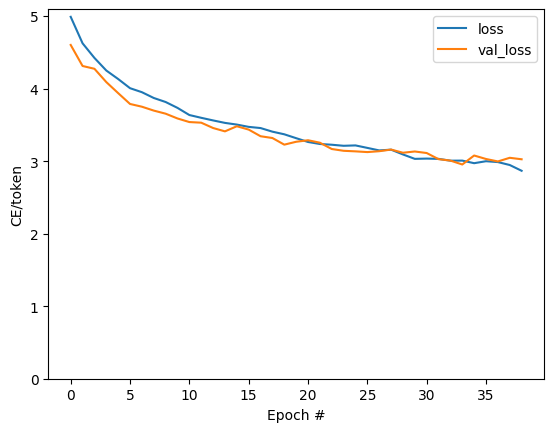

In [54]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

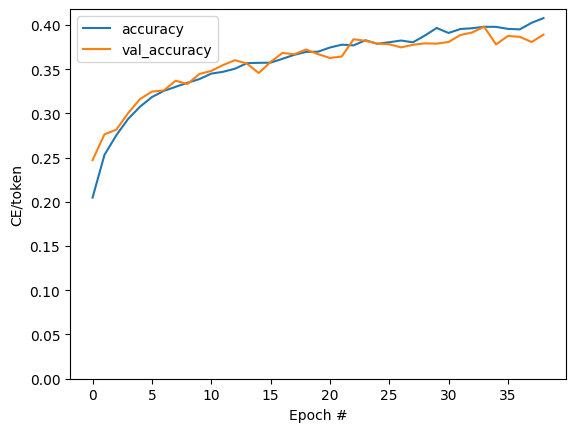

In [55]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

In [56]:
result = model.simple_gen(image, temperature=0.0)
result

'a man in a red wetsuit is surfing'

Split the output back into tokens:

In [57]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [58]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 9, 49]), TensorShape([1, 2, 9, 49])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [59]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [60]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([1.       , 1.       , 0.9999999, 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       ], dtype=float32)>

So here is where the model was focusing attention while generating each token of the output:

In [61]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

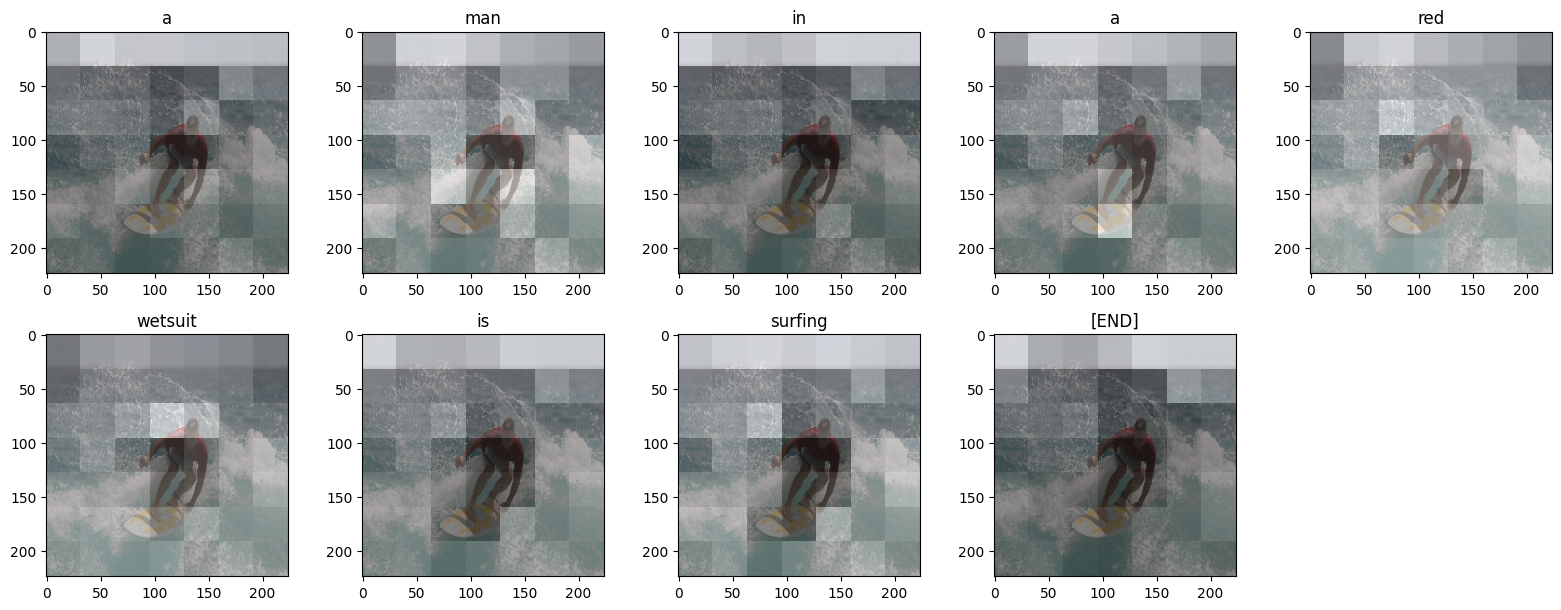

In [62]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Now put that together into a more usable function:

In [63]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


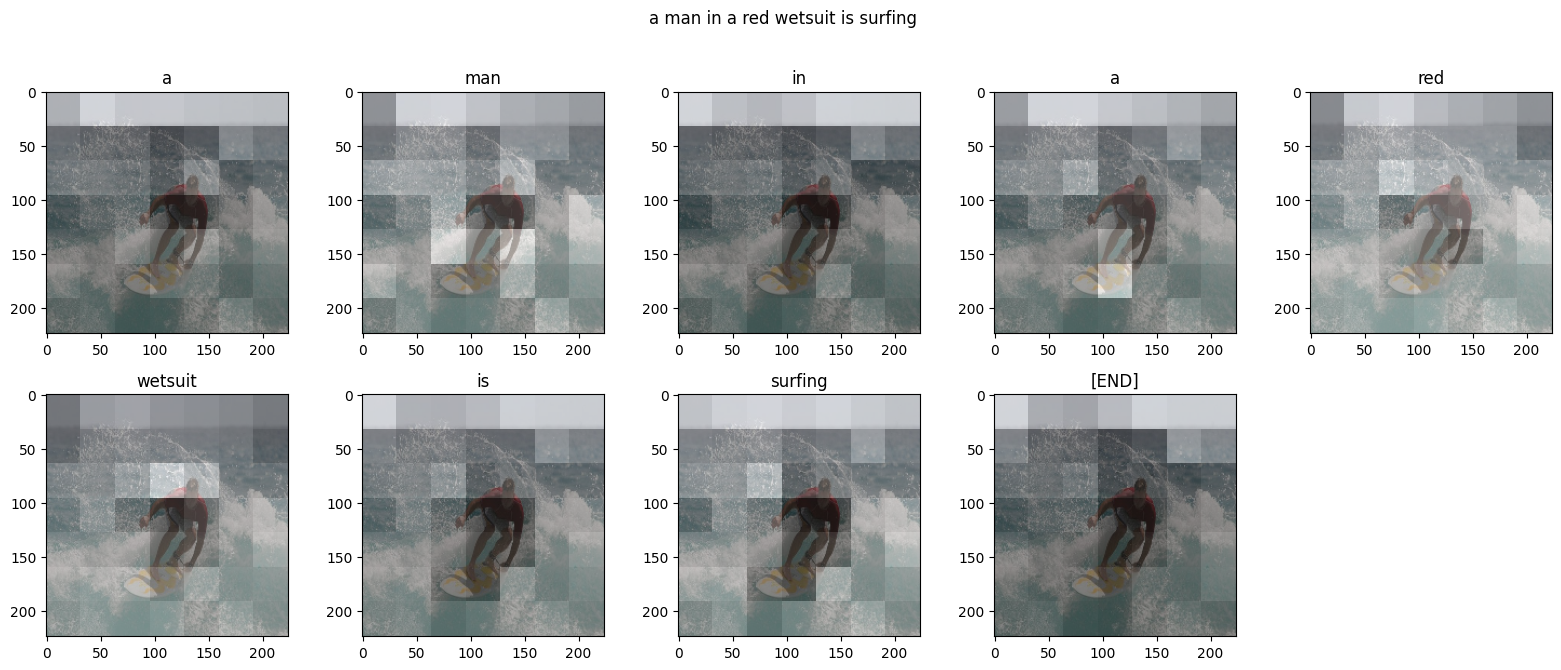

In [64]:
run_and_show_attention(model, image)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for strange results!)


 8192/67460 [==>...........................] - ETA: 0s

67460/67460 [==============================] - 0s 0us/step


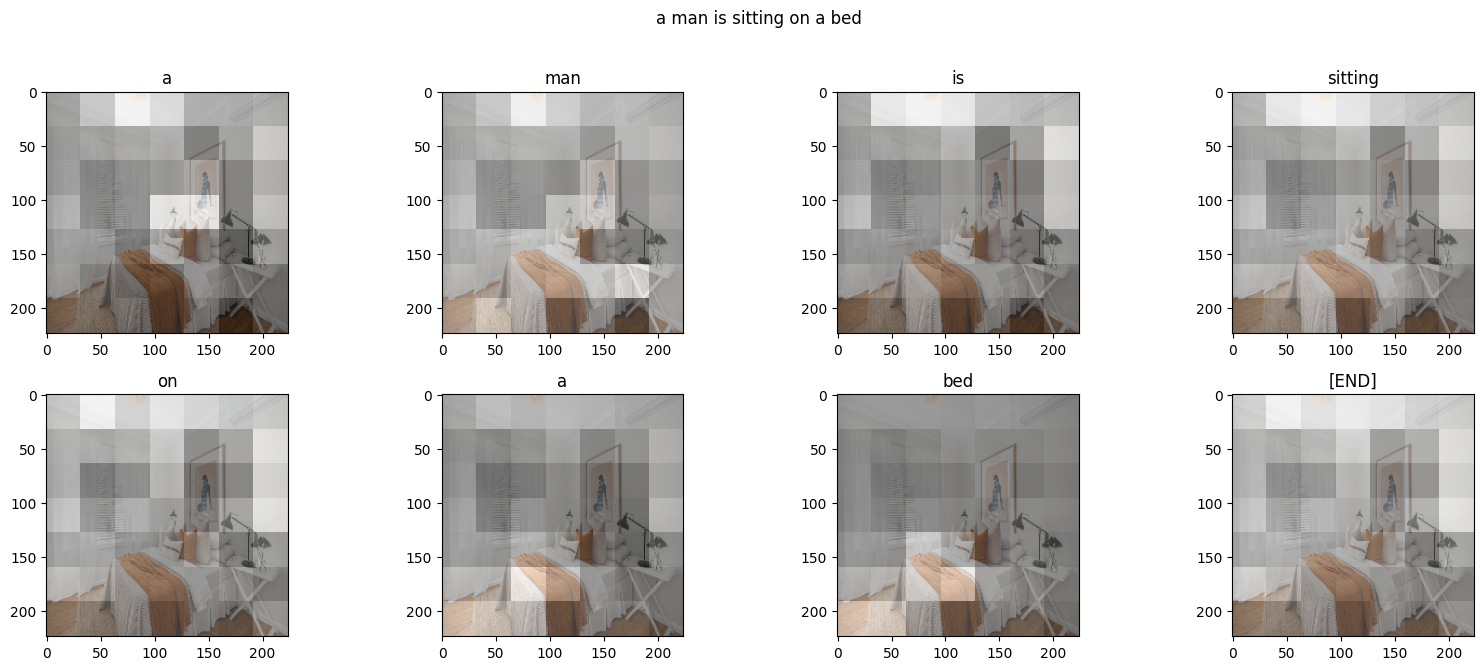

In [65]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)